#  **Fair and unbiased crime pattern and analysis for Los Angeles**


## Problem Statement

### Context
This project aims to analyze crime patterns in Los Angeles  using spatiotemporal analysis and predictive machine learning models to predict future crime hotspots. The research question focuses on how crime patterns vary across neighborhoods and time periods, and whether predictive models can improve accuracy in identifying high-risk areas.

### Key objectives include:
- **Geospatial Focus**: Analyzing crime concentration across areas and severity levels.
- **Temporal Focus**: Examining crime patterns based on time of day, week, and season, as well as crime type and severity.
- **Severity-Based Analysis**: Categorizing crimes into violent/non-violent and felony/misdemeanor for better understanding.
- **Predictive Modeling**: Developing models to forecast when and where severe crimes are likely to occur.

##  outcomes include:
- Visualizations of crime patterns.
- Identification of high-crime areas for targeted interventions.
- Predictive insights for proactive resource allocation.
- Fairness assessment to avoid biased predictions.

**AWS SageMaker** will be used for scalable, efficient data handling and model deployment.

### Dataset Description



| **Domain**               | **Variable Name**   | **Description**                                                                 |
|--------------------------|---------------------|---------------------------------------------------------------------------------|
| **Crime Information**     | **DR_NO**           | Unique identifier for each crime report (integer type).                         |
|                          | **Date Rptd**       | Date the crime was reported (string/object type).                               |
|                          | **DATE OCC**        | Date the crime occurred (string/object type).                                   |
|                          | **TIME OCC**        | Time the crime occurred (integer type).                                         |
|                          | **Status**          | Status of the crime report (string/object type).                                |
|                          | **Status Desc**     | Description of the status (string/object type).                                 |
| **Location Details**      | **AREA**            | Code representing the policing area (integer type).                             |
|                          | **AREA NAME**       | Name of the policing area (string/object type).                                 |
|                          | **Rpt Dist No**     | Reporting district number (integer type).                                       |
|                          | **LOCATION**        | General location of the crime incident (string/object type).                    |
|                          | **Cross Street**    | Nearest cross street to the crime location (string/object type).                |
|                          | **LAT**             | Latitude coordinate of the crime location (float type).                         |
|                          | **LON**             | Longitude coordinate of the crime location (float type).                        |
| **Crime Classification**  | **Part 1-2**        | Classification of the crime (Part 1 or Part 2) (integer type).                  |
|                          | **Crm Cd**          | Crime code (float type).                                                        |
|                          | **Crm Cd Desc**     | Description of the crime code (string/object type).                             |
|                          | **Crm Cd 1**        | Primary crime code (integer type).                                              |
|                          | **Crm Cd 2**        | Secondary crime code (if applicable) (integer type).                            |
|                          | **Crm Cd 3**        | Tertiary crime code (if applicable) (integer type).                             |
|                          | **Crm Cd 4**        | Quaternary crime code (if applicable) (integer type).                           |
| **Victim Details**        | **Vict Age**        | Age of the victim (integer type).                                               |
|                          | **Vict Sex**        | Sex of the victim.                                                              |
|                          | **Vict Descent**    | Descent or ethnicity of the victim (string/object type).                        |
| **Crime Modus Operandi**  | **Mocodes**         | Modus operandi codes indicating methods used in crime (integer type).           |
| **Premises & Weapon Details** | **Premis Cd**     | Premise code indicating location type (integer type).                           |
|                          | **Premis Desc**     | Description of the premise code (string/object type).                            |
|                          | **Weapon Used Cd**  | Code for the weapon used, if any (integer type).                                |
|                          | **Weapon Desc**     | Description of the weapon used (string/object type).                            |


## Importing necessary libraries

In [103]:
#Libraries to help with reading,statistically analysing and manipulating data
import pandas as pd
import numpy as np
import scipy.stats as stats
!pip install geopandas 
import geopandas as gpd
# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.metrics import (f1_score,auc,accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score,precision_recall_curve)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
# To impute missing values
from sklearn.impute import SimpleImputer
# To oversample and undersample data
!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)


# TModel building libraries
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import boto3
import os
import time
import json
import pickle
import psutil
import joblib
from sklearn.inspection import permutation_importance
import io
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore', message='Your installed version of s3fs is very old*')
warnings.filterwarnings('ignore', message='No artists with labels found to put in legend*')
from sklearn.metrics import classification_report, accuracy_score
import time
import tracemalloc
!pip install catboost
from catboost import CatBoostClassifier



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 142.4 MB/s eta 0:00:0000:0100:01


## Creating Utility functions for code reusablity

In [2]:

# Define S3 path
bucket = 'finalproject-mlc'

# Use boto3 to generate an S3 client
s3 = boto3.client('s3')

def read_s3_file(bucket_name: str, file_key: str, file_type: str = 'csv') -> pd.DataFrame:
    try:
        s3_uri = f's3://{bucket_name}/{file_key}'
        
        if file_type == 'csv':
            df = pd.read_csv(s3_uri)
        elif file_type == 'json':
            df = pd.read_json(s3_uri)
        elif file_type == 'parquet':
            df = pd.read_parquet(s3_uri)
        else:
            print(f"Unsupported file type: {file_type}. Please use 'csv', 'json', or 'parquet'.")
            return None
        
        print(f"Successfully loaded {file_key} from {bucket_name} as {file_type}.")
        return df
    
    except FileNotFoundError:
        print(f"File {file_key} not found.")
    except NoCredentialsError:
        print("AWS credentials not found.")
    except ClientError as e:
        print(f"AWS Client Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    
    return None



def upload_localfile_to_s3(local_file_path: str, bucket_name: str, s3_file_key: str) -> bool:
    """
    Uploads a local file to an S3 bucket.
    
    Args:
        local_file_path (str): Local path of the file to upload.
        bucket_name (str): Name of the target S3 bucket.
        s3_file_key (str): S3 key (path inside the bucket).
        
    Returns:
        bool: True if upload was successful, False otherwise.
    """
    try:
        s3 = boto3.client('s3')
        s3.upload_file(local_file_path, bucket_name, s3_file_key)
        print(f"Successfully uploaded {local_file_path} to s3://{bucket_name}/{s3_file_key}")
        return True
    
    except FileNotFoundError:
        print(f"Local file {local_file_path} not found.")
    except NoCredentialsError:
        print("AWS credentials not found.")
    except ClientError as e:
        print(f"AWS Client Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    
    return False


def save_json(obj, filepath):
    with open(filepath, 'w') as f:
        json.dump(obj, f, indent=4)

def save_pickle(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)


def create_timestamp_folder(base_folder):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder = os.path.join(base_folder, f"run_{timestamp}")
    os.makedirs(folder, exist_ok=True)
    return folder


def upload_to_s3(obj, bucket, key, obj_type="dataframe", index=False):
    """
    Uploads an object (DataFrame, JSON dict, or Matplotlib figure) to S3 directly without saving locally.
    
    Args:
        obj: Object to upload. (pandas DataFrame, dict for JSON, matplotlib Figure)
        bucket: Bucket name (string)
        key: S3 key where to upload (string, like 'Models/rf_model.pkl')
        obj_type: "dataframe", "json", "plot", or "pickle"
        index: Whether to include index when uploading dataframe (default False)
    """
    if obj_type == "dataframe":
        buffer = io.StringIO()
        obj.to_csv(buffer, index=index)
        body = buffer.getvalue()
        s3.put_object(Bucket=bucket, Key=key, Body=body)
        
    elif obj_type == "json":
        body = json.dumps(obj)
        s3.put_object(Bucket=bucket, Key=key, Body=body)
        
    elif obj_type == "plot":
        buffer = io.BytesIO()
        obj.savefig(buffer, format='png', bbox_inches='tight')
        buffer.seek(0)
        body = buffer.getvalue()
        s3.put_object(Bucket=bucket, Key=key, Body=body)
        
    elif obj_type == "pickle":
        buffer = io.BytesIO()
        pickle.dump(obj, buffer)
        buffer.seek(0)
        body = buffer.getvalue()
        s3.put_object(Bucket=bucket, Key=key, Body=body)
        
    else:
        raise ValueError(f"Unsupported obj_type '{obj_type}'. Supported: dataframe, json, plot, pickle")

    print(f"Uploaded {obj_type} to s3://{bucket}/{key}")


## Loading the dataset

In [3]:
file_key = 'Crime_Hotspot_Prediction/Data/Raw_data/Crimedata.csv'  
data = read_s3_file(bucket,file_key)

Successfully loaded Crime_Hotspot_Prediction/Data/Raw_data/Crimedata.csv from finalproject-mlc as csv.


## Data Overview

#### displaying first few rows

In [4]:
data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,0,M,O,101.0,STREET,NaN,NaN,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,NaN,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19,M,O,405.0,CLOTHING STORE,NaN,NaN,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


#### shape of dataset

In [5]:
data.shape

(1005104, 28)

#### Data pre-*processing*

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005104 entries, 0 to 1005103
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1005104 non-null  int64  
 1   Date Rptd       1005104 non-null  object 
 2   DATE OCC        1005104 non-null  object 
 3   TIME OCC        1005104 non-null  int64  
 4   AREA            1005104 non-null  int64  
 5   AREA NAME       1005104 non-null  object 
 6   Rpt Dist No     1005104 non-null  int64  
 7   Part 1-2        1005104 non-null  int64  
 8   Crm Cd          1005104 non-null  int64  
 9   Crm Cd Desc     1005104 non-null  object 
 10  Mocodes         853380 non-null   object 
 11  Vict Age        1005104 non-null  int64  
 12  Vict Sex        860353 non-null   object 
 13  Vict Descent    860341 non-null   object 
 14  Premis Cd       1005088 non-null  float64
 15  Premis Desc     1004516 non-null  object 
 16  Weapon Used Cd  327244 non-null   fl

#### Data Types:

**Numerical Types:**


1.   int64: 7 columns
2.   float64: 8 columns

**Categorical Types:**


1.   object: 13 columns




#### Missing Data Summary

Out of the 28 columns, 12 had missing values with a wide range. Below is the breakdown:

##### Columns with Significant Missing Data:
- **Crm Cd 2**: 935,958 missing values (~93% missing).
- **Crm Cd 3**: 1,002,789 missing values (~99% missing).
- **Crm Cd 4**: 1,005,040 missing values (~100% missing).
- **Weapon Used Cd**: 677,860 missing values (~67% missing).
- **Weapon Desc**: 677,860 missing values (~67% missing).
- **Cross Street**: 850,867 missing values (~85% missing).

##### Columns with Moderate Missing Data:
- **Mocodes**: 151,724 missing values (~15% missing).
- **Vict Sex**: 144,751 missing values (~14% missing).
- **Vict Descent**: 144,763 missing values (~14% missing).

##### Columns with Few Missing Values:
- **Premis Cd**: 16 missing values (~0.0015% missing).
- **Status**: 1 missing value (~0.0001% missing).
- **Crm Cd 1**: 11 missing values (~0.0011% missing).

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
DR_NO,1005104.0,2.202253e+08,1.319645e+07,817.0000,2.106169e+08,2.209160e+08,2.311104e+08,2.521041e+08
TIME OCC,1005104.0,1.339912e+03,6.510650e+02,1.0000,9.000000e+02,1.420000e+03,1.900000e+03,2.359000e+03
AREA,1005104.0,1.069102e+01,6.110349e+00,1.0000,5.000000e+00,1.100000e+01,1.600000e+01,2.100000e+01
Rpt Dist No,1005104.0,1.115561e+03,6.111694e+02,101.0000,5.870000e+02,1.139000e+03,1.613000e+03,2.199000e+03
Part 1-2,1005104.0,1.400287e+00,4.899567e-01,1.0000,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
Crm Cd,1005104.0,5.001423e+02,2.052598e+02,110.0000,3.310000e+02,4.420000e+02,6.260000e+02,9.560000e+02
Vict Age,1005104.0,2.891422e+01,2.199366e+01,-4.0000,0.000000e+00,3.000000e+01,4.400000e+01,1.200000e+02
Premis Cd,1005088.0,3.056138e+02,2.193088e+02,101.0000,1.010000e+02,2.030000e+02,5.010000e+02,9.760000e+02
Weapon Used Cd,327244.0,3.639493e+02,1.237384e+02,101.0000,3.110000e+02,4.000000e+02,4.000000e+02,5.160000e+02
Crm Cd 1,1005093.0,4.999029e+02,2.050604e+02,110.0000,3.310000e+02,4.420000e+02,6.260000e+02,9.560000e+02


In [8]:
data.mode().iloc[0]

DR_NO                                                        817
Date Rptd                                 02/02/2023 12:00:00 AM
DATE OCC                                  01/01/2020 12:00:00 AM
TIME OCC                                                  1200.0
AREA                                                         1.0
AREA NAME                                                Central
Rpt Dist No                                                162.0
Part 1-2                                                     1.0
Crm Cd                                                     510.0
Crm Cd Desc                                     VEHICLE - STOLEN
Mocodes                                                     0344
Vict Age                                                     0.0
Vict Sex                                                       M
Vict Descent                                                   H
Premis Cd                                                  101.0
Premis Desc              

#### General Insights

1. **Time of Occurrence**:
   - The **TIME OCC** mode value of **1200** indicates that many crimes in the dataset occurred around **noon**. This suggests a notable concentration of crimes during midday hours, which is important for identifying peak crime times.

2. **Policing Area**:
   - The **AREA** mode value of **1** shows that most crimes occurred in that policing area. This suggests that some areas experience a higher concentration of crimes compared to other regions.

3. **Reporting District Number**:
   - The **Rpt Dist No** mode value of **162** points to a specific district as a hotspot. While the distribution of this variable spans a wide range, the mode indicates that crimes are clustered around certain districts, which can inform resource allocation.

4. **Crime Type (Part 1-2)**:
   - The **Part 1-2** mode value of **1** shows that the majority of crimes reported are **Part 1** crimes, which are typically more serious offenses. This aligns with the trend in crime data where higher severity crimes are more frequently reported.

5. **Crime Code**:
   - The **Crm Cd** mode of **510** corresponds to **VEHICLE - STOLEN**, indicating that **vehicle thefts** are a prominent issue in the area under study. This helps highlight this particular crime type as the most frequently reported.

6. **Victim Information**:
   - The **Vict Age** mode of **0** suggests that a significant portion of victims might be categorized under certain reporting protocols (e.g., juveniles or cases without clear victim age information). The **Vict Sex** mode of **M** and **Vict Descent** mode of **H** indicate that the majority of victims are **male** and of **Hispanic descent**.

7. **Premises Information**:
   - The **Premis Cd** mode of **101** indicates that most crimes took place on the **street**, and the **Premis Desc** value of **STREET** clarifies that the majority of crimes occurred in **public spaces** rather than private property.

8. **Weapon Usage**:
   - The **Weapon Used Cd** mode of **400** refers to **STRONG-ARM** (hands, fist, feet, or bodily force), suggesting that **physical force** was frequently used in the crimes in this dataset. This indicates a higher occurrence of **violent, confrontational crimes**.

9. **Crime Codes 1-4**:
    - These values indicate that the primary crime was related to **vehicle theft** (**510**), with secondary, tertiary, and quaternary codes showing minimal variation (**998**).



















In [9]:
data.isnull().sum()

DR_NO                   0
Date Rptd               0
DATE OCC                0
TIME OCC                0
AREA                    0
AREA NAME               0
Rpt Dist No             0
Part 1-2                0
Crm Cd                  0
Crm Cd Desc             0
Mocodes            151724
Vict Age                0
Vict Sex           144751
Vict Descent       144763
Premis Cd              16
Premis Desc           588
Weapon Used Cd     677860
Weapon Desc        677860
Status                  1
Status Desc             0
Crm Cd 1               11
Crm Cd 2           935958
Crm Cd 3          1002789
Crm Cd 4          1005040
LOCATION                0
Cross Street       850867
LAT                     0
LON                     0
dtype: int64

## Data Cleaning 



- **Crm Cd 1**: Dropped  
  *Reason*: Same as `Crime Cd`.

- **Crm Cd 2, Crm Cd 3, Crm Cd 4**: Dropped  
  *Reason*: Almost complete missing data.

- **Weapon Used Cd**: Encoded as 'Weapon Usage Not Known'  
  *Reason*: Missing values indicate unknown weapon usage.

- **Weapon Desc, Vict Descent**: Encoded as 'Unknown'  
  *Reason*: Missing values indicate unknown weapon usage.

- **Cross Street**: Dropped  
  *Reason*: Significant amount of missing data and alternative variables available.

- **Mocodes, Vict Sex**: Imputed with Mode  
  *Reason*: Moderate missing data, imputed with the most frequent value (mode).

- **Premis Cd**: Dropped rows  
  *Reason*: Few missing values, rows dropped.

- **Status (Target Variable)**: Dropped rows  
  *Reason*: Few missing values, rows dropped.

- **Vict Age**: Corrected with mean replacement and capped  
  *Reason*: Negative values were corrected with the mean, and extreme age values were capped.


In [10]:
# Drop Crm Cd 1
data = data.drop(columns=['Crm Cd 1'])

# Drop Crm Cd 2, Crm Cd 3, Crm Cd 4
data = data.drop(columns=['Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4'])

# Encode missing values in 'Weapon Used Cd' as 'Weapon Usage Not Known'
data['Weapon Used Cd'] = data['Weapon Used Cd'].fillna('Weapon Usage Not Known')

# Encode missing values in 'Weapon Desc',Premis Desc' and 'Vict Descent' as 'Unknown'
data['Weapon Desc'] = data['Weapon Desc'].fillna('Unknown')
data['Vict Descent'] = data['Vict Descent'].fillna('X')
data['Premis Desc'] = data['Premis Desc'].fillna('Unknown')


# Drop column  'Cross Street'
data = data.drop(columns=['Cross Street'])

# Impute 'Mocodes' and 'Vict Sex' with the mode (most frequent value)
data['Mocodes'] = data['Mocodes'].fillna(data['Mocodes'].mode()[0])
data['Vict Sex'] = data['Vict Sex'].fillna('X')
data = data.drop(data[data['Vict Sex'] == '-'].index)


# Drop rows where 'Premis Cd' has missing values
data = data.dropna(subset=['Premis Cd'])

# Drop rows where 'Status' has missing values
data = data.dropna(subset=['Status'])

# Correct negative values in 'Vict Age' using mean replacement and cap extreme values
mean_age = data['Vict Age'][data['Vict Age'] > 0].mean()  # Exclude negative values
data['Vict Age'] = data['Vict Age'].apply(lambda x: mean_age if x < 0 else x)

# Cap the age to 100 years
data['Vict Age'] = data['Vict Age'].apply(lambda x: min(max(x, 0), 100))





In [11]:
data.isnull().sum()

DR_NO             0
Date Rptd         0
DATE OCC          0
TIME OCC          0
AREA              0
AREA NAME         0
Rpt Dist No       0
Part 1-2          0
Crm Cd            0
Crm Cd Desc       0
Mocodes           0
Vict Age          0
Vict Sex          0
Vict Descent      0
Premis Cd         0
Premis Desc       0
Weapon Used Cd    0
Weapon Desc       0
Status            0
Status Desc       0
LOCATION          0
LAT               0
LON               0
dtype: int64

In [12]:
key = 'Crime_Hotspot_Prediction/Data/Cleaned_data/Cleaned_data_V1'  
upload_to_s3(data,bucket,key)

Uploaded dataframe to s3://finalproject-mlc/Crime_Hotspot_Prediction/Data/Cleaned_data/Cleaned_data_V1


## **Exploratory Data Analysis (EDA):**


In this context, the dataset comprises information about crime reports, including the nature of the crime, victim details, location, and other associated metadata.

The goal of EDA in this dataset is to better understand the crime patterns, victim demographics, and the relationship between various factors such as time of occurrence, crime classification, and the location of the crimes. We want to look for patterns based on crime status, geographic location, the demographics of victims, and other crime-specific attributes.

Before moving to model building, it’s important to visualize and summarize these variables to ensure they make sense and that any missing or inconsistent data is addressed. So Let's Start!!!

### **1. What is the distribution of crime incidents over time (by Year)?**

In [13]:
#Coverting 'DATE OCC' to dataetime variable
data['DATE OCC'] = pd.to_datetime(data['DATE OCC'], errors='coerce')

# Extract year from 'DATE OCC'
data['Year'] = data['DATE OCC'].dt.year

# Count the number of crimes in each year
crime_counts_by_year = data['Year'].value_counts().sort_index()




Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Time_based/Number_of_crimes_by_year.png


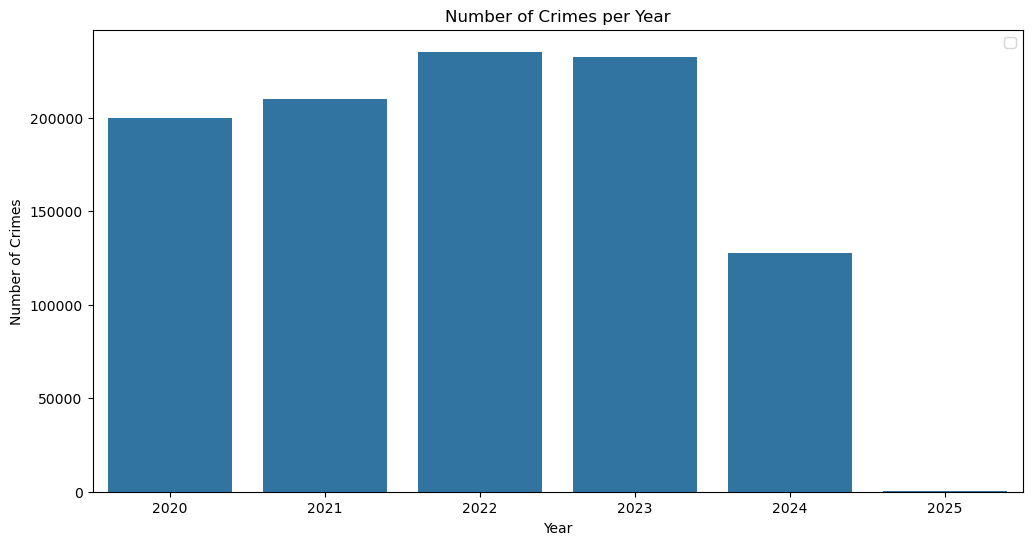

In [14]:
# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 6))  # Create fig and ax
sns.barplot(x=crime_counts_by_year.index, y=crime_counts_by_year.values, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Crimes')
ax.set_title('Number of Crimes per Year')
ax.legend()

# Upload the figure directly to S3
key = 'Crime_Hotspot_Prediction/EDA/Time_based/Number_of_crimes_by_year.png'
upload_to_s3(fig, bucket, key,'plot')
plt.show()

### 1. Data Cleaning: Removing the 2024 Records

During EDA, we observed that the data for the year 2024 showed a sharp drop in the number of crime records compared to 2020–2023.  
To maintain consistency and ensure the quality of the dataset, we removed all records from the year 2024.


Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/number_of_crimes_per_year_with_anomaly.png


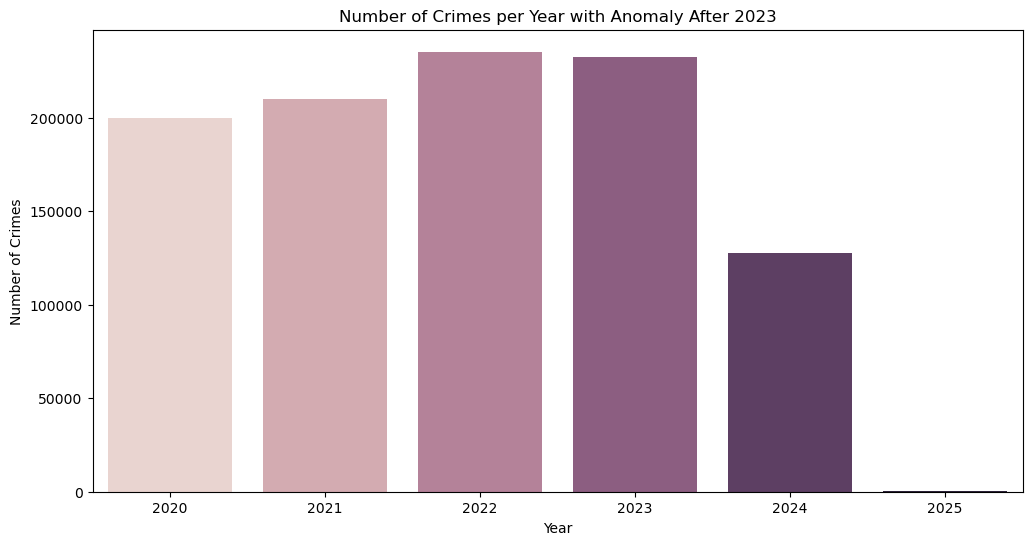

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

# Correct barplot
sns.barplot(x=crime_counts_by_year.index, y=crime_counts_by_year.values, hue=crime_counts_by_year.index,  ax=ax, legend=False)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Crimes')
ax.set_title('Number of Crimes per Year with Anomaly After 2023')

# Add legend only if labels exist
if ax.get_legend_handles_labels()[1]:
    ax.legend()

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/number_of_crimes_per_year_with_anomaly.png'
upload_to_s3(fig, bucket, key, 'plot')

# Show
plt.show()


In [16]:
data = data[data['Year'] <= 2023]


 ### 2.**How has the overall number of crimes changed over time in Los Angeles?**


Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Time_based/overall_crime_trend.png


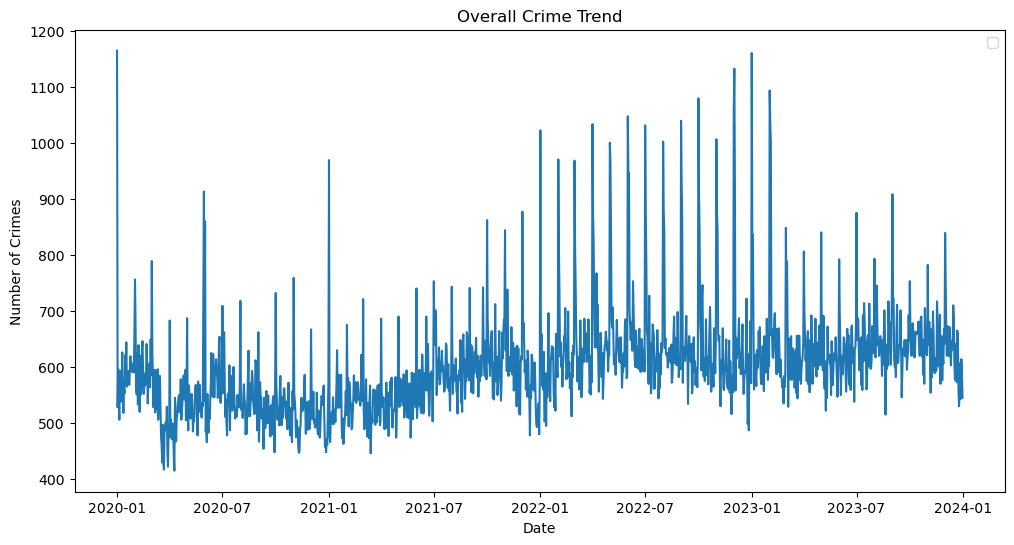

In [17]:
# Count the number of crimes by date
crime_counts = data.groupby('DATE OCC').size()

# Create the time series plot
fig, ax = plt.subplots(figsize=(12, 6))  # Create fig and ax
sns.lineplot(x=crime_counts.index, y=crime_counts.values, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Crimes')
ax.set_title('Overall Crime Trend')
ax.legend()

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Time_based/overall_crime_trend.png'
upload_to_s3(fig, bucket, key, 'plot')
plt.show()


### 3. **What is the average number of crimes occurring in each month across all years?**

In [18]:
# Extract month from 'DATE OCC'
data['Month'] = data['DATE OCC'].dt.month

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Time_based/average_crimes_per_month.png


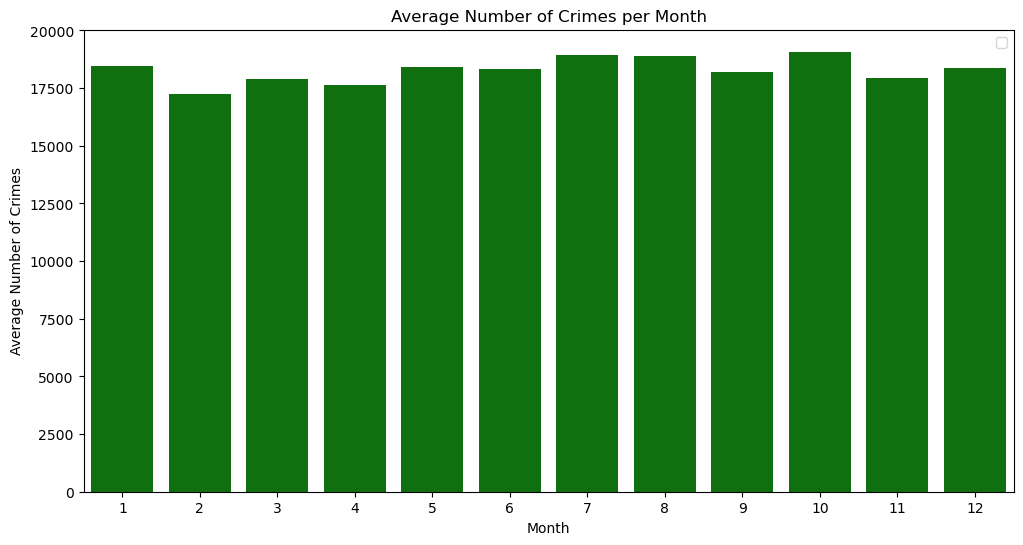

In [19]:
# Count the number of crimes for each month
monthly_crimes = data.groupby('Month').size()

# Calculate the average number of crimes per month
average_crimes_per_month = monthly_crimes / data['Year'].nunique()

# Create the bar plot for average monthly crime counts
fig, ax = plt.subplots(figsize=(12, 6))  # Create fig and ax
sns.barplot(x=average_crimes_per_month.index, y=average_crimes_per_month.values, color='green', ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Average Number of Crimes')
ax.set_title('Average Number of Crimes per Month')
ax.legend()

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Time_based/average_crimes_per_month.png'
upload_to_s3(fig, bucket, key, 'plot')
plt.show()


In [20]:
data['TIME OCC'] = data['TIME OCC'].astype(str).str.zfill(4)  # Ensure 4 digits for time

# Extract the hour from 'TIME OCC' column (first two digits represent the hour)
data['Hour'] = data['TIME OCC'].str[:2].astype(int)

# Extract day of the week from 'DATE OCC' and map to day names
data['DayOfWeek'] = data['DATE OCC'].dt.dayofweek
day_of_week_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
data['DayOfWeek'] = data['DayOfWeek'].map(day_of_week_map)


### 4.What patterns emerge in crime occurrences based on the day of the week and the time of day?


Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Time_based/crime_distribution_heatmap.png


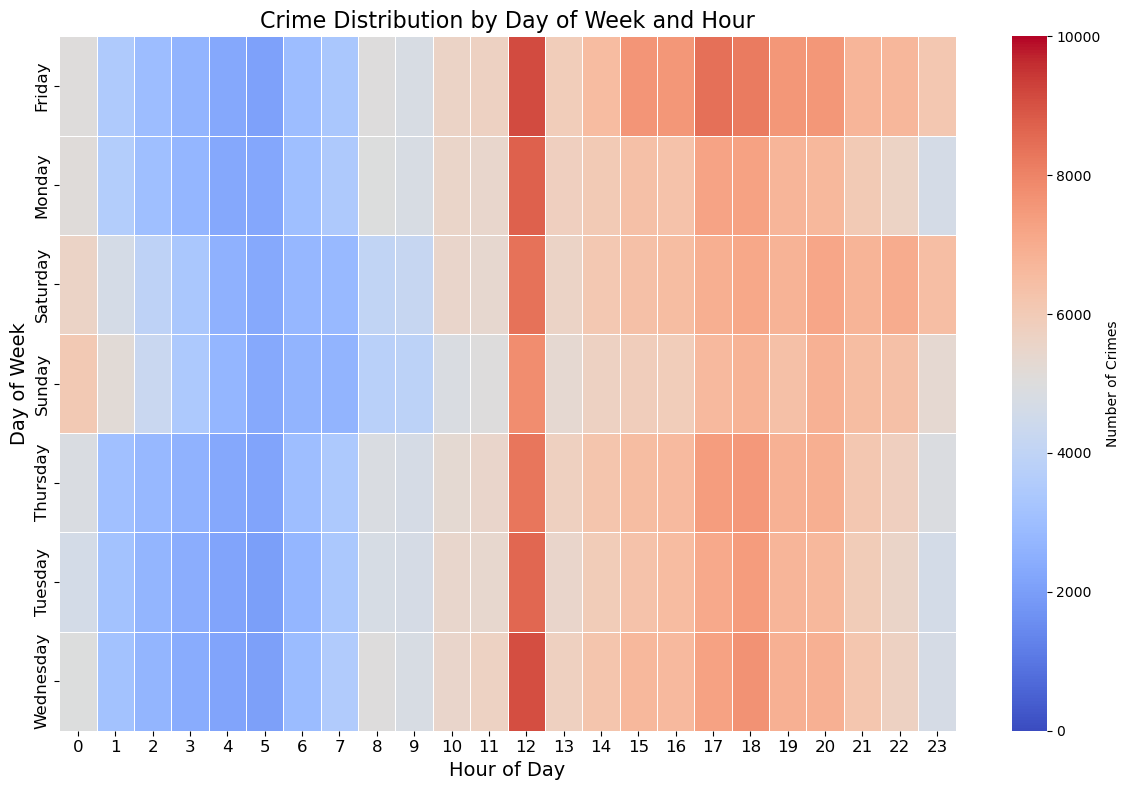

In [21]:
# Create a pivot table of crimes by Day of Week and Hour
crime_heatmap_data = data.pivot_table(index='DayOfWeek', columns='Hour', values='DATE OCC', aggfunc='count')

max_crimes = crime_heatmap_data.values.max()
vmax = (max_crimes // 1000 + 1) * 1000  # Round up to the nearest 1000
vmin = 0  # Starting at 0 for minimum value

fig, ax = plt.subplots(figsize=(12, 8))  # Create fig and ax
sns.heatmap(crime_heatmap_data, cmap="coolwarm", annot=False, cbar_kws={'label': 'Number of Crimes'},
            linewidths=0.5, vmax=vmax, vmin=vmin, ax=ax)

ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Day of Week', fontsize=14)
ax.set_title('Crime Distribution by Day of Week and Hour', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Time_based/crime_distribution_heatmap.png'
upload_to_s3(fig, bucket, key, 'plot')
plt.tight_layout()
plt.show()


### 5.How does the average number of crimes vary across different quarters of the year?


In [22]:
data['Quarter'] = data['DATE OCC'].dt.quarter


Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Time_based/average_crimes_per_quarter.png


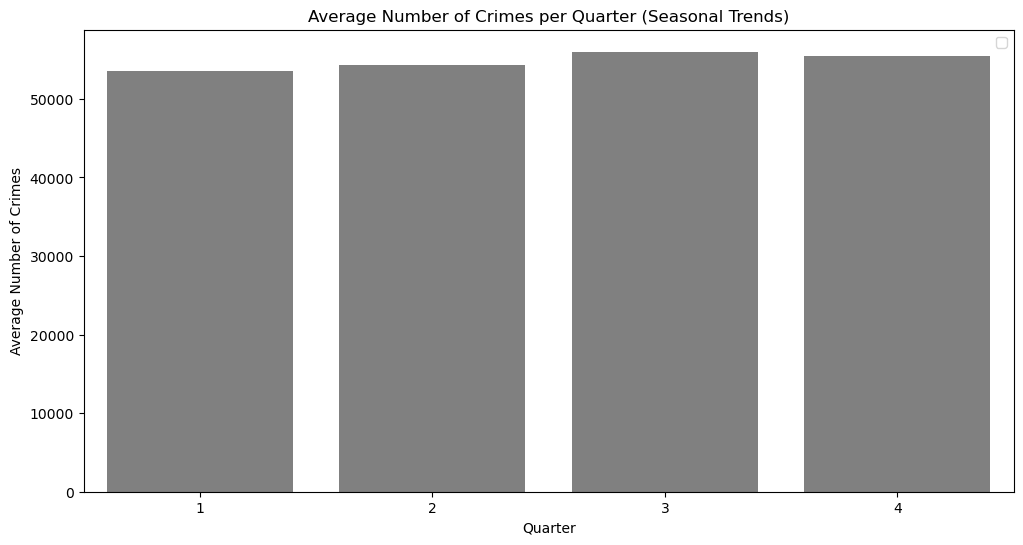

In [23]:
# Calculate the average number of crimes per quarter
average_crimes_by_quarter = data.groupby('Quarter').size() / data['Year'].nunique()

# Create the bar plot for average quarterly crime counts
fig, ax = plt.subplots(figsize=(12, 6))  # Create fig and ax
sns.barplot(x=average_crimes_by_quarter.index, y=average_crimes_by_quarter.values, color='grey', ax=ax)
ax.set_xlabel('Quarter')
ax.set_ylabel('Average Number of Crimes')
ax.set_title('Average Number of Crimes per Quarter (Seasonal Trends)')
ax.legend()

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Time_based/average_crimes_per_quarter.png'
upload_to_s3(fig, bucket, key, 'plot')

plt.show()


### 6. Is there a significant difference in the distribution of crimes between weekdays and weekends?


In [24]:
data['Weekend'] = data['DATE OCC'].dt.weekday.apply(lambda x: 'Weekend' if x in [4,5, 6] else 'Weekday')

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Time_based/crime_occurrence_weekday_vs_weekend_violin.png


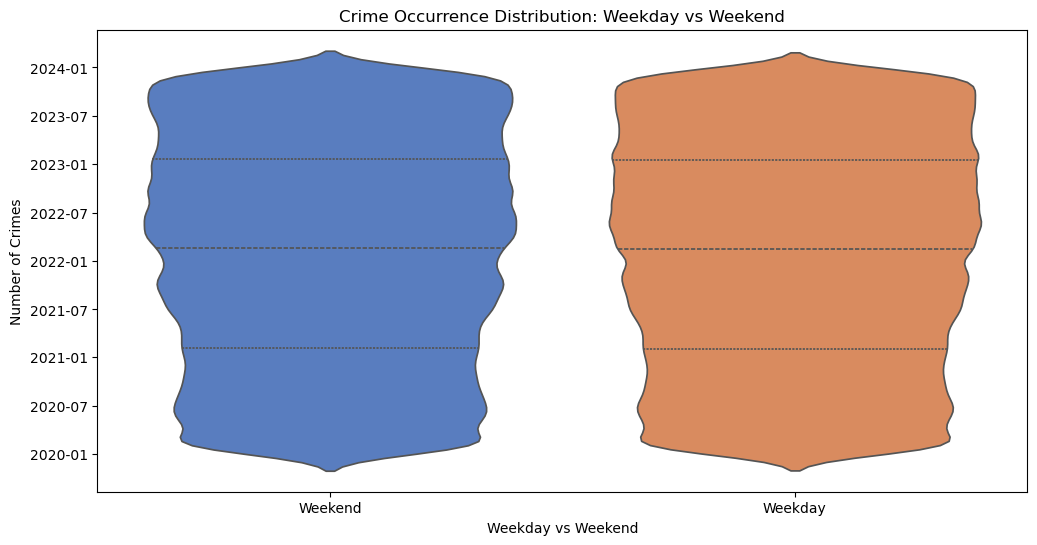

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.violinplot(x='Weekend', y='DATE OCC', hue='Weekend', data=data, inner="quart", palette="muted", ax=ax, legend=False)

ax.set_title('Crime Occurrence Distribution: Weekday vs Weekend')
ax.set_xlabel('Weekday vs Weekend')
ax.set_ylabel('Number of Crimes')

# Add legend only if handles exist
if ax.get_legend_handles_labels()[1]:
    ax.legend()

# Upload to S3
key = 'Crime_Hotspot_Prediction/EDA/Time_based/crime_occurrence_weekday_vs_weekend_violin.png'
upload_to_s3(fig, bucket, key, 'plot')

# Show
plt.show()


### 6. Are there significant differences in the distribution, median, and variability of daily crime counts between weekdays and weekends?

In [26]:
data['Date'] = pd.to_datetime(data['DATE OCC'])  

In [27]:
# Create a Weekday/Weekend column
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['WeekType'] = data['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')


Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Time_based/daily_crime_counts_weekday_vs_weekend.png


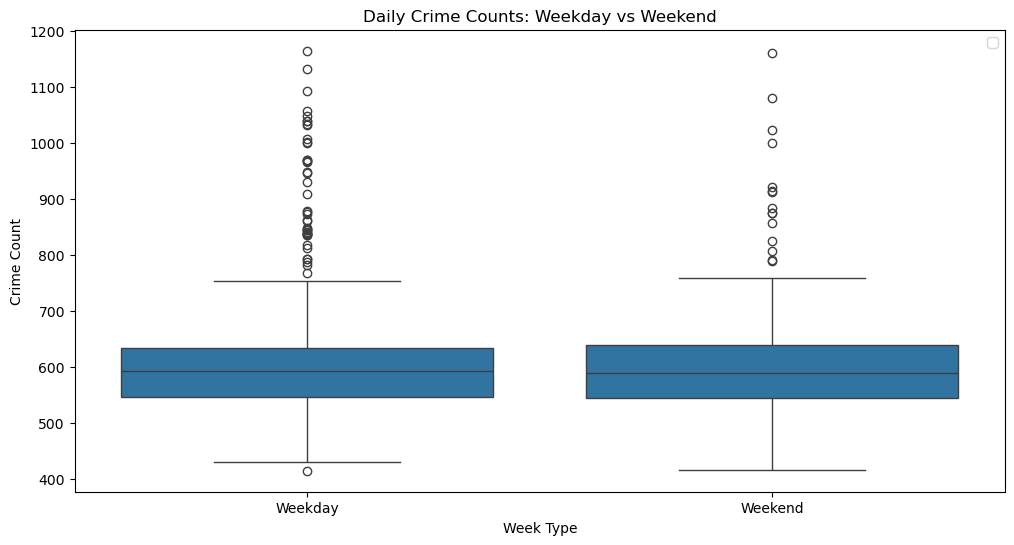

In [28]:
# Aggregate daily crime counts
daily_crimes = data.groupby(['Date', 'WeekType']).size().reset_index(name='CrimeCount')

# Separate the two groups (if needed later)
weekend = daily_crimes[daily_crimes['WeekType'] == 'Weekend']['CrimeCount']
weekday = daily_crimes[daily_crimes['WeekType'] == 'Weekday']['CrimeCount']

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 6))  # Create fig and ax
sns.boxplot(data=daily_crimes, x='WeekType', y='CrimeCount', ax=ax)
ax.set_title('Daily Crime Counts: Weekday vs Weekend')
ax.set_xlabel('Week Type')
ax.set_ylabel('Crime Count')
ax.legend()

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Time_based/daily_crime_counts_weekday_vs_weekend.png'
upload_to_s3(fig, bucket, key, 'plot')
plt.show()


In [29]:
# Shapiro-Wilk Test for normality
print("Shapiro-Wilk test:")
print("Weekday:", stats.shapiro(weekday))
print("Weekend:", stats.shapiro(weekend))


Shapiro-Wilk test:
Weekday: ShapiroResult(statistic=0.8327911021027891, pvalue=1.1363279217161113e-31)
Weekend: ShapiroResult(statistic=0.8659046102128054, pvalue=1.6868128217386967e-18)


**Shapiro-Wilk p-value < 0.05:** This indicates that the data is not normally distributed. Both the Weekday and Weekend groups have p-values much smaller than 0.05, suggesting that both groups are significantly non-normal.

In [30]:
mw_test = stats.mannwhitneyu(weekday, weekend, alternative='two-sided')
print("Mann-Whitney U test result:", mw_test)

Mann-Whitney U test result: MannwhitneyuResult(statistic=217962.0, pvalue=0.9973177565376665)


**Based on the Mann-Whitney U test, we can conclude that there is no significant difference in the distribution of crime occurrences between weekdays and weekends. The p-value is so large that we don't have enough evidence to support a difference between the two groups.**

### 7. What are the longer-term trends in crime occurrence over time, smoothed using a 30-day rolling average?

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Time_based/30_day_rolling_average_crime_occurrence.png


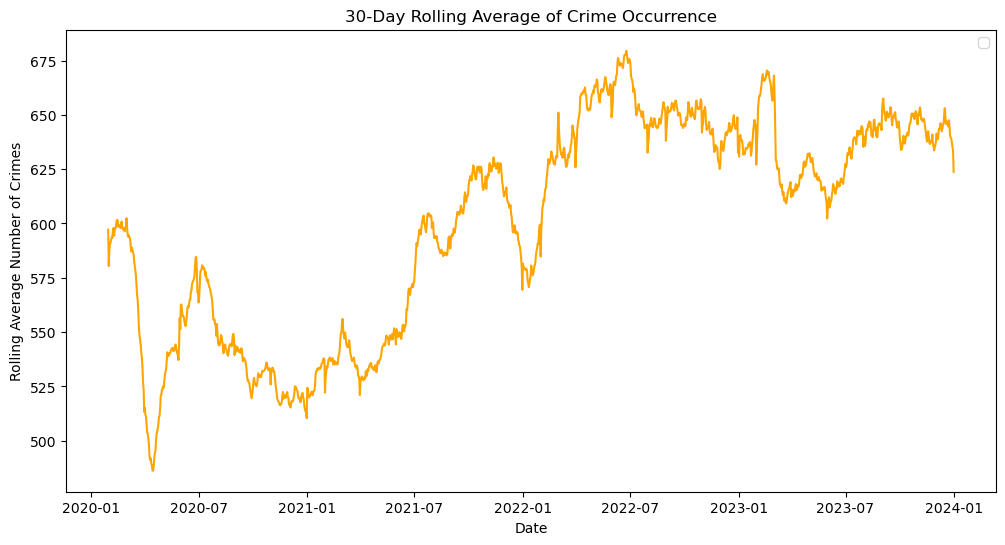

In [31]:
# Calculate the 30-day rolling average
crime_counts_rolling_avg = crime_counts.rolling(window=30).mean()

# Create the rolling average line plot
fig, ax = plt.subplots(figsize=(12, 6))  # Create fig and ax
sns.lineplot(x=crime_counts_rolling_avg.index, y=crime_counts_rolling_avg.values, color='orange', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Rolling Average Number of Crimes')
ax.set_title('30-Day Rolling Average of Crime Occurrence')
ax.legend()

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Time_based/30_day_rolling_average_crime_occurrence.png'
upload_to_s3(fig, bucket, key, 'plot')
plt.show()


## Feature Engineering Part 1: Grouping Crime Descriptions into Broader Crime Categories

To make analysis more structured and interpretable, we mapped detailed crime descriptions into broader, high-level categories such as 'VIOLENT CRIMES', 'PROPERTY CRIMES', 'SEX CRIMES', 'CRIMES AGAINST CHILDREN', 'FRAUD & FINANCIAL CRIMES', 'CRIMES AGAINST PUBLIC ORDER & SAFETY', and 'CRIMES AGAINST JUSTICE & GOVERNMENT'.  
This consolidation reduces complexity, enables meaningful aggregation, and helps highlight broader crime trends across the dataset.


In [32]:
crime_category_map = {
    # VIOLENT CRIMES
    'ARSON': 'VIOLENT CRIMES',
    'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER': 'VIOLENT CRIMES',
    'ASSAULT WITH DEADLY WEAPON': 'VIOLENT CRIMES',
    'AGGRAVATED ASSAULT': 'VIOLENT CRIMES',
    'ATTEMPTED ROBBERY': 'VIOLENT CRIMES',
    'BATTERY - SIMPLE ASSAULT': 'VIOLENT CRIMES',
    'BATTERY ON A FIREFIGHTER': 'VIOLENT CRIMES',
    'BATTERY POLICE (SIMPLE)': 'VIOLENT CRIMES',
    'BRANDISH WEAPON': 'VIOLENT CRIMES',
    'CRIMINAL HOMICIDE': 'VIOLENT CRIMES',
    'CRIMINAL THREATS - NO WEAPON DISPLAYED': 'VIOLENT CRIMES',
    'DISCHARGE FIREARMS/SHOTS FIRED': 'VIOLENT CRIMES',
    'DRUNK ROLL': 'VIOLENT CRIMES',
    'EXTORTION': 'VIOLENT CRIMES',
    'FALSE IMPRISONMENT': 'VIOLENT CRIMES',
    'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS': 'VIOLENT CRIMES', # Broadly categorized as violent exploitation
    'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE': 'VIOLENT CRIMES',
    'INTIMATE PARTNER - AGGRAVATED ASSAULT': 'VIOLENT CRIMES',
    'INTIMATE PARTNER - SIMPLE ASSAULT': 'VIOLENT CRIMES',
    'KIDNAPPING': 'VIOLENT CRIMES',
    'KIDNAPPING - GRAND ATTEMPT': 'VIOLENT CRIMES',
    'LYNCHING': 'VIOLENT CRIMES',
    'LYNCHING - ATTEMPTED': 'VIOLENT CRIMES',
    'MANSLAUGHTER, NEGLIGENT': 'VIOLENT CRIMES',
    'OTHER ASSAULT': 'VIOLENT CRIMES',
    'ROBBERY': 'VIOLENT CRIMES',
    'SHOTS FIRED AT INHABITED DWELLING': 'VIOLENT CRIMES',
    'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT': 'VIOLENT CRIMES',
    'STALKING': 'VIOLENT CRIMES',
    'THREATENING PHONE CALLS/LETTERS': 'VIOLENT CRIMES',
    'THROWING OBJECT AT MOVING VEHICLE': 'VIOLENT CRIMES',
    'WEAPONS POSSESSION/BOMBING': 'VIOLENT CRIMES', # Possession leading to potential violence

    # PROPERTY CRIMES
    'BIKE - ATTEMPTED STOLEN': 'PROPERTY CRIMES',
    'BIKE - STOLEN': 'PROPERTY CRIMES',
    'BOAT - STOLEN': 'PROPERTY CRIMES',
    'BURGLARY': 'PROPERTY CRIMES',
    'BURGLARY FROM VEHICLE': 'PROPERTY CRIMES',
    'BURGLARY FROM VEHICLE, ATTEMPTED': 'PROPERTY CRIMES',
    'BURGLARY, ATTEMPTED': 'PROPERTY CRIMES',
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER': 'PROPERTY CRIMES', # More theft than fraud here
    'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01': 'PROPERTY CRIMES', # More theft than fraud here
    'DISHONEST EMPLOYEE - GRAND THEFT': 'PROPERTY CRIMES',
    'DISHONEST EMPLOYEE - PETTY THEFT': 'PROPERTY CRIMES',
    'DISHONEST EMPLOYEE ATTEMPTED THEFT': 'PROPERTY CRIMES',
    'DRIVING WITHOUT OWNER CONSENT (DWOC)': 'PROPERTY CRIMES',
    'GRAND THEFT / AUTO REPAIR': 'PROPERTY CRIMES', # Primarily theft aspect
    'PETTY THEFT - AUTO REPAIR': 'PROPERTY CRIMES', # Primarily theft aspect
    'PICKPOCKET': 'PROPERTY CRIMES',
    'PICKPOCKET, ATTEMPT': 'PROPERTY CRIMES',
    'PURSE SNATCHING': 'PROPERTY CRIMES',
    'PURSE SNATCHING - ATTEMPT': 'PROPERTY CRIMES',
    'SHOPLIFTING - ATTEMPT': 'PROPERTY CRIMES',
    'SHOPLIFTING - PETTY THEFT ($950 & UNDER)': 'PROPERTY CRIMES',
    'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)': 'PROPERTY CRIMES',
    'TELEPHONE PROPERTY - DAMAGE': 'PROPERTY CRIMES',
    'THEFT FROM MOTOR VEHICLE - ATTEMPT': 'PROPERTY CRIMES',
    'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)': 'PROPERTY CRIMES',
    'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)': 'PROPERTY CRIMES',
    'THEFT FROM PERSON - ATTEMPT': 'PROPERTY CRIMES',
    'THEFT PLAIN - ATTEMPT': 'PROPERTY CRIMES',
    'THEFT PLAIN - PETTY ($950 & UNDER)': 'PROPERTY CRIMES',
    'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD': 'PROPERTY CRIMES',
    'THEFT, COIN MACHINE - ATTEMPT': 'PROPERTY CRIMES',
    'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)': 'PROPERTY CRIMES',
    'THEFT, COIN MACHINE - PETTY ($950 & UNDER)': 'PROPERTY CRIMES',
    'THEFT, PERSON': 'PROPERTY CRIMES',
    'TILL TAP - GRAND THEFT ($950.01 & OVER)': 'PROPERTY CRIMES',
    'TILL TAP - PETTY ($950 & UNDER)': 'PROPERTY CRIMES',
    'TRESPASSING': 'PROPERTY CRIMES',
    'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)': 'PROPERTY CRIMES',
    'VANDALISM - MISDEAMEANOR ($399 OR UNDER)': 'PROPERTY CRIMES',
    'VEHICLE - ATTEMPT STOLEN': 'PROPERTY CRIMES',
    'VEHICLE - STOLEN': 'PROPERTY CRIMES',
    'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)': 'PROPERTY CRIMES',

    # SEX CRIMES
    'BATTERY WITH SEXUAL CONTACT': 'SEX CRIMES',
    'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM': 'SEX CRIMES',
    'INDECENT EXPOSURE': 'SEX CRIMES',
    'LEWD CONDUCT': 'SEX CRIMES',
    'ORAL COPULATION': 'SEX CRIMES',
    'PANDERING': 'SEX CRIMES',
    'PEEPING TOM': 'SEX CRIMES',
    'PIMPING': 'SEX CRIMES',
    'RAPE, ATTEMPTED': 'SEX CRIMES',
    'RAPE, FORCIBLE': 'SEX CRIMES',
    'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE': 'SEX CRIMES', # Related to regulation of sex offenses
    'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ)': 'SEX CRIMES',
    'SEXUAL PENETRATION W/FOREIGN OBJECT': 'SEX CRIMES',
    'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH': 'SEX CRIMES',

    # CRIMES AGAINST CHILDREN
    'CHILD ABANDONMENT': 'CRIMES AGAINST CHILDREN',
    'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT': 'CRIMES AGAINST CHILDREN',
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT': 'CRIMES AGAINST CHILDREN',
    'CHILD ANNOYING (17YRS & UNDER)': 'CRIMES AGAINST CHILDREN',
    'CHILD NEGLECT (SEE 300 W.I.C.)': 'CRIMES AGAINST CHILDREN',
    'CHILD PORNOGRAPHY': 'CRIMES AGAINST CHILDREN',
    'CHILD STEALING': 'CRIMES AGAINST CHILDREN',
    'CONTRIBUTING': 'CRIMES AGAINST CHILDREN', # Assuming contributing to delinquency of a minor
    'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)': 'CRIMES AGAINST CHILDREN',
    'DRUGS, TO A MINOR': 'CRIMES AGAINST CHILDREN',
    'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)': 'CRIMES AGAINST CHILDREN', # Often involves minors or power imbalance
    'LEWD/LASCIVIOUS ACTS WITH CHILD': 'CRIMES AGAINST CHILDREN',
    'LETTERS, LEWD - TELEPHONE CALLS, LEWD': 'CRIMES AGAINST CHILDREN', # Often target minors or part of harassment

    # FRAUD & FINANCIAL CRIMES
    'BUNCO, ATTEMPT': 'FRAUD & FINANCIAL CRIMES',
    'BUNCO, GRAND THEFT': 'FRAUD & FINANCIAL CRIMES',
    'BUNCO, PETTY THEFT': 'FRAUD & FINANCIAL CRIMES',
    'COUNTERFEIT': 'FRAUD & FINANCIAL CRIMES',
    'CREDIT CARDS, FRAUD USE ($950 & UNDER': 'FRAUD & FINANCIAL CRIMES',
    'CREDIT CARDS, FRAUD USE ($950.01 & OVER)': 'FRAUD & FINANCIAL CRIMES',
    'DOCUMENT FORGERY / STOLEN FELONY': 'FRAUD & FINANCIAL CRIMES',
    'DOCUMENT WORTHLESS ($200 & UNDER)': 'FRAUD & FINANCIAL CRIMES',
    'DOCUMENT WORTHLESS ($200.01 & OVER)': 'FRAUD & FINANCIAL CRIMES',
    'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)': 'FRAUD & FINANCIAL CRIMES',
    'EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)': 'FRAUD & FINANCIAL CRIMES',
    'GRAND THEFT / INSURANCE FRAUD': 'FRAUD & FINANCIAL CRIMES',
    'THEFT OF IDENTITY': 'FRAUD & FINANCIAL CRIMES',
    'UNAUTHORIZED COMPUTER ACCESS': 'FRAUD & FINANCIAL CRIMES', # Often related to financial/data theft

    # CRIMES AGAINST PUBLIC ORDER & SAFETY
    'BIGAMY': 'CRIMES AGAINST PUBLIC ORDER & SAFETY', # Affects public record/order
    'BLOCKING DOOR INDUCTION CENTER': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'BOMB SCARE': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'CRUELTY TO ANIMALS': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'DISRUPT SCHOOL': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'DISTURBING THE PEACE': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'FAILURE TO DISPERSE': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'FAILURE TO YIELD': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'ILLEGAL DUMPING': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'INCITING A RIOT': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'OTHER MISCELLANEOUS CRIME': 'CRIMES AGAINST PUBLIC ORDER & SAFETY', # Default bucket
    'PROWLER': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'RECKLESS DRIVING': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',
    'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)': 'CRIMES AGAINST PUBLIC ORDER & SAFETY',

    # CRIMES AGAINST JUSTICE & GOVERNMENT
    'BRIBERY': 'CRIMES AGAINST JUSTICE & GOVERNMENT',
    'CONSPIRACY': 'CRIMES AGAINST JUSTICE & GOVERNMENT', # Often conspiracy to commit other crimes, but fundamentally against legal order
    'CONTEMPT OF COURT': 'CRIMES AGAINST JUSTICE & GOVERNMENT',
    'FALSE POLICE REPORT': 'CRIMES AGAINST JUSTICE & GOVERNMENT',
    'FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)': 'CRIMES AGAINST JUSTICE & GOVERNMENT', # Violation of order
    'FIREARMS RESTRAINING ORDER (FIREARMS RO)': 'CRIMES AGAINST JUSTICE & GOVERNMENT', # Violation of order
    'RESISTING ARREST': 'CRIMES AGAINST JUSTICE & GOVERNMENT',
    'VIOLATION OF COURT ORDER': 'CRIMES AGAINST JUSTICE & GOVERNMENT',
    'VIOLATION OF RESTRAINING ORDER': 'CRIMES AGAINST JUSTICE & GOVERNMENT',
    'VIOLATION OF TEMPORARY RESTRAINING ORDER': 'CRIMES AGAINST JUSTICE & GOVERNMENT',
}

# Apply the mapping to the 'Crm Cd Desc' column to create a new column
data['Crime Category'] = data['Crm Cd Desc'].map(crime_category_map)
# Step 3: Check the distribution of crimes across the new categories
print(data['Crime Category'].value_counts())



PROPERTY CRIMES                         480843
VIOLENT CRIMES                          212450
FRAUD & FINANCIAL CRIMES                 71970
CRIMES AGAINST JUSTICE & GOVERNMENT      21484
SEX CRIMES                               13483
CRIMES AGAINST PUBLIC ORDER & SAFETY     10317
CRIMES AGAINST CHILDREN                   8468
Name: Crime Category, dtype: int64


### 8. How have the major and minor crime categories trended over time, using a 30-day rolling average to highlight differences in crime patterns and seasonal variations across categories?

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Time_based/rolling_average_top_and_other_crime_categories.png


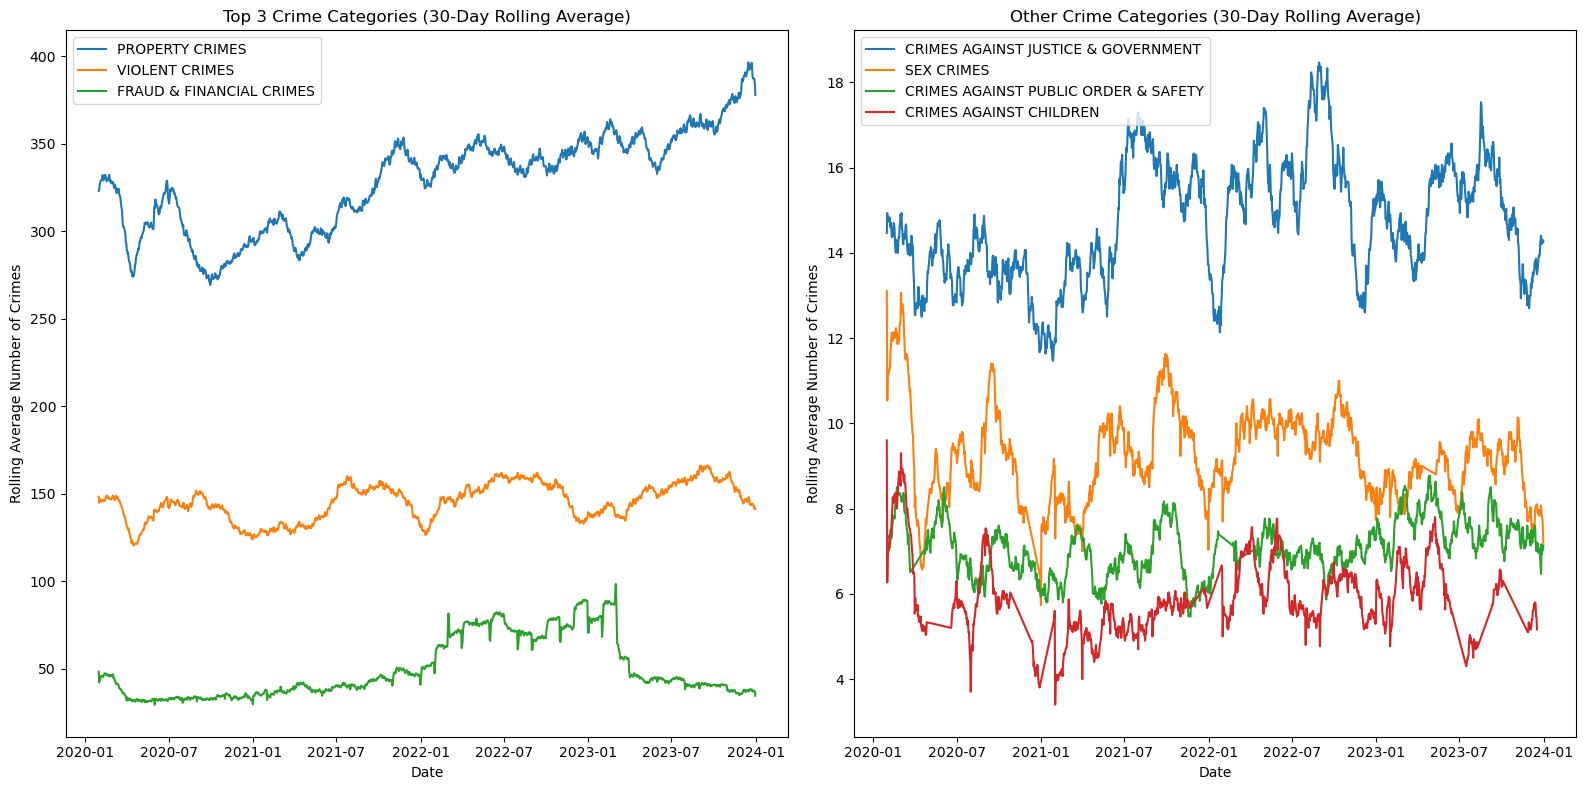

In [33]:
# Group by Date and Crime Category, and calculate rolling averages
crime_counts = data.groupby(['Date', 'Crime Category']).size().reset_index(name='Crime Count')
crime_counts_pivot = crime_counts.pivot(index='Date', columns='Crime Category', values='Crime Count')
crime_counts_rolling_avg = crime_counts_pivot.rolling(window=30).mean()

# Identify top and other crime categories
top_crimes = crime_counts_rolling_avg.sum().sort_values(ascending=False).head(3).index
other_crimes = crime_counts_rolling_avg.sum().sort_values(ascending=False).tail(4).index

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Top 3 crime categories
for column in top_crimes:
    sns.lineplot(x=crime_counts_rolling_avg.index, y=crime_counts_rolling_avg[column], ax=axes[0], label=column)

axes[0].set_title('Top 3 Crime Categories (30-Day Rolling Average)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Rolling Average Number of Crimes')
axes[0].legend()

# Plot other crime categories
for column in other_crimes:
    sns.lineplot(x=crime_counts_rolling_avg.index, y=crime_counts_rolling_avg[column], ax=axes[1], label=column)

axes[1].set_title('Other Crime Categories (30-Day Rolling Average)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Rolling Average Number of Crimes')
axes[1].legend()

# Upload the entire figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Time_based/rolling_average_top_and_other_crime_categories.png'
upload_to_s3(fig, bucket, key, 'plot')

# Show the plot
plt.tight_layout()
plt.show()


### 9. **What types of Cases are being reported and by Whom?**

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/top_10_most_reported_crimes.png


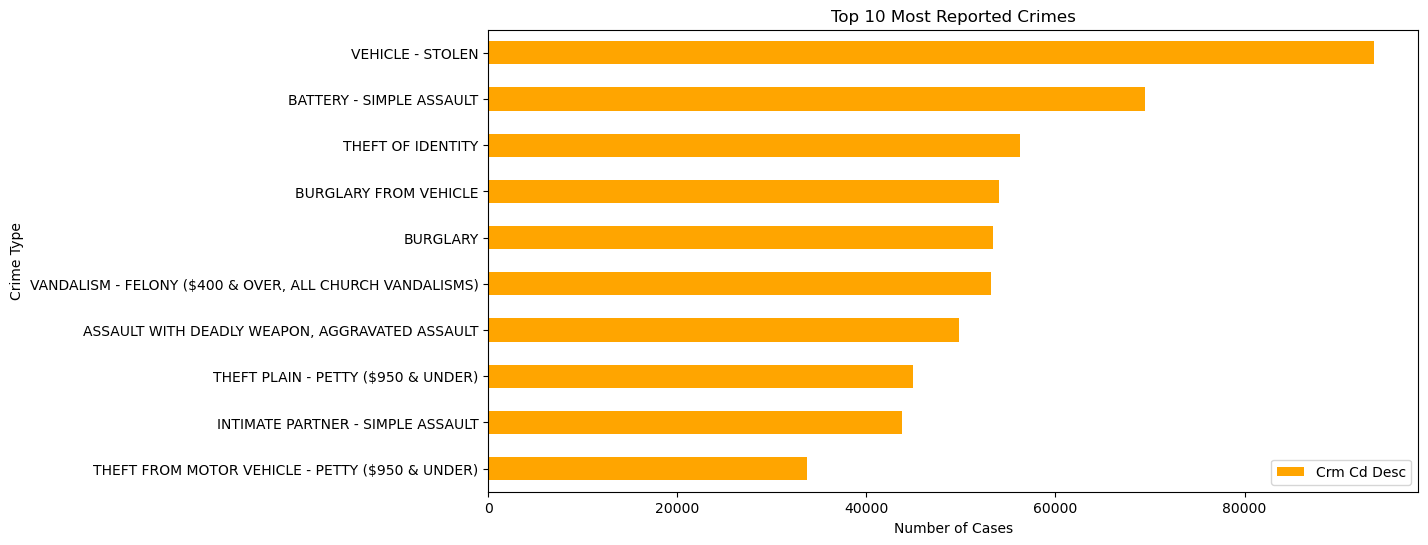

In [34]:
# Create the horizontal bar plot for top 10 crimes
fig, ax = plt.subplots(figsize=(12, 6))  # Create fig and ax
data["Crm Cd Desc"].value_counts().nlargest(10).sort_values().plot(kind="barh", color="orange", ax=ax)
ax.set_title("Top 10 Most Reported Crimes")
ax.set_xlabel("Number of Cases")
ax.set_ylabel("Crime Type")
ax.legend()

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/top_10_most_reported_crimes.png'
upload_to_s3(fig, bucket, key, 'plot')
plt.show()


### 10. How is the distribution of crime victims by sex changing across different years?


In [35]:
data['Vict Sex'].value_counts()

M    360676
F    322438
X    194097
H        97
Name: Vict Sex, dtype: int64

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_distribution_by_sex_2020.png


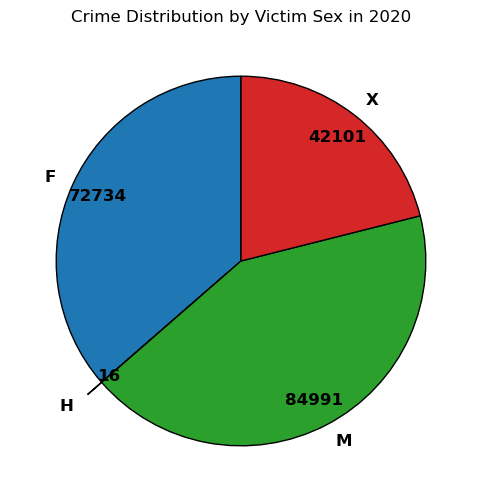

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_distribution_by_sex_2021.png


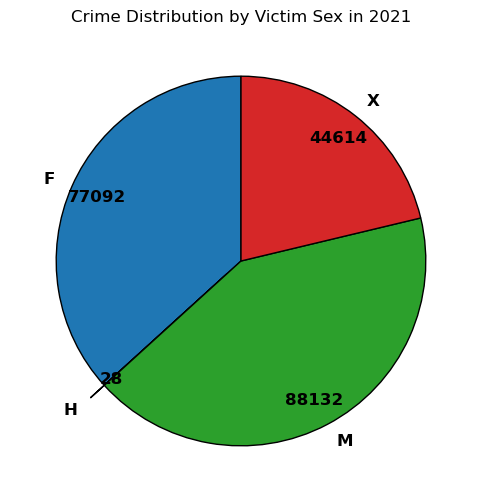

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_distribution_by_sex_2022.png


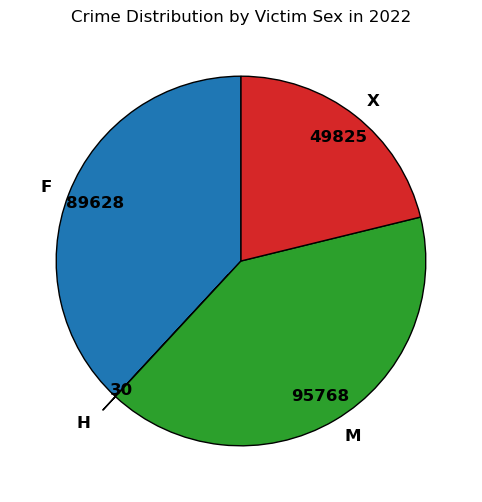

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_distribution_by_sex_2023.png


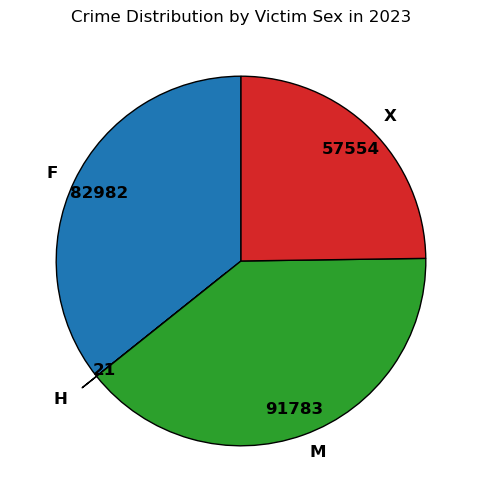

In [36]:
# Group crimes by Year and Victim Sex
crime_by_year_sex = data.groupby(['Year', 'Vict Sex']).size().unstack(fill_value=0)

for year in crime_by_year_sex.index:
    # Create fig and ax
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'Crime Distribution by Victim Sex in {year}')

    # Get values for the specific year and drop NaN values
    values = crime_by_year_sex.loc[year].dropna()

    # Create explode list: explode smaller sections
    explode = [0.1 if value == min(values) else 0 for value in values]

    # Define the autopct function
    autopct_func = lambda pct, total: f'{int(pct * total / 100)}' if pct * total / 100 else '0'

    # Plot pie chart
    values.plot.pie(
        ax=ax,
        autopct=lambda pct: autopct_func(pct, values.sum()),
        startangle=90,
        explode=explode,
        labels=values.index,
        wedgeprops={'edgecolor': 'black'},
        pctdistance=0.85,
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    ax.set_ylabel('')  # Hide the y-axis label

    # Upload each year's figure to S3
    key = f'Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_distribution_by_sex_{year}.png'
    upload_to_s3(fig, bucket, key, 'plot')
    plt.show()


## Feature Engineering Part 2: Defining Crime Severity

We created a new feature `Crime Severity` by mapping the 'Part 1-2' classification into two intuitive categories: 'Serious' and 'Less Serious'.  
This transformation simplifies the crime hierarchy and enables more focused analysis between major and minor offenses.


In [37]:
#Define Crime Severity
data['Crime Severity'] = data['Part 1-2'].map({1: 'Serious', 2: 'Less Serious'})


### 11. Are the age distributions of victims in serious and less serious crimes normally distributed?

In [38]:
# Group data by 'Crime Severity'
serious_age_data = data[data['Crime Severity'] == 'Serious']['Vict Age']
less_serious_age_data = data[data['Crime Severity'] == 'Less Serious']['Vict Age']

# Perform Shapiro-Wilk test to check normality for both groups
serious_normality = stats.shapiro(serious_age_data)
less_serious_normality = stats.shapiro(less_serious_age_data)

print(f"Shapiro-Wilk Test for Serious Crime: p-value = {serious_normality[1]}")
print(f"Shapiro-Wilk Test for Less Serious Crime: p-value = {less_serious_normality[1]}")



Shapiro-Wilk Test for Serious Crime: p-value = 2.027789167719988e-144
Shapiro-Wilk Test for Less Serious Crime: p-value = 8.679937326039885e-100


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 514854.
  res = hypotest_fun_out(*samples, **kwds)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 362454.
  res = hypotest_fun_out(*samples, **kwds)


Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/victim_age_vs_crime_severity.png


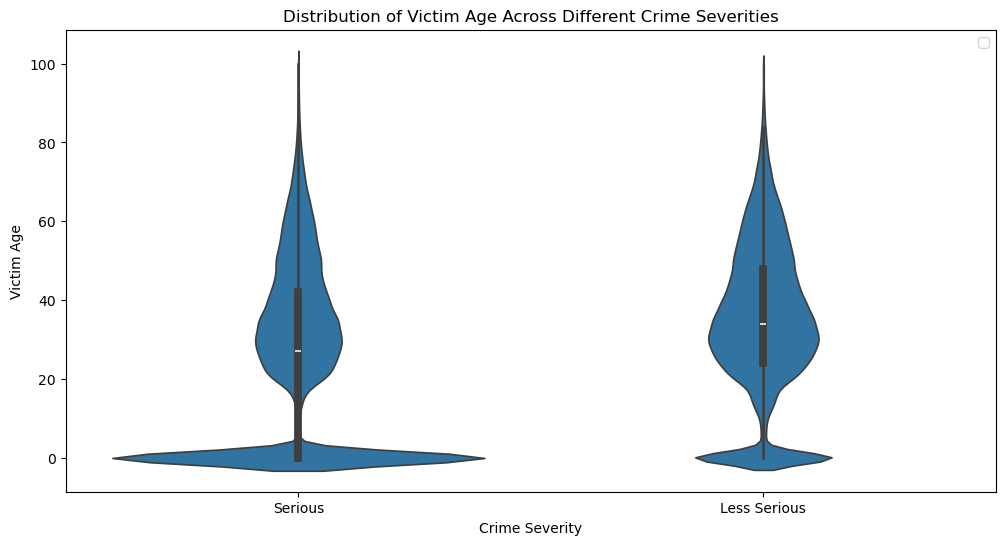

In [39]:
# Step 3: Visualize the relationship using a Violin Plot
fig, ax = plt.subplots(figsize=(12, 6))  # Create fig and ax
sns.violinplot(x='Crime Severity', y='Vict Age', data=data, ax=ax)
ax.set_title('Distribution of Victim Age Across Different Crime Severities')
ax.set_xlabel('Crime Severity')
ax.set_ylabel('Victim Age')
ax.legend()

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/victim_age_vs_crime_severity.png'
upload_to_s3(fig, bucket, key, 'plot')
plt.show()


In [40]:
# Perform Mann-Whitney U test (non-parametric test)
u_stat, p_val = stats.mannwhitneyu(serious_age_data, less_serious_age_data)
print(f"Mann-Whitney U Test Result: U-statistic = {u_stat}, p-value = {p_val}")

if p_val < 0.05:
  print("There is a significant difference in victim age between Serious and Less Serious crimes (p < 0.05).")
else:
  print("There is no significant difference in victim age between Serious and Less Serious crimes (p >= 0.05).")

Mann-Whitney U Test Result: U-statistic = 72300206277.0, p-value = 0.0
There is a significant difference in victim age between Serious and Less Serious crimes (p < 0.05).


In [41]:
pd.set_option('display.max_rows', None)
data['Crm Cd Desc'].value_counts()

VEHICLE - STOLEN                                            93673
BATTERY - SIMPLE ASSAULT                                    69421
THEFT OF IDENTITY                                           56216
BURGLARY FROM VEHICLE                                       53990
BURGLARY                                                    53411
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     53140
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              49828
THEFT PLAIN - PETTY ($950 & UNDER)                          44899
INTIMATE PARTNER - SIMPLE ASSAULT                           43716
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             33698
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)         31318
ROBBERY                                                     29813
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    29145
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                    22988
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                    21851
CRIMINAL T

In [42]:
data = data.dropna(subset=['Vict Descent', 'Crime Category'])

### 12. How are different crime categories distributed across various victim descent groups?

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_category_across_victim_descent.png


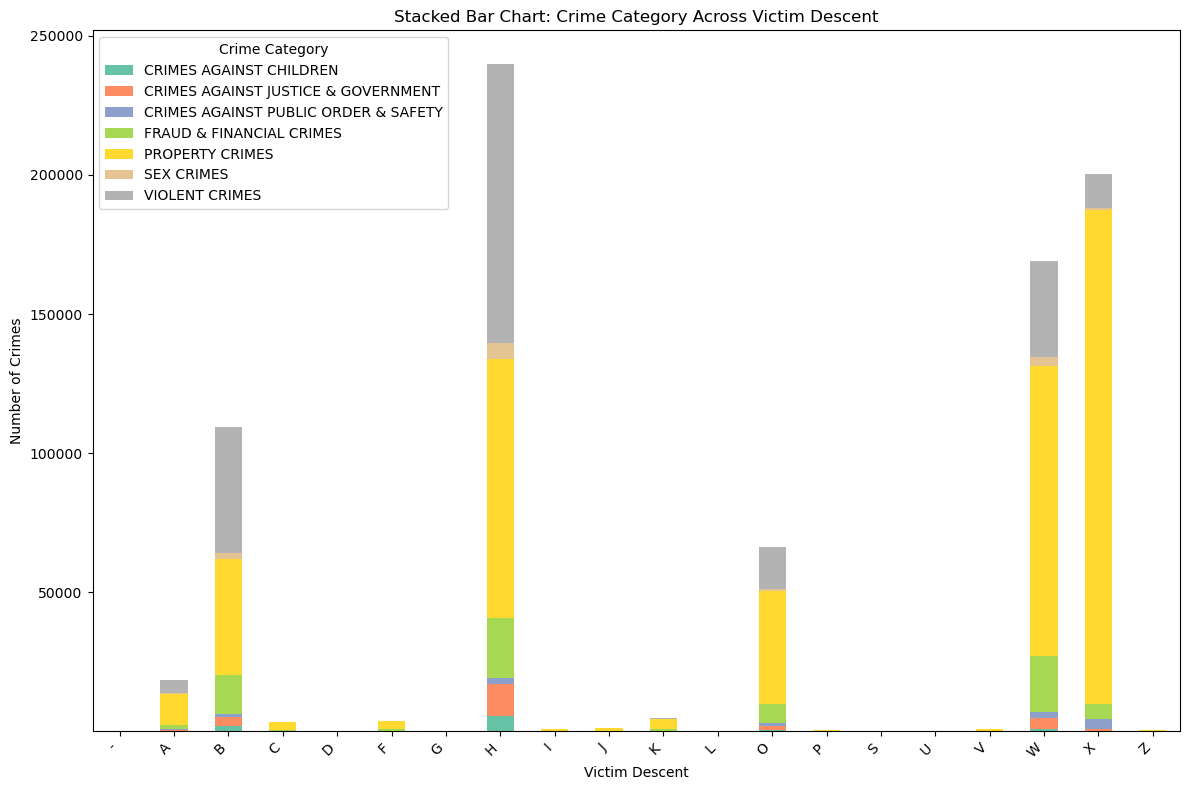

In [43]:
# Create a contingency table (cross-tabulation) of Victim Descent and Crime Category
contingency_table = pd.crosstab(data['Vict Descent'], data['Crime Category'])

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Create fig and ax

# Plot the stacked bar chart
contingency_table.plot(kind='bar', stacked=True, colormap="Set2", ax=ax)
ax.set_title('Stacked Bar Chart: Crime Category Across Victim Descent')
ax.set_xlabel('Victim Descent')
ax.set_ylabel('Number of Crimes')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Crime Category')

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_category_across_victim_descent.png'
upload_to_s3(fig, bucket, key, 'plot')
plt.tight_layout()
plt.show()


## Feature Engineering Part 3: Simplifying Victim Descent Categories

To enable clearer analysis, we mapped the detailed victim descent codes into broader and more interpretable categories: 'White', 'Black', 'Hispanic', 'Asian', and 'Other'.  
This simplification helps reduce noise, ensures consistency, and makes demographic analysis more meaningful by grouping smaller or ambiguous descent codes under larger umbrella groups.


In [44]:
def map_descent(desc):
    if desc == 'W':  # White
        return 'White'
    elif desc == 'B':  # Black
        return 'Black'
    elif desc == 'H':  # Hispanic/Latin/Mexican
        return 'Hispanic'
    elif desc in ['A', 'C', 'D', 'F', 'G', 'I', 'J', 'K', 'L', 'P', 'S', 'U', 'V', 'Z']:  # Asian-related descents
        return 'Asian'
    else:  # Everything else (including Unknown)
        return 'Other'

data['Simplified Vict Descent'] = data['Vict Descent'].apply(map_descent)
print(data['Simplified Vict Descent'].value_counts())


Other       266568
Hispanic    240018
White       169090
Black       109214
Asian        34125
Name: Simplified Vict Descent, dtype: int64


### 12. How are different crime categories distributed across simplified victim descent groups?

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_category_across_simplified_victim_descent.png


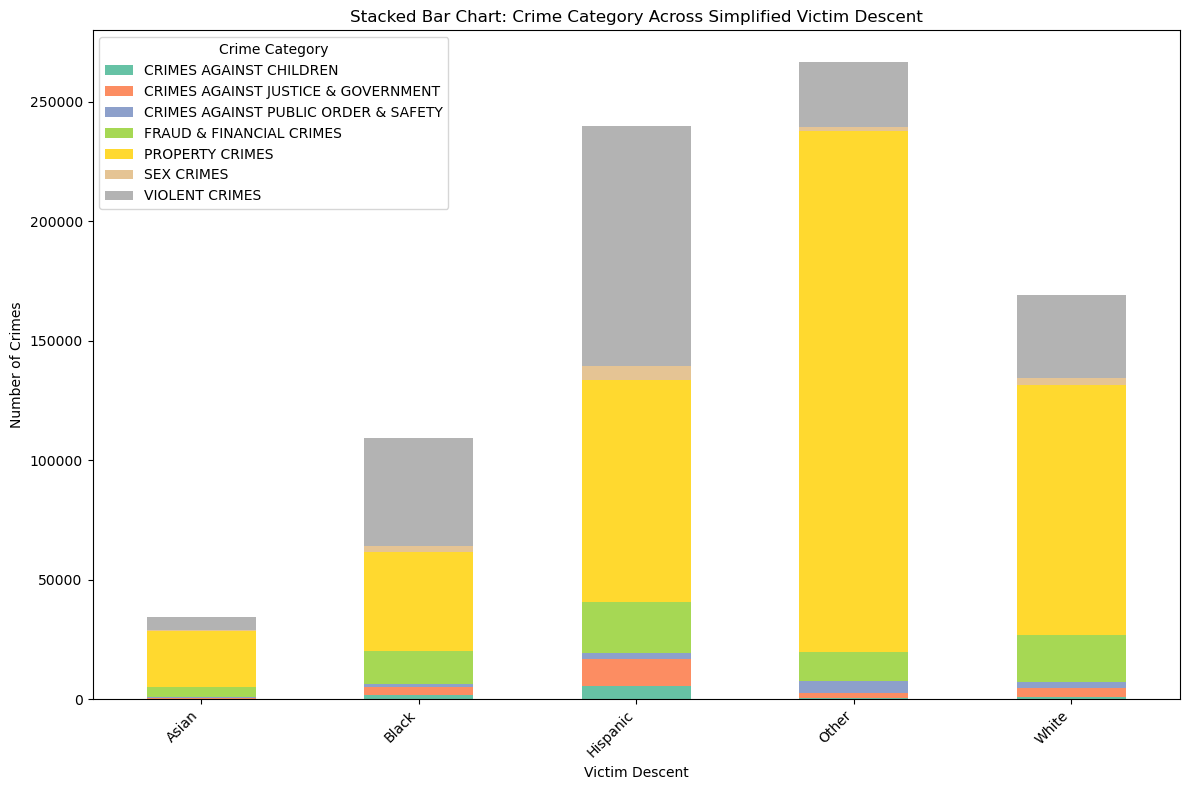

In [45]:
# Create a contingency table (cross-tabulation) using Simplified Victim Descent
contingency_table = pd.crosstab(data['Simplified Vict Descent'], data['Crime Category'])

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Create fig and ax

# Plot the stacked bar chart
contingency_table.plot(kind='bar', stacked=True, colormap="Set2", ax=ax)
ax.set_title('Stacked Bar Chart: Crime Category Across Simplified Victim Descent')
ax.set_xlabel('Victim Descent')
ax.set_ylabel('Number of Crimes')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Crime Category')

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_category_across_simplified_victim_descent.png'
upload_to_s3(fig, bucket, key, 'plot')

# Optionally show the plot
plt.tight_layout()
plt.show()


In [46]:
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

# Step 3: Print the Chi-square test results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies Table: \n{expected}")
print(f"P-Value: {p_val}")

# Step 4: Interpretation of the p-value
if p_val < 0.05:
    print("There is a significant association between Victim Descent and Crime Category (p < 0.05).")
else:
    print("There is no significant association between Victim Descent and Crime Category (p >= 0.05).")

Chi-Square Statistic: 139365.95468782078
Degrees of Freedom: 24
Expected Frequencies Table: 
[[   352.8268713     895.15027197    429.86712698   2998.69507884
   20034.75806304    561.78137763   8851.92121023]
 [  1129.19073765   2864.84811145   1375.75116207   9597.05448618
   64119.44518965   1797.93088283  28329.77943017]
 [  2481.6058607    6296.03451951   3023.46807568  21091.30536071
  140914.3607553    3951.28623285  62259.93919525]
 [  2756.11292101   6992.48110474   3357.91414809  23424.35603744
  156501.8428527    4388.36449149  69146.92844453]
 [  1748.26360934   4435.48599232   2129.99948719  14858.58903683
   99272.59313932   2783.6370152   43861.43171981]]
P-Value: 0.0
There is a significant association between Victim Descent and Crime Category (p < 0.05).


In [47]:
data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LOCATION,LAT,LON,Year,Month,Hour,DayOfWeek,Quarter,Weekend,Date,WeekType,Crime Category,Crime Severity,Simplified Vict Descent
0,190326475,03/01/2020 12:00:00 AM,2020-03-01,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,0344,0.0,M,O,101.0,STREET,Weapon Usage Not Known,Unknown,AA,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506,2020,3,21,6,1,Weekend,2020-03-01,Weekend,PROPERTY CRIMES,Serious,Other
1,200106753,02/09/2020 12:00:00 AM,2020-02-08,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47.0,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),Weapon Usage Not Known,Unknown,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020,2,18,5,1,Weekend,2020-02-08,Weekend,PROPERTY CRIMES,Serious,Other
2,200320258,11/11/2020 12:00:00 AM,2020-11-04,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19.0,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Weapon Usage Not Known,Unknown,IC,Invest Cont,1400 W 37TH ST,34.0210,-118.3002,2020,11,17,2,4,Weekday,2020-11-04,Weekday,PROPERTY CRIMES,Serious,Other
3,200907217,05/10/2023 12:00:00 AM,2020-03-10,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19.0,M,O,405.0,CLOTHING STORE,Weapon Usage Not Known,Unknown,IC,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387,2020,3,20,1,1,Weekday,2020-03-10,Weekday,PROPERTY CRIMES,Serious,Other
4,200412582,09/09/2020 12:00:00 AM,2020-09-09,0630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,0344,0.0,X,X,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,200 E AVENUE 28,34.0820,-118.2130,2020,9,6,2,3,Weekday,2020-09-09,Weekday,PROPERTY CRIMES,Serious,Other


## Feature Engineering Part 4: IsHoliday
As part of feature engineering, we extracted new date-related features (Year, Month, Day of Week) and identified U.S. public holidays using the `holidays` Python library, allowing us to capture potential variations in crime patterns during holidays.

In [48]:
!pip install holidays
import holidays
data['Date'] = pd.to_datetime(data['Date'])
# Step 1: Extract useful date features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Check for holidays (using the 'holidays' library for USA)
us_holidays = holidays.US(years=[2020,2021,2022,2023])  # Adjust years and countries as needed
data['IsHoliday'] = data['Date'].isin(us_holidays.keys())  # This will be a boolean column

data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LOCATION,LAT,LON,Year,Month,Hour,DayOfWeek,Quarter,Weekend,Date,WeekType,Crime Category,Crime Severity,Simplified Vict Descent,IsHoliday
0,190326475,03/01/2020 12:00:00 AM,2020-03-01,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,0344,0.0,M,O,101.0,STREET,Weapon Usage Not Known,Unknown,AA,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506,2020,3,21,6,1,Weekend,2020-03-01,Weekend,PROPERTY CRIMES,Serious,Other,False
1,200106753,02/09/2020 12:00:00 AM,2020-02-08,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47.0,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),Weapon Usage Not Known,Unknown,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020,2,18,5,1,Weekend,2020-02-08,Weekend,PROPERTY CRIMES,Serious,Other,False
2,200320258,11/11/2020 12:00:00 AM,2020-11-04,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19.0,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Weapon Usage Not Known,Unknown,IC,Invest Cont,1400 W 37TH ST,34.0210,-118.3002,2020,11,17,2,4,Weekday,2020-11-04,Weekday,PROPERTY CRIMES,Serious,Other,False
3,200907217,05/10/2023 12:00:00 AM,2020-03-10,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19.0,M,O,405.0,CLOTHING STORE,Weapon Usage Not Known,Unknown,IC,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387,2020,3,20,1,1,Weekday,2020-03-10,Weekday,PROPERTY CRIMES,Serious,Other,False
4,200412582,09/09/2020 12:00:00 AM,2020-09-09,0630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,0344,0.0,X,X,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,200 E AVENUE 28,34.0820,-118.2130,2020,9,6,2,3,Weekday,2020-09-09,Weekday,PROPERTY CRIMES,Serious,Other,False


In [49]:
data['IsWeekendorHoliday'] = (data['WeekType'] == 'Weekend') | (data['IsHoliday'] == True)
data.head()



,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LOCATION,LAT,LON,Year,Month,Hour,DayOfWeek,Quarter,Weekend,Date,WeekType,Crime Category,Crime Severity,Simplified Vict Descent,IsHoliday,IsWeekendorHoliday
0,190326475,03/01/2020 12:00:00 AM,2020-03-01,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,0344,0.0,M,O,101.0,STREET,Weapon Usage Not Known,Unknown,AA,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506,2020,3,21,6,1,Weekend,2020-03-01,Weekend,PROPERTY CRIMES,Serious,Other,False,True
1,200106753,02/09/2020 12:00:00 AM,2020-02-08,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47.0,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),Weapon Usage Not Known,Unknown,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020,2,18,5,1,Weekend,2020-02-08,Weekend,PROPERTY CRIMES,Serious,Other,False,True
2,200320258,11/11/2020 12:00:00 AM,2020-11-04,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19.0,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Weapon Usage Not Known,Unknown,IC,Invest Cont,1400 W 37TH ST,34.0210,-118.3002,2020,11,17,2,4,Weekday,2020-11-04,Weekday,PROPERTY CRIMES,Serious,Other,False,False
3,200907217,05/10/2023 12:00:00 AM,2020-03-10,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19.0,M,O,405.0,CLOTHING STORE,Weapon Usage Not Known,Unknown,IC,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387,2020,3,20,1,1,Weekday,2020-03-10,Weekday,PROPERTY CRIMES,Serious,Other,False,False
4,200412582,09/09/2020 12:00:00 AM,2020-09-09,0630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,0344,0.0,X,X,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,200 E AVENUE 28,34.0820,-118.2130,2020,9,6,2,3,Weekday,2020-09-09,Weekday,PROPERTY CRIMES,Serious,Other,False,False


### 13. How does the proportion of crimes committed on weekends and holidays compare to weekdays over different years, and how does this align with the overall distribution of weekends, holidays, and weekdays in the calendar?

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_and_holiday_distribution_by_year.png


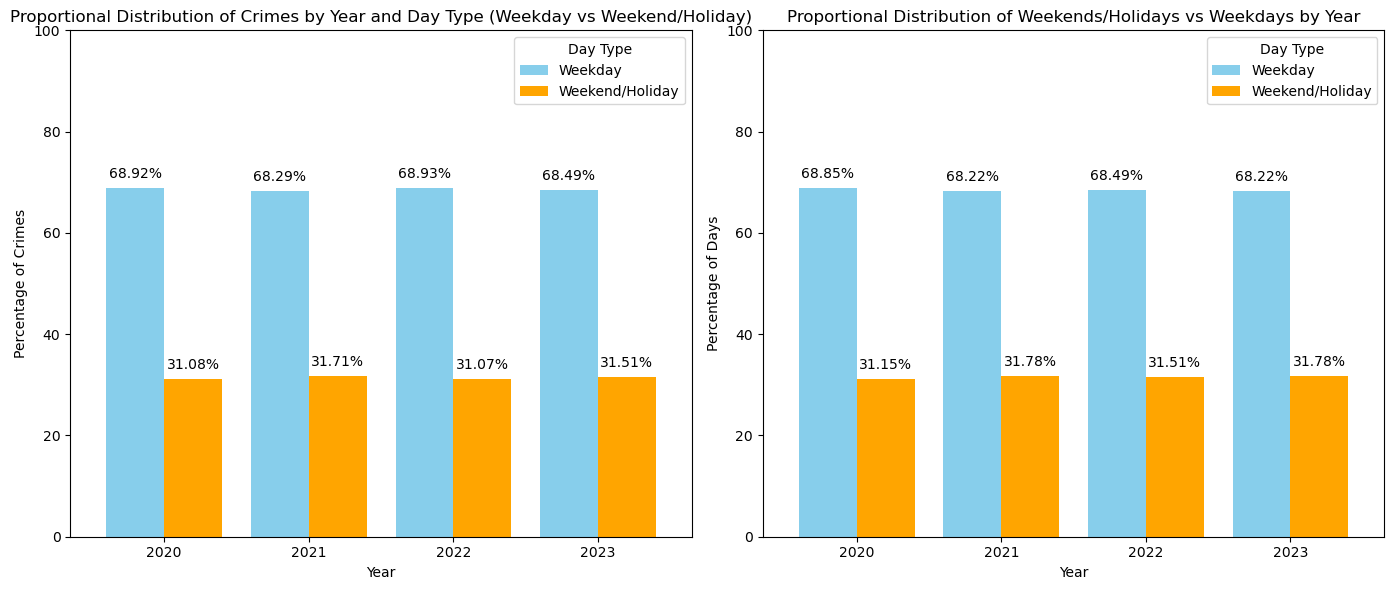

In [50]:
# Calculate crime distribution
crime_distribution_counts = data.groupby(['Year', 'IsWeekendorHoliday'])['IsWeekendorHoliday'].count().unstack()

# Calculate proportions for crimes
crime_distribution_percentage = crime_distribution_counts.div(crime_distribution_counts.sum(axis=1), axis=0) * 100

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot percentage of crimes by year and day type
crime_distribution_percentage.plot(kind='bar', ax=ax1, color=['skyblue', 'orange'], width=0.8)
ax1.set_title('Proportional Distribution of Crimes by Year and Day Type (Weekday vs Weekend/Holiday)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Percentage of Crimes')
ax1.legend(title='Day Type', labels=['Weekday', 'Weekend/Holiday'])
ax1.set_xticklabels(crime_distribution_percentage.index, rotation=0)
ax1.set_ylim(0, 100)

# Annotate crime bars
for p in ax1.patches:
    height = p.get_height()
    if height > 0:
        ax1.annotate(f'{height:.2f}%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 10),
                     textcoords='offset points',
                     ha='center', va='center', fontsize=10)

# Calculate holiday distribution
holiday_distribution = data.drop_duplicates(subset=['Date'])
holiday_distribution = holiday_distribution.groupby(['Year', 'IsWeekendorHoliday']).size().unstack()
holiday_distribution_percentage = holiday_distribution.div(holiday_distribution.sum(axis=1), axis=0) * 100

# Plot holiday distribution by year and day type
holiday_distribution_percentage.plot(kind='bar', ax=ax2, color=['skyblue', 'orange'], width=0.8)
ax2.set_title('Proportional Distribution of Weekends/Holidays vs Weekdays by Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Percentage of Days')
ax2.legend(title='Day Type', labels=['Weekday', 'Weekend/Holiday'])
ax2.set_xticklabels(holiday_distribution_percentage.index, rotation=0)
ax2.set_ylim(0, 100)

# Annotate holiday bars
for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        ax2.annotate(f'{height:.2f}%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 10),
                     textcoords='offset points',
                     ha='center', va='center', fontsize=10)

# Upload the full figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Crime_Types_and_Demographics/crime_and_holiday_distribution_by_year.png'
upload_to_s3(fig, bucket, key, 'plot')

# Final layout and display
plt.tight_layout()
plt.show()

In [51]:
data.shape

(819015, 36)

In [52]:
weekend_or_holiday_data = data[data['IsWeekendorHoliday'] == True]
weekday_data = data[data['IsWeekendorHoliday'] == False]

# Shapiro-Wilk test for normality
shapiro_weekday = stats.shapiro(weekday_data['Crm Cd'])  
shapiro_weekend = stats.shapiro(weekend_or_holiday_data['Crm Cd'])  # Same here

print(f"Shapiro-Wilk Test for Weekday Crimes: {shapiro_weekday}")
print(f"Shapiro-Wilk Test for Weekend/Holiday Crimes: {shapiro_weekend}")





Shapiro-Wilk Test for Weekday Crimes: ShapiroResult(statistic=0.937551007418269, pvalue=2.3865504068455776e-131)
Shapiro-Wilk Test for Weekend/Holiday Crimes: ShapiroResult(statistic=0.9472168810539098, pvalue=2.017952534266365e-113)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 562314.
  res = hypotest_fun_out(*samples, **kwds)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 256701.
  res = hypotest_fun_out(*samples, **kwds)


In [53]:
# Data is not normally distributed, apply Mann-Whitney U test
mannwhitney_stat, mannwhitney_p = stats.mannwhitneyu(weekday_data['Crm Cd'], weekend_or_holiday_data['Crm Cd'])
print(f"Mann-Whitney U test results: U-statistic = {mannwhitney_stat}, p-value = {mannwhitney_p}")
if mannwhitney_p < 0.05:
    print("There is a significant difference in the number of crimes between weekdays and weekends/holidays (p < 0.05).")
else:
    print("There is no significant difference in the number of crimes between weekdays and weekends/holidays (p >= 0.05).")

Mann-Whitney U test results: U-statistic = 71635158203.0, p-value = 5.5700803698865494e-08
There is a significant difference in the number of crimes between weekdays and weekends/holidays (p < 0.05).


In [54]:
data['AREA NAME']=data['AREA NAME'].str.upper()
data.head(5)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LOCATION,LAT,LON,Year,Month,Hour,DayOfWeek,Quarter,Weekend,Date,WeekType,Crime Category,Crime Severity,Simplified Vict Descent,IsHoliday,IsWeekendorHoliday
0,190326475,03/01/2020 12:00:00 AM,2020-03-01,2130,7,WILSHIRE,784,1,510,VEHICLE - STOLEN,0344,0.0,M,O,101.0,STREET,Weapon Usage Not Known,Unknown,AA,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506,2020,3,21,6,1,Weekend,2020-03-01,Weekend,PROPERTY CRIMES,Serious,Other,False,True
1,200106753,02/09/2020 12:00:00 AM,2020-02-08,1800,1,CENTRAL,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47.0,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),Weapon Usage Not Known,Unknown,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020,2,18,5,1,Weekend,2020-02-08,Weekend,PROPERTY CRIMES,Serious,Other,False,True
2,200320258,11/11/2020 12:00:00 AM,2020-11-04,1700,3,SOUTHWEST,356,1,480,BIKE - STOLEN,0344 1251,19.0,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Weapon Usage Not Known,Unknown,IC,Invest Cont,1400 W 37TH ST,34.0210,-118.3002,2020,11,17,2,4,Weekday,2020-11-04,Weekday,PROPERTY CRIMES,Serious,Other,False,False
3,200907217,05/10/2023 12:00:00 AM,2020-03-10,2037,9,VAN NUYS,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19.0,M,O,405.0,CLOTHING STORE,Weapon Usage Not Known,Unknown,IC,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387,2020,3,20,1,1,Weekday,2020-03-10,Weekday,PROPERTY CRIMES,Serious,Other,False,False
4,200412582,09/09/2020 12:00:00 AM,2020-09-09,0630,4,HOLLENBECK,413,1,510,VEHICLE - STOLEN,0344,0.0,X,X,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,200 E AVENUE 28,34.0820,-118.2130,2020,9,6,2,3,Weekday,2020-09-09,Weekday,PROPERTY CRIMES,Serious,Other,False,False


# Spatio-temporal-based Anomaly/Crime HotSpot Detection

In [55]:
import tempfile
import geopandas as gpd
import os
# S3 settings
bucket = 'finalproject-mlc'
prefix = 'Law_Enforcement_Reporting_Districts'  # without extension

extensions = ['shp', 'shx', 'dbf', 'prj', 'cpg']  # use only what exists

# Download all shapefile parts to temp directory
s3 = boto3.client('s3')
with tempfile.TemporaryDirectory() as tmpdir:
    for ext in extensions:
        key = f"{prefix}.{ext}"
        local_path = os.path.join(tmpdir, f"Law_Enforcement_Reporting_Districts.{ext}")
        s3.download_file(bucket, key, local_path)
        print(f"Downloaded: {key}")

    # Load into GeoDataFrame
    shp_path = os.path.join(tmpdir, "Law_Enforcement_Reporting_Districts.shp")
    geo_df = gpd.read_file(shp_path)

# Done — now you can work with geo_df
print(geo_df.head())





Downloaded: Law_Enforcement_Reporting_Districts.shp
Downloaded: Law_Enforcement_Reporting_Districts.shx
Downloaded: Law_Enforcement_Reporting_Districts.dbf
Downloaded: Law_Enforcement_Reporting_Districts.prj
Downloaded: Law_Enforcement_Reporting_Districts.cpg
   OBJECTID    RD  S_TYPE COMMTYPE           NAME        ST_NAME  \
0         1  None  Police     City       Whittier       Whittier   
1         2  ????  Police     City       Monrovia       Monrovia   
2         3  ????  Police     City  Monterey Park  Monterey Park   
3         4   001  Police     City        Burbank        Burbank   
4         5   001  Police     City         Covina         Covina   

           OMEGA_LABE                 LABEL AGENCY STATION  \
0            Whittier       Whittier Police  OTHER    None   
1       Monrovia ????       Monrovia Police  OTHER    None   
2  Monterey Park ????  Monterey Park Police  OTHER    None   
3         Burbank 001        Burbank Police  OTHER    None   
4          Covina 001

### 14. How are crimes geographically distributed across different police reporting districts in Los Angeles?

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Spatial/crime_count_distribution_by_reporting_district.png


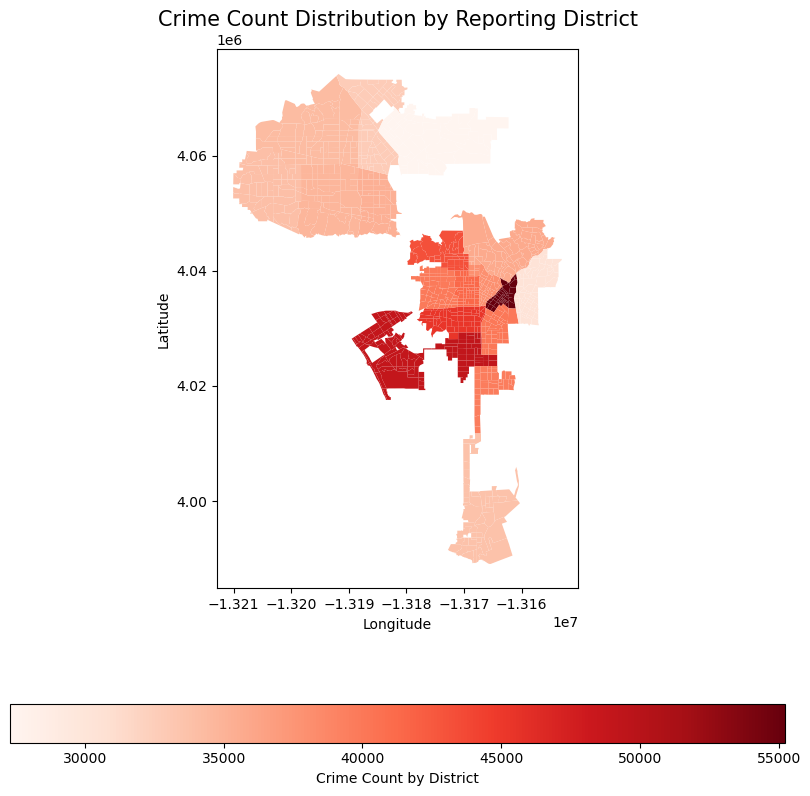

In [56]:
# Prepare the geo data
geo_data = geo_df.dropna()
crime_counts = data['AREA NAME'].value_counts().reset_index()
crime_counts.columns = ['AREA NAME', 'Crime Count']

# Merge spatial and crime data
merged_data = geo_data.merge(crime_counts, left_on='STATION', right_on='AREA NAME', how='right')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot crime count distribution
merged_data.plot(column='Crime Count', ax=ax, legend=True, cmap='Reds',
                 legend_kwds={'label': "Crime Count by District", 'orientation': "horizontal"})
ax.set_title("Crime Count Distribution by Reporting District", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Spatial/crime_count_distribution_by_reporting_district.png'
upload_to_s3(fig, bucket, key, 'plot')

# Show the plot
plt.show()


In [57]:
data.shape

(819015, 36)

In [58]:
crime_category_counts = data.groupby(['AREA NAME', 'Crime Category']).size().sort_values(ascending=False).reset_index(name='CrimeCount')
crime_category_counts.head()


,AREA NAME,Crime Category,CrimeCount
0,CENTRAL,PROPERTY CRIMES,34154
1,PACIFIC,PROPERTY CRIMES,33998
2,WEST LA,PROPERTY CRIMES,26890
3,N HOLLYWOOD,PROPERTY CRIMES,26190
4,HOLLYWOOD,PROPERTY CRIMES,25823


### 15. Which district has the highest number of crimes for each major crime category?

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/EDA/Spatial/top_district_per_crime_category.png


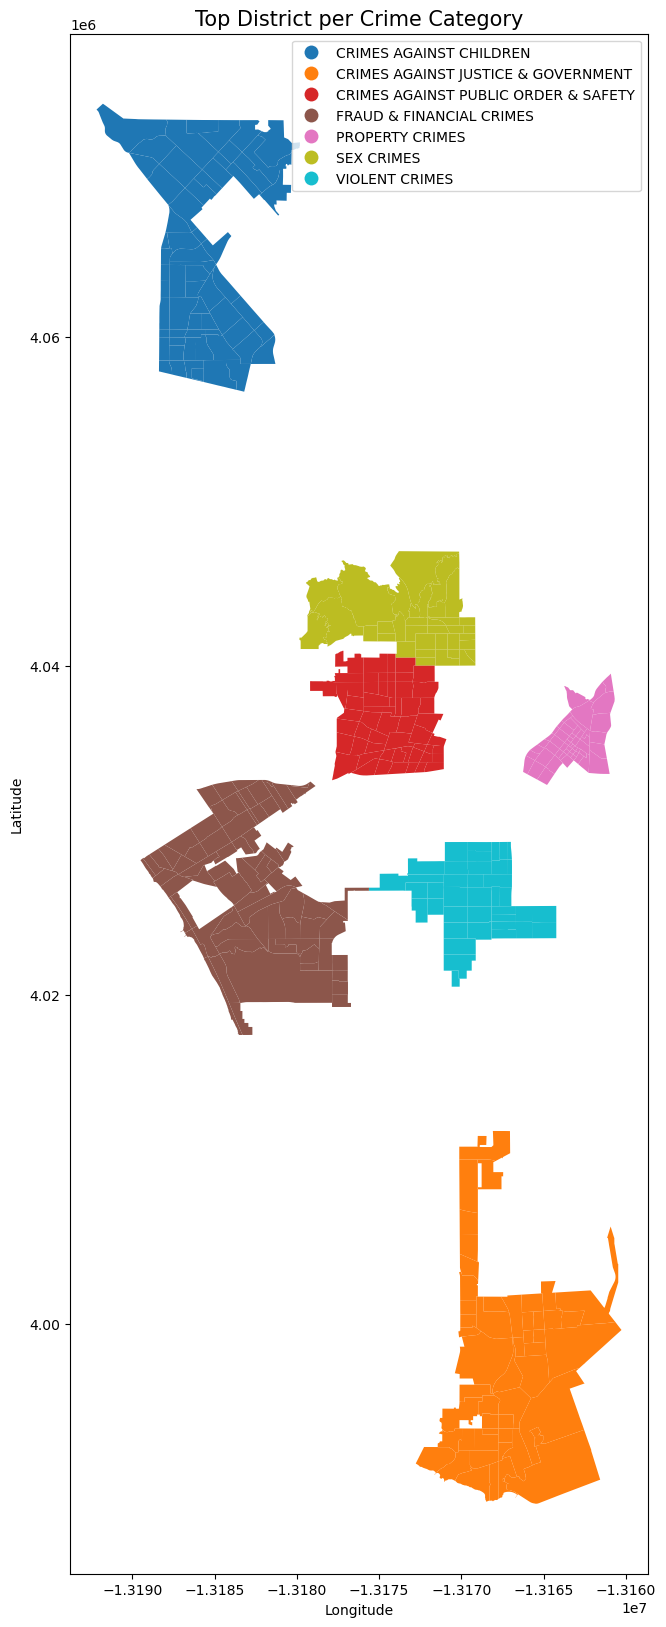

In [59]:
# Select top district for each crime category without repetition
used_areas = set()
used_categories = set()
final_rows = pd.DataFrame(columns=crime_category_counts.columns)

for i in range(len(crime_category_counts)):
    row = crime_category_counts.loc[i]
    area = row['AREA NAME']
    category = row['Crime Category']

    if category not in used_categories and area not in used_areas:
        next_index = len(final_rows)
        final_rows.at[next_index, 'AREA NAME'] = area
        final_rows.at[next_index, 'Crime Category'] = category
        final_rows.at[next_index, 'CrimeCount'] = row['CrimeCount']
        
        used_categories.add(category)
        used_areas.add(area)

    if len(used_categories) == crime_category_counts['Crime Category'].nunique():
        break

final_rows = final_rows.reset_index(drop=True)

# Merge with geo data
merged_data = geo_data.merge(final_rows, left_on='STATION', right_on='AREA NAME', how='right')

# Create figure and plot
fig, ax = plt.subplots(figsize=(20, 20))
merged_data.plot(column='Crime Category', ax=ax, legend=True)
ax.set_title("Top District per Crime Category", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Upload the figure to S3
key = 'Crime_Hotspot_Prediction/EDA/Spatial/top_district_per_crime_category.png'
upload_to_s3(fig, bucket, key, 'plot')

# Show the plot
plt.show()


## Feature Engineering Part 5: Lagging and  Additional 3rd party features
In this section we will try and see if Traditional Tree based models and some neural networks can be useful in hotspot or anomoly detection.
But first, let's create some additional feature to aid our model

In [60]:
data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LOCATION,LAT,LON,Year,Month,Hour,DayOfWeek,Quarter,Weekend,Date,WeekType,Crime Category,Crime Severity,Simplified Vict Descent,IsHoliday,IsWeekendorHoliday
0,190326475,03/01/2020 12:00:00 AM,2020-03-01,2130,7,WILSHIRE,784,1,510,VEHICLE - STOLEN,0344,0.0,M,O,101.0,STREET,Weapon Usage Not Known,Unknown,AA,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506,2020,3,21,6,1,Weekend,2020-03-01,Weekend,PROPERTY CRIMES,Serious,Other,False,True
1,200106753,02/09/2020 12:00:00 AM,2020-02-08,1800,1,CENTRAL,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47.0,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),Weapon Usage Not Known,Unknown,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020,2,18,5,1,Weekend,2020-02-08,Weekend,PROPERTY CRIMES,Serious,Other,False,True
2,200320258,11/11/2020 12:00:00 AM,2020-11-04,1700,3,SOUTHWEST,356,1,480,BIKE - STOLEN,0344 1251,19.0,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Weapon Usage Not Known,Unknown,IC,Invest Cont,1400 W 37TH ST,34.0210,-118.3002,2020,11,17,2,4,Weekday,2020-11-04,Weekday,PROPERTY CRIMES,Serious,Other,False,False
3,200907217,05/10/2023 12:00:00 AM,2020-03-10,2037,9,VAN NUYS,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19.0,M,O,405.0,CLOTHING STORE,Weapon Usage Not Known,Unknown,IC,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387,2020,3,20,1,1,Weekday,2020-03-10,Weekday,PROPERTY CRIMES,Serious,Other,False,False
4,200412582,09/09/2020 12:00:00 AM,2020-09-09,0630,4,HOLLENBECK,413,1,510,VEHICLE - STOLEN,0344,0.0,X,X,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,200 E AVENUE 28,34.0820,-118.2130,2020,9,6,2,3,Weekday,2020-09-09,Weekday,PROPERTY CRIMES,Serious,Other,False,False


In [61]:
data.shape

(819015, 36)

### Crime rate Feature

We extract time features and add population data by district.Then we calculate monthly, yearly, and hourly crime rates per 1000 people to find meaningful patterns.Build a year-wise population table by flattening district populations across years into a structured DataFrame. Aggregate crime counts at monthly, yearly, daily, and hourly levels grouped by district and year. Extract year from the date for daily and hourly aggregations. Merge crime aggregations with corresponding year-specific district populations on ['AREA NAME', 'Year']. Calculate crime rates per 1000 residents by dividing crime counts by the dynamically matched population values for each time granularity.




In [62]:
crime_df = data.copy() #Creating a copy for maintaining orignal state of our dataset
# Population dictionary
district_population_data = population_by_year = {
    2020: {
        'WILSHIRE': 143600, 'CENTRAL': 180700, 'SOUTHWEST': 118100, 'VAN NUYS': 163500,
        'HOLLENBECK': 136900, 'RAMPART': 139400, 'NEWTON': 108000, 'NORTHEAST': 94500,
        '77TH STREET': 105800, 'HOLLYWOOD': 130800, 'HARBOR': 135300, 'WEST VALLEY': 160400,
        'WEST LA': 130900, 'N HOLLYWOOD': 154800, 'PACIFIC': 68700, 'DEVONSHIRE': 124500,
        'MISSION': 158500, 'SOUTHEAST': 123700, 'OLYMPIC': 82000, 'FOOTHILL': 88500, 'TOPANGA': 127100
    },
    2021: {
        'WILSHIRE': 144080, 'CENTRAL': 181300, 'SOUTHWEST': 118400, 'VAN NUYS': 164300,
        'HOLLENBECK': 137400, 'RAMPART': 139900, 'NEWTON': 108500, 'NORTHEAST': 95000,
        '77TH STREET': 106400, 'HOLLYWOOD': 131500, 'HARBOR': 135800, 'WEST VALLEY': 161100,
        'WEST LA': 131500, 'N HOLLYWOOD': 155700, 'PACIFIC': 69000, 'DEVONSHIRE': 125100,
        'MISSION': 159300, 'SOUTHEAST': 124100, 'OLYMPIC': 82500, 'FOOTHILL': 89000, 'TOPANGA': 127700
    },
    2022: {
        'WILSHIRE': 144570, 'CENTRAL': 182150, 'SOUTHWEST': 118750, 'VAN NUYS': 165100,
        'HOLLENBECK': 137880, 'RAMPART': 140500, 'NEWTON': 109000, 'NORTHEAST': 95500,
        '77TH STREET': 106900, 'HOLLYWOOD': 132200, 'HARBOR': 136500, 'WEST VALLEY': 161900,
        'WEST LA': 132100, 'N HOLLYWOOD': 156500, 'PACIFIC': 69300, 'DEVONSHIRE': 125700,
        'MISSION': 160000, 'SOUTHEAST': 124500, 'OLYMPIC': 83000, 'FOOTHILL': 89500, 'TOPANGA': 128300
    },
    2023: {
        'WILSHIRE': 145320, 'CENTRAL': 182765, 'SOUTHWEST': 118940, 'VAN NUYS': 165732,
        'HOLLENBECK': 138210, 'RAMPART': 140875, 'NEWTON': 109432, 'NORTHEAST': 95678,
        '77TH STREET': 107215, 'HOLLYWOOD': 132540, 'HARBOR': 136890, 'WEST VALLEY': 162305,
        'WEST LA': 132450, 'N HOLLYWOOD': 156780, 'PACIFIC': 69540, 'DEVONSHIRE': 125890,
        'MISSION': 160432, 'SOUTHEAST': 124765, 'OLYMPIC': 83210, 'FOOTHILL': 89765, 'TOPANGA': 128540
    }
}



In [63]:
population_records = []
for year, districts in population_by_year.items():
    for district, population in districts.items():
        population_records.append({'AREA NAME': district, 'Year': year, 'Population': population})

pop_df = pd.DataFrame(population_records)

### **Monthly Crime Rate**
**Formula:** 
Monthly_Crime_Rate_per_1000 = (Monthly_Crime_Count / Population of that year) * 1000

In [64]:
# Monthly crime rate
monthly = crime_df.groupby(['AREA NAME', 'Year', 'Month']).size().reset_index(name='Monthly_Crime_Count')
monthly = monthly.merge(pop_df, on=['AREA NAME', 'Year'], how='left')
monthly['Monthly_Crime_Rate_per_1000'] = (monthly['Monthly_Crime_Count'] / monthly['Population']) * 1000
crime_df = crime_df.merge(monthly[['AREA NAME', 'Year', 'Month', 'Monthly_Crime_Rate_per_1000']],
                          on=['AREA NAME', 'Year', 'Month'], how='left')

### **Yearly Crime Rate**
**Formula:**
Yearly_Crime_Rate_per_1000 = (Yearly_Crime_Count / Population of that year) * 1000

In [65]:
# Yearly crime rate
yearly = crime_df.groupby(['AREA NAME', 'Year']).size().reset_index(name='Yearly_Crime_Count')
yearly = yearly.merge(pop_df, on=['AREA NAME', 'Year'], how='left')
yearly['Yearly_Crime_Rate_per_1000'] = (yearly['Yearly_Crime_Count'] / yearly['Population']) * 1000
crime_df = crime_df.merge(yearly[['AREA NAME', 'Year', 'Yearly_Crime_Rate_per_1000']],
                          on=['AREA NAME', 'Year'], how='left')


### Daily Crime Rate
**Formula:**  
Daily_Crime_Rate_per_1000 = (Daily Crime Count / Population of that year) * 1000

In [66]:
#Daily crime rate per district
daily = crime_df.groupby(['AREA NAME', 'Date']).size().reset_index(name='Daily_Crime_Count')
# Extract year from date to merge correctly
daily['Year'] = pd.to_datetime(daily['Date']).dt.year
daily = daily.merge(pop_df, on=['AREA NAME', 'Year'], how='left')
daily['Daily_Crime_Rate_per_1000'] = (daily['Daily_Crime_Count'] / daily['Population']) * 1000
crime_df = crime_df.merge(daily[['AREA NAME', 'Date', 'Daily_Crime_Rate_per_1000']],
                          on=['AREA NAME', 'Date'], how='left')

### Hourly Crime Rate
**Formula:**  
Hourly_Crime_Rate_per_1000 = (Hourly Crime Count / Population of that year) * 1000

In [67]:
# Hourly crime rate per district
hourly = crime_df.groupby(['AREA NAME', 'Date', 'Hour']).size().reset_index(name='Hourly_Crime_Count')
# Extract year from date to merge correctly
hourly['Year'] = pd.to_datetime(hourly['Date']).dt.year
hourly = hourly.merge(pop_df, on=['AREA NAME', 'Year'], how='left')
hourly['Hourly_Crime_Rate_per_1000'] = (hourly['Hourly_Crime_Count'] / hourly['Population']) * 1000


In [68]:
crime_df = crime_df.merge(hourly[['AREA NAME', 'Date', 'Hour', 'Hourly_Crime_Rate_per_1000']],
                          on=['AREA NAME', 'Date', 'Hour'], how='left')
crime_df.shape

(819015, 40)

In [69]:
#Lets checked if it worked
crime_df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LOCATION,LAT,LON,Year,Month,Hour,DayOfWeek,Quarter,Weekend,Date,WeekType,Crime Category,Crime Severity,Simplified Vict Descent,IsHoliday,IsWeekendorHoliday,Monthly_Crime_Rate_per_1000,Yearly_Crime_Rate_per_1000,Daily_Crime_Rate_per_1000,Hourly_Crime_Rate_per_1000
0,190326475,03/01/2020 12:00:00 AM,2020-03-01,2130,7,WILSHIRE,784,1,510,VEHICLE - STOLEN,0344,0.0,M,O,101.0,STREET,Weapon Usage Not Known,Unknown,AA,Adult Arrest,1900 S LONGWOOD AV,34.0375,-118.3506,2020,3,21,6,1,Weekend,2020-03-01,Weekend,PROPERTY CRIMES,Serious,Other,False,True,4.735376,61.511142,0.167131,0.013928
1,200106753,02/09/2020 12:00:00 AM,2020-02-08,1800,1,CENTRAL,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47.0,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),Weapon Usage Not Known,Unknown,IC,Invest Cont,1000 S FLOWER ST,34.0444,-118.2628,2020,2,18,5,1,Weekend,2020-02-08,Weekend,PROPERTY CRIMES,Serious,Other,False,True,5.904815,59.324848,0.204759,0.005534
2,200320258,11/11/2020 12:00:00 AM,2020-11-04,1700,3,SOUTHWEST,356,1,480,BIKE - STOLEN,0344 1251,19.0,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",Weapon Usage Not Known,Unknown,IC,Invest Cont,1400 W 37TH ST,34.0210,-118.3002,2020,11,17,2,4,Weekday,2020-11-04,Weekday,PROPERTY CRIMES,Serious,Other,False,False,6.765453,87.341236,0.270957,0.042337
3,200907217,05/10/2023 12:00:00 AM,2020-03-10,2037,9,VAN NUYS,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19.0,M,O,405.0,CLOTHING STORE,Weapon Usage Not Known,Unknown,IC,Invest Cont,14000 RIVERSIDE DR,34.1576,-118.4387,2020,3,20,1,1,Weekday,2020-03-10,Weekday,PROPERTY CRIMES,Serious,Other,False,False,4.330275,50.960245,0.159021,0.018349
4,200412582,09/09/2020 12:00:00 AM,2020-09-09,0630,4,HOLLENBECK,413,1,510,VEHICLE - STOLEN,0344,0.0,X,X,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,200 E AVENUE 28,34.0820,-118.2130,2020,9,6,2,3,Weekday,2020-09-09,Weekday,PROPERTY CRIMES,Serious,Other,False,False,4.214755,52.885318,0.160701,0.007305


### Detecting Hotspots at Different Time Scales
Constructing a time-specific key by combining the date and hour into a unified Datetime_Key. Identify daily crime hotspots by marking districts falling in the top 25% of daily crime rates using quantile-based thresholding. Sort the dataset chronologically within each district to maintain temporal ordering. Compute 24-hour rolling mean and rolling standard deviation of hourly crime rates per district, requiring at least 12 valid observations. Calculate the z-score by standardizing hourly crime rates against their district-specific rolling statistics, enabling dynamic anomaly detection over time.


In [70]:
# Defining Daily Hotspots--top 25% of districts in each day 
crime_df["Datetime_Key"] = crime_df["DATE OCC"].dt.floor("d") + pd.to_timedelta(crime_df["Hour"], unit="h")
crime_df["is_daily_hotspot"] = crime_df.groupby("Date")["Daily_Crime_Rate_per_1000"].transform(
    lambda x: (x > x.quantile(0.75)).astype(int)
)

# Time-based sorting for time-aware prediction later on
crime_df = crime_df.sort_values(["AREA NAME", "Datetime_Key"])

# Rolling mean & std over past 24 hours (per district)
crime_df["rolling_mean"] = (
    crime_df.groupby("AREA NAME")["Hourly_Crime_Rate_per_1000"]
    .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
)
crime_df["rolling_std"] = (
    crime_df.groupby("AREA NAME")["Hourly_Crime_Rate_per_1000"]
    .transform(lambda x: x.rolling(window=24, min_periods=12).std())
)

# Z-score computation
crime_df["z_score"] = (
    (crime_df["Hourly_Crime_Rate_per_1000"] - crime_df["rolling_mean"]) / crime_df["rolling_std"]
)




In [71]:
crime_df.shape

(819015, 45)

### Hotspot Label Creation

As part of feature engineering, we created binary hotspot indicators at hourly, monthly, and yearly levels by applying thresholding techniques such as z-score filtering and top 25% quantile selection within each time period.


In [72]:
# Define as hotspot if z-score exceeds threshold
z_threshold = 1.5
crime_df["is_hourly_hotspot"] = (crime_df["z_score"] > z_threshold).astype(int)
crime_df["Datetime_Hour_Key"] = crime_df["Date"].astype(str) + "_" + crime_df["Hour"].astype(str)

# Monthly Hotspot: top 25% of districts in each month 
crime_df["YearMonth_Key"] = crime_df["Year"].astype(str) + "_" + crime_df["Month"].astype(str)
crime_df["is_monthly_hotspot"] = crime_df.groupby("YearMonth_Key")["Monthly_Crime_Rate_per_1000"].transform(
    lambda x: (x > x.quantile(0.75)).astype(int)
)

# Yearly Hotspot: top 25% of districts per year 
crime_df["is_yearly_hotspot"] = crime_df.groupby("Year")["Yearly_Crime_Rate_per_1000"].transform(
    lambda x: (x > x.quantile(0.75)).astype(int)
)
crime_df.shape

(819015, 50)

### Creating Lag Features for Trend Detection

We add features that capture past crime trends—like rates from the last few hours, the same hour yesterday, and the same day last year.  
These help in spotting patterns and understanding if current activity is unusual based on past behavior.


### Crime Rate in Last 1 Hour
We created a feature that captures the crime rate in the same reporting district during the previous hour, allowing the model to understand immediate short-term temporal dependencies.


In [73]:
#Lag Features 
#Crime_rate_Last_1_hour
crime_df["crime_rate_last_1h"] = crime_df.groupby("AREA NAME")["Hourly_Crime_Rate_per_1000"].shift(1)
crime_df.shape

(819015, 51)

### Crime Rate in Last 1 Hour
We created a feature that captures the crime rate in the same reporting district during the previous hour, allowing the model to understand immediate short-term temporal dependencies.


In [74]:
# Crime rate Last 3-hour rolling average
crime_df["crime_rate_last_3h_avg"] = (crime_df.groupby("AREA NAME")["Hourly_Crime_Rate_per_1000"].rolling(3, min_periods=1).mean().shift(1).reset_index(level=0, drop=True))
crime_df.shape

(819015, 52)

### 6-Hour Rolling Sum of Crime Rate
We engineered a feature summing crime rates across the last 6 hours within each district, helping to capture cumulative crime intensity over a broader short-term window.

In [75]:
# Crime rate Last 6 hour rolling sum
crime_df["crime_rate_last_6h_sum"] = (crime_df.groupby("AREA NAME")["Hourly_Crime_Rate_per_1000"].rolling(6, min_periods=1).sum().shift(1).reset_index(level=0, drop=True))
crime_df.shape

(819015, 53)

### Crime Rate at the Same Hour Yesterday
This feature retrieves the crime rate from the exact same hour on the previous day for the same district, allowing the model to leverage daily cyclical patterns in crime occurrence.

In [76]:
#Crime rate Yesterday same hour
crime_df["Datetime_Prev_Day"] = crime_df["Datetime_Key"] - pd.Timedelta(days=1)
crime_df["Prev_Day_Key"] = crime_df["AREA NAME"] + "_" + crime_df["Datetime_Prev_Day"].dt.strftime("%Y-%m-%d_%H")
lookup_df = crime_df[["AREA NAME", "Datetime_Key", "Hourly_Crime_Rate_per_1000"]].copy()
lookup_df["Lookup_Key"] = lookup_df["AREA NAME"] + "_" + lookup_df["Datetime_Key"].dt.strftime("%Y-%m-%d_%H")
lookup_dict = lookup_df.set_index("Lookup_Key")["Hourly_Crime_Rate_per_1000"].to_dict()
crime_df["crime_rate_yesterday_same_hour"] = crime_df["Prev_Day_Key"].map(lookup_dict)
crime_df.shape

(819015, 56)

### Was it a Hotspot Last Hour?
We created a flag indicating whether the district was classified as an hourly hotspot during the previous hour, providing a strong recent indicator of ongoing crime surges.


In [77]:
# Was it a Hotspot last hour?
crime_df["was_hourly_hotspot_last_hour"] = crime_df.groupby("AREA NAME")["is_hourly_hotspot"].shift(1)
crime_df.shape

(819015, 57)

### Was it a Daily Hotspot Yesterday?
This binary feature checks if the district was marked as a daily hotspot on the previous day, helping the model learn persistence or cooling of crime concentrations across days.

In [78]:
#Was it Daily hotspot yesterday?
lookup_df = (
    crime_df.drop_duplicates(["AREA NAME", "Date"])[["AREA NAME", "Date", "is_daily_hotspot"]].copy()
)
lookup_df["Date_Yesterday"] = lookup_df["Date"] + pd.Timedelta(days=1)
lookup_df["join_key"] = lookup_df["AREA NAME"].astype(str) + "_" + lookup_df["Date_Yesterday"].astype(str)
hotspot_dict = dict(zip(lookup_df["join_key"], lookup_df["is_daily_hotspot"]))
crime_df["join_key"] = crime_df["AREA NAME"].astype(str) + "_" + crime_df["Date"].astype(str)
crime_df["was_daily_hotspot_yesterday"] = crime_df["join_key"].map(hotspot_dict).fillna(0).astype(int)
crime_df = crime_df.drop(columns=["join_key"])  # clean up
crime_df.shape

(819015, 58)

### Was it a Daily Hotspot on the Same Day Last Year?
We generated a feature to determine if the district was a hotspot on the same calendar day exactly one year ago, allowing the model to capture yearly seasonal or anniversary-based crime trends.

In [79]:
# Was is  Daily hotspot same day last year?
crime_df["Date_Last_Year"] = crime_df["Datetime_Key"] - pd.DateOffset(years=1)
crime_df["Last_Year_Key"] = crime_df["AREA NAME"] + "_" + crime_df["Date_Last_Year"].dt.strftime("%Y-%m-%d")
year_lookup_df = crime_df.drop_duplicates(["AREA NAME", "Date"])[["AREA NAME", "Date", "is_daily_hotspot"]].copy()
year_lookup_df["Year_Key"] = year_lookup_df["AREA NAME"] + "_" + pd.to_datetime(year_lookup_df["Date"]).dt.strftime("%Y-%m-%d")
year_lookup_dict = year_lookup_df.set_index("Year_Key")["is_daily_hotspot"].to_dict()
crime_df["was_hotspot_last_year_same_day"] = crime_df["Last_Year_Key"].map(year_lookup_dict)
crime_df.shape

(819015, 61)

### Adding Weather Info to Crime Data using meteostat API

We find the center point of each district and get the weather at that location and time of each crime (like temperature, rain, wind, etc.).Then we add this weather info to the crime data.This helps us check if weather affects when and where crimes happen, and if it can help us make better predictions.


In [80]:
""" !pip install meteostat
from datetime import datetime
from meteostat import Point, Hourly
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

crime_df = crime_df.dropna(subset=["LAT", "LON", "AREA NAME"])

# Group by AREA NAME and calculate average latitude & longitude
district_centroids = crime_df.groupby("AREA NAME")[["LAT", "LON"]].mean().reset_index()
district_centroids.columns = ["AREA NAME", "Center_LAT", "Center_LON"]

# Save to CSV
district_centroids.to_csv("district_centroids.csv", index=False)
print("Saved district centroids to 'district_centroids.csv'")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load crime and centroid data
centroids_df = pd.read_csv("district_centroids.csv")

# Clean and prepare crime data
crime_df["Date"] = pd.to_datetime(crime_df["DATE OCC"], errors="coerce")
crime_df["Hour"] = pd.to_numeric(crime_df["Hour"], errors="coerce")
crime_df = crime_df.dropna(subset=["AREA NAME", "Date", "Hour"])
crime_df["Datetime_Key"] = crime_df["Date"].dt.floor('h')
crime_df = crime_df.merge(centroids_df, on="AREA NAME", how="left")

# Generate a unique key for (district + hour)
crime_df["Coord_Time_Key"] = (
    crime_df["AREA NAME"].astype(str) + "_" +
    crime_df["Datetime_Key"].astype(str)
)

# Get unique fetch combinations
unique_keys = crime_df[["AREA NAME", "Center_LAT", "Center_LON", "Datetime_Key", "Coord_Time_Key"]].drop_duplicates()
print(unique_keys.shape)
# Weather cache
weather_cache = {}

# Fetch function
def fetch_weather(lat, lon, dt):
    try:
        location = Point(lat, lon)
        data = Hourly(location, dt, dt).fetch()
        if not data.empty:
            return data.iloc[0][["temp", "prcp", "tsun", "wspd", "coco"]].tolist()
    except Exception as e:
        print(f"Error at {lat}, {lon} on {dt}: {e}")
    return [None] * 5

for _, row in unique_keys.iterrows():
    key = row["Coord_Time_Key"]
    weather_cache[key] = fetch_weather(row["Center_LAT"], row["Center_LON"], row["Datetime_Key"])

# Map back to crime_df
weather_cols = ["Temp", "Prec", "Sun_time", "Wspeed", "WeatherCondition"]
weather_values = crime_df["Coord_Time_Key"].map(weather_cache)
weather_df = pd.DataFrame(weather_values.tolist(), columns=weather_cols)

# Merge and save
crime_df = pd.concat([crime_df.reset_index(drop=True), weather_df], axis=1)
crime_df.to_csv("crime_with_weather_final.csv", index=False)

"""


' !pip install meteostat\nfrom datetime import datetime\nfrom meteostat import Point, Hourly\nimport time\nimport warnings\nwarnings.simplefilter(action=\'ignore\', category=FutureWarning)\n\ncrime_df = crime_df.dropna(subset=["LAT", "LON", "AREA NAME"])\n\n# Group by AREA NAME and calculate average latitude & longitude\ndistrict_centroids = crime_df.groupby("AREA NAME")[["LAT", "LON"]].mean().reset_index()\ndistrict_centroids.columns = ["AREA NAME", "Center_LAT", "Center_LON"]\n\n# Save to CSV\ndistrict_centroids.to_csv("district_centroids.csv", index=False)\nprint("Saved district centroids to \'district_centroids.csv\'")\nwarnings.simplefilter(action=\'ignore\', category=FutureWarning)\n\n# Load crime and centroid data\ncentroids_df = pd.read_csv("district_centroids.csv")\n\n# Clean and prepare crime data\ncrime_df["Date"] = pd.to_datetime(crime_df["DATE OCC"], errors="coerce")\ncrime_df["Hour"] = pd.to_numeric(crime_df["Hour"], errors="coerce")\ncrime_df = crime_df.dropna(subset=["A

In [81]:
bucket = 'finalproject-mlc'
weather_df = pd.read_csv(f's3://{bucket}/weather_data_final.csv')
weather_df.shape


(819015, 48)

In [82]:
weather_df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LOCATION,LAT,LON,Year,Month,Hour,DayOfWeek,Quarter,Weekend,Date,WeekType,Crime Category,Crime Severity,Simplified Vict Descent,IsHoliday,IsWeekendorHoliday,Crimes_by_Area,Crimes_by_Area_Year,Crimes_by_Area_Year_Month,Crimes_by_Area_Category,Crimes_by_Area_Category_Year,Crimes_by_Area_Category_Year_Month,Crimes_by_Area_Severity,Crimes_by_Area_Severity_Year,Crimes_by_Area_Severity_Year_Month,Datetime_Key,Temp,Wspeed
0,201204157,01/02/2020 12:00:00 AM,2020-01-01,1,12,77TH STREET,1258,2,354,THEFT OF IDENTITY,0100,48.0,F,B,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,7600 S BROADWAY,33.9708,-118.2783,2020,1,0,2,1,Weekday,2020-01-01,Weekday,FRAUD & FINANCIAL CRIMES,Less Serious,Black,True,True,49188,11756,1194,4420,566,93,23486,5613,589,2020-01-01 00:00:00,20.209677,1.000925
1,201220192,09/02/2020 12:00:00 AM,2020-01-01,1,12,77TH STREET,1265,1,815,SEXUAL PENETRATION W/FOREIGN OBJECT,1257 1279 0515 0541 0913 1812 0416 0522,4.0,F,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",500.0,UNKNOWN WEAPON/OTHER WEAPON,AO,Adult Other,8200 S VERMONT AV,33.9655,-118.2918,2020,1,0,2,1,Weekday,2020-01-01,Weekday,SEX CRIMES,Serious,Hispanic,True,True,49188,11756,1194,857,254,39,25702,6143,605,2020-01-01 00:00:00,21.101173,1.075896
2,201205964,01/28/2020 12:00:00 AM,2020-01-01,15,12,77TH STREET,1259,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,0417 0416 0446 2000 1309 0913,24.0,F,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,78TH ST,33.9685,-118.2564,2020,1,0,2,1,Weekday,2020-01-01,Weekday,VIOLENT CRIMES,Less Serious,Hispanic,True,True,49188,11756,1194,18623,4631,437,23486,5613,589,2020-01-01 00:00:00,20.972152,2.103562
3,201204050,01/01/2020 12:00:00 AM,2020-01-01,10,12,77TH STREET,1259,1,236,INTIMATE PARTNER - AGGRAVATED ASSAULT,2000 1814 2002 0448 0429 0408 0444 0329 0913,22.0,F,B,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,76TH ST,33.9713,-118.2652,2020,1,0,2,1,Weekday,2020-01-01,Weekday,VIOLENT CRIMES,Serious,Black,True,True,49188,11756,1194,18623,4631,437,25702,6143,605,2020-01-01 00:00:00,20.203675,1.237885
4,201204628,01/09/2020 12:00:00 AM,2020-01-01,1,12,77TH STREET,1245,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0344,0.0,X,X,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,6400 S VERMONT AV,33.9787,-118.2918,2020,1,0,2,1,Weekday,2020-01-01,Weekday,PROPERTY CRIMES,Serious,Other,True,True,49188,11756,1194,22250,5561,542,25702,6143,605,2020-01-01 00:00:00,20.432603,1.218349


In [83]:
crime_df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,LOCATION,LAT,LON,Year,Month,Hour,DayOfWeek,Quarter,Weekend,Date,WeekType,Crime Category,Crime Severity,Simplified Vict Descent,IsHoliday,IsWeekendorHoliday,Monthly_Crime_Rate_per_1000,Yearly_Crime_Rate_per_1000,Daily_Crime_Rate_per_1000,Hourly_Crime_Rate_per_1000,Datetime_Key,is_daily_hotspot,rolling_mean,rolling_std,z_score,is_hourly_hotspot,Datetime_Hour_Key,YearMonth_Key,is_monthly_hotspot,is_yearly_hotspot,crime_rate_last_1h,crime_rate_last_3h_avg,crime_rate_last_6h_sum,Datetime_Prev_Day,Prev_Day_Key,crime_rate_yesterday_same_hour,was_hourly_hotspot_last_hour,was_daily_hotspot_yesterday,Date_Last_Year,Last_Year_Key,was_hotspot_last_year_same_day
8691,201204157,01/02/2020 12:00:00 AM,2020-01-01,0001,12,77TH STREET,1258,2,354,THEFT OF IDENTITY,0100,48.0,F,B,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,7600 S BROADWAY,33.9708,-118.2783,2020,1,0,2,1,Weekday,2020-01-01,Weekday,FRAUD & FINANCIAL CRIMES,Less Serious,Black,True,True,11.285444,111.115312,0.73724,0.122873,2020-01-01,1,NaN,NaN,NaN,0,2020-01-01_0,2020_1,1,1,NaN,NaN,NaN,2019-12-31,77TH STREET_2019-12-31_00,NaN,NaN,0,2019-01-01,77TH STREET_2019-01-01,NaN
15554,201220192,09/02/2020 12:00:00 AM,2020-01-01,0001,12,77TH STREET,1265,1,815,SEXUAL PENETRATION W/FOREIGN OBJECT,1257 1279 0515 0541 0913 1812 0416 0522,4.0,F,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",500.0,UNKNOWN WEAPON/OTHER WEAPON,AO,Adult Other,8200 S VERMONT AV,33.9655,-118.2918,2020,1,0,2,1,Weekday,2020-01-01,Weekday,SEX CRIMES,Serious,Hispanic,True,True,11.285444,111.115312,0.73724,0.122873,2020-01-01,1,NaN,NaN,NaN,0,2020-01-01_0,2020_1,1,1,0.122873,0.122873,0.122873,2019-12-31,77TH STREET_2019-12-31_00,NaN,0.0,0,2019-01-01,77TH STREET_2019-01-01,NaN
40189,201205964,01/28/2020 12:00:00 AM,2020-01-01,0015,12,77TH STREET,1259,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,0417 0416 0446 2000 1309 0913,24.0,F,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,78TH ST,33.9685,-118.2564,2020,1,0,2,1,Weekday,2020-01-01,Weekday,VIOLENT CRIMES,Less Serious,Hispanic,True,True,11.285444,111.115312,0.73724,0.122873,2020-01-01,1,NaN,NaN,NaN,0,2020-01-01_0,2020_1,1,1,0.122873,0.122873,0.245747,2019-12-31,77TH STREET_2019-12-31_00,NaN,0.0,0,2019-01-01,77TH STREET_2019-01-01,NaN
43191,201204050,01/01/2020 12:00:00 AM,2020-01-01,0010,12,77TH STREET,1259,1,236,INTIMATE PARTNER - AGGRAVATED ASSAULT,2000 1814 2002 0448 0429 0408 0444 0329 0913,22.0,F,B,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,76TH ST,33.9713,-118.2652,2020,1,0,2,1,Weekday,2020-01-01,Weekday,VIOLENT CRIMES,Serious,Black,True,True,11.285444,111.115312,0.73724,0.122873,2020-01-01,1,NaN,NaN,NaN,0,2020-01-01_0,2020_1,1,1,0.122873,0.122873,0.368620,2019-12-31,77TH STREET_2019-12-31_00,NaN,0.0,0,2019-01-01,77TH STREET_2019-01-01,NaN
43767,201204628,01/09/2020 12:00:00 AM,2020-01-01,0001,12,77TH STREET,1245,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0344,0.0,X,X,101.0,STREET,Weapon Usage Not Known,Unknown,IC,Invest Cont,6400 S VERMONT AV,33.9787,-118.2918,2020,1,0,2,1,Weekday,2020-01-01,Weekday,PROPERTY CRIMES,Serious,Other,True,True,11.285444,111.115312,0.73724,0.122873,2020-01-01,1,NaN,NaN,NaN,0,2020-01-01_0,2020_1,1,1,0.122873,0.122873,0.491493,2019-12-31,77TH STREET_2019-12-31_00,NaN,0.0,0,2019-01-01,77TH STREET_2019-01-01,NaN


In [84]:
crime_df.shape

(819015, 61)

In [85]:
weather_df.drop_duplicates(inplace=True)
weather_df['DATE OCC'] = pd.to_datetime(weather_df['DATE OCC'])
crime_df['DATE OCC'] = pd.to_datetime(crime_df['DATE OCC'])


In [86]:
# Now merge on matching data types
crime_df = crime_df.merge(
    weather_df[['AREA NAME', 'DATE OCC', 'Hour', 'Temp', 'Wspeed']], 
    on=['AREA NAME', 'DATE OCC', 'Hour'], 
    how='left'
)
crime_df.drop_duplicates(subset=['DR_NO'],inplace=True)


### Feature Engineering Part 6: Cyclical Encoding of Time Features

To capture the natural cyclical patterns in time-related features, we transformed Hour, Day of Week, and Month into sine and cosine components.  
This approach preserves the continuity of time (e.g., hour 23 is close to hour 0) and allows machine learning models to better understand periodic relationships without introducing artificial discontinuities.

In [87]:
# Convert Hour (0–23) to cyclical
crime_df["Hour_sin"] = np.sin(2 * np.pi * crime_df["Hour"] / 24)
crime_df["Hour_cos"] = np.cos(2 * np.pi * crime_df["Hour"] / 24)

# Convert DayOfWeek (0–6)
crime_df["DayOfWeek_sin"] = np.sin(2 * np.pi * crime_df["DayOfWeek"] / 7)
crime_df["DayOfWeek_cos"] = np.cos(2 * np.pi * crime_df["DayOfWeek"] / 7)

# Convert Month (1–12)
crime_df["Month_sin"] = np.sin(2 * np.pi * crime_df["Month"] / 12)
crime_df["Month_cos"] = np.cos(2 * np.pi * crime_df["Month"] / 12)

In [88]:
#Dropping redundant features
crime_df.drop(columns=[ "DayOfWeek", "Month"], inplace=True)


## Modeling dataset 
### We select only relevant to our first use case-> Anomaly/Crime Hotspot detection :Time,Location,Crime rate indicators, Weather, and Lagging features

In [89]:
selected_cols = [
    # Time
    "Datetime_Key", "Hour_sin", "DayOfWeek_cos","DayOfWeek_sin", "Month_sin","Month_cos", "Year","Hour_cos",
    "IsHoliday", "IsWeekendorHoliday", "Weekend",

    # Location
    "AREA NAME",

    # Crime rate signals
    "Hourly_Crime_Rate_per_1000", "Daily_Crime_Rate_per_1000",
    "Monthly_Crime_Rate_per_1000", "Yearly_Crime_Rate_per_1000",

    # Lag features
    "crime_rate_last_1h", "crime_rate_last_3h_avg", "crime_rate_last_6h_sum",
    "crime_rate_yesterday_same_hour", "was_hourly_hotspot_last_hour",
    "was_daily_hotspot_yesterday", "was_hotspot_last_year_same_day",

    # Weather
    "Temp", "Wspeed",

    # Target
    "is_hourly_hotspot"
]

model_df = crime_df[selected_cols].fillna(0).drop_duplicates()


In [90]:
model_df["is_hourly_hotspot"].value_counts()

0    711493
1     94313
Name: is_hourly_hotspot, dtype: int64

### Huge class Imbalance:
Right of the bat we noticed that there was a very big class imbalance[90% non hotspots vs 10% Hotspots] and that we would be required to be using model specific parameters to get around as well as other clas balancing Techniques like Smote.

In [91]:
model_df.shape

(805806, 26)

## Checking Feature Correlations

Before jumping into modeling, we decided to check the correlations between our features.  
Since we had over 26 columns — including lagging features and crime indicators calculated from existing features —  
there was a good chance that some features were highly correlated.

To avoid issues like **data leakage** or having redundant information in the model, we:
- Picked a set of important features (plus the target **is_hourly_hotspot**.
- Dropped any missing values to make sure the correlations were accurate.
- Plotted a heatmap to visualize how strongly different features are related.

This helped us spot which features might be redundant and should be dropped before training the models.


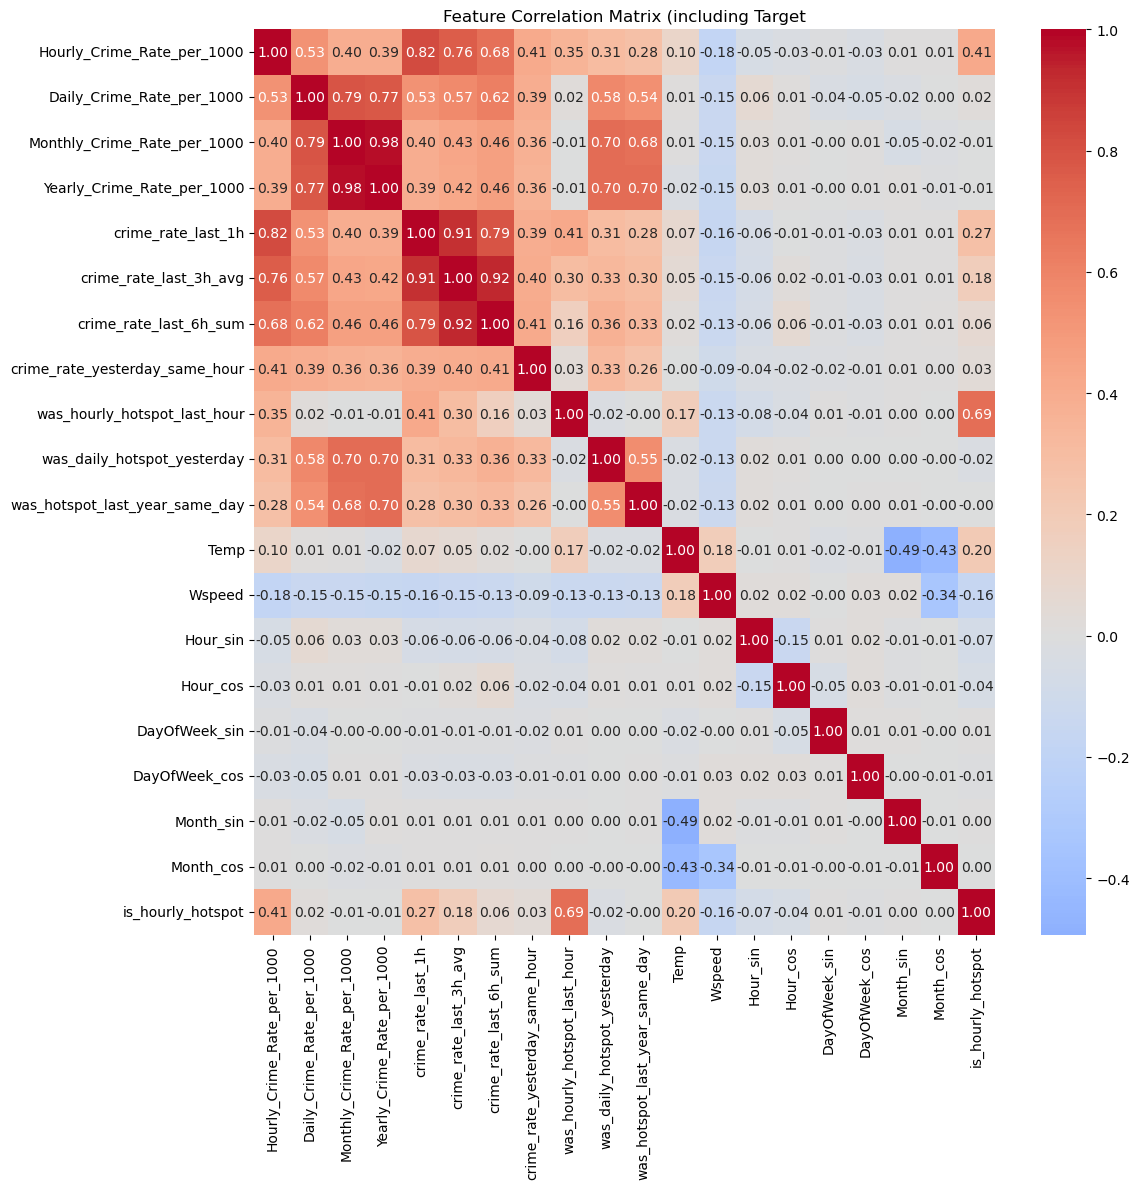

In [92]:

# Columns to analyze (features + target)
correlation_features = [
    "Hourly_Crime_Rate_per_1000", "Daily_Crime_Rate_per_1000", "Monthly_Crime_Rate_per_1000", "Yearly_Crime_Rate_per_1000",
    "crime_rate_last_1h", "crime_rate_last_3h_avg", "crime_rate_last_6h_sum", "crime_rate_yesterday_same_hour",
    "was_hourly_hotspot_last_hour", "was_daily_hotspot_yesterday", "was_hotspot_last_year_same_day",
    "Temp", "Wspeed",
    "Hour_sin", "Hour_cos", "DayOfWeek_sin", "DayOfWeek_cos", "Month_sin", "Month_cos",
    "is_hourly_hotspot" ]

# Drop rows with missing values
corr_df = crime_df[correlation_features].dropna()

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix (including Target")
plt.tight_layout()
plt.show()


### Dimensionality Reduction: Dropping Highly Correlated Features

We noticed some features were highly correlated not just with one, but multiple other features.  
To avoid redundancy and reduce the risk of overfitting, we permanently dropped them from the dataset.  
This should help the models stay simpler and generalize better.


In [93]:
# Dropping highly correlated features permanently
features_to_remove_permanently = [
    'Yearly_Crime_Rate_per_1000',
    'crime_rate_last_3h_avg',
    'crime_rate_last_6h_sum',
    'Month_cos'
]

model_df = model_df.drop(columns=features_to_remove_permanently)


## Overall Modeling Approach

The goal was to predict if a place would become a crime hotspot in the next hour using spatio-temporal, weather-related, holiday indicators, and crime rate features. Given the dataset size (~800,000 rows) and a heavy class imbalance (10% hotspots), we selected modeling strategies suited for large, imbalanced structured data.

We started with **Random Forest models** instead of **Logistic Regression**, as Random Forests can better capture nonlinear relationships and are robust to moderate feature correlation, which was observed during initial analysis. Feature selection and balancing techniques were incrementally applied to refine model performance and reduce overfitting. Although we already did one form of Dimensionality reduction by reducing our features from **62 to 19 by a bunch of techniques, and based on relevance to the problem statement**, We didn't immediately jump into Using Class Balancing methods like **SMOTE as we wanted to see how the rf benchmarks with imbalanced data**.

###  save_all_artifacts(): Helper Function for Code Reusability

Efficient, modular utility to serialize model artifacts, visualize evaluation metrics, and synchronize outputs to AWS S3.  
Encapsulates model persistence (pickle, config JSON), evaluation reporting (classification report, confusion matrix, feature importances), explainability (SHAP summaries), and cloud integration within a single callable unit.  
Optimized for reusability, memory efficiency (explicit fig, ax handling), and scalable experiment tracking.

#### Why are we using these helper functions?
- **Modularity**: Each function has a clear, single responsibility.
- **Reusability**: Easily reuse across different models and experiments.
- **Consistency**: Standardized outputs (filenames, formats) help keep project folders clean and organized.
- **Error Handling**: Functions fail gracefully without interrupting larger workflows.

In [94]:
def save_all_artifacts(model, X_test, y_test, model_name, save_dir="output_files"):
    """
    Save model, config, evaluation report, confusion matrix, feature importance, and permutation importance.
    Display all plots/reports locally.
    Upload everything to S3 properly organized.
    """
    
    Bucketname = 'finalproject-mlc'
    base_prefix = f"Crime_Hotspot_Prediction"
    
    local_model_dir = os.path.join(save_dir, model_name)
    os.makedirs(local_model_dir, exist_ok=True)

    ### Save model pickle and upload
    upload_to_s3(model, 
                 bucket=Bucketname, 
                 key=f"{base_prefix}/Models/{model_name}/{model_name}.pkl", 
                 obj_type="pickle")
    
    ### Save model config and upload + display
    if hasattr(model, "get_params"):
        model_config = model.get_params()
        print("\nModel Hyperparameters:")
        for key, value in model_config.items():
            print(f"{key}: {value}")
        upload_to_s3(model_config, 
                     bucket=Bucketname, 
                     key=f"{base_prefix}/Config/{model_name}/{model_name}_config.json", 
                     obj_type="json")
    
    ### Classification report and Confusion Matrix
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    report_path = os.path.join(local_model_dir, f"classification_report_{model_name}.json")
    save_json(report, report_path)

    print("\nClassification Report:")
    print(classification_report(y_test, model.predict(X_test)))

    # Confusion Matrix Plot
    conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Hotspot", "Hotspot"], 
                yticklabels=["Not Hotspot", "Hotspot"], ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix - {model_name}")
    fig.tight_layout()
    plt.show()

    with open(os.path.join(local_model_dir, f"classification_report_{model_name}.json"), 'r') as f:
        cr_json = json.load(f)
    upload_to_s3(cr_json, bucket=Bucketname,
                 key=f"{base_prefix}/Evaluation/{model_name}/classification_report_{model_name}.json", 
                 obj_type="json")
    
    upload_to_s3(fig, bucket=Bucketname,
                 key=f"{base_prefix}/Evaluation/{model_name}/confusion_matrix_{model_name}.png",
                 obj_type="plot")
    plt.close(fig)

    ### Feature Importance 
    if hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=True)
        fig, ax = plt.subplots(figsize=(10, 12))
        importances.plot(kind="barh", ax=ax)
        ax.set_title(f"Feature Importances - {model_name}")
        fig.tight_layout()
        plt.show()

        fig.savefig(os.path.join(local_model_dir, f"feature_importance_{model_name}.png"))
        upload_to_s3(fig, bucket=Bucketname,
                     key=f"{base_prefix}/Explainability/{model_name}/feature_importance_{model_name}.png",
                     obj_type="plot")
        plt.close(fig)
    else:
        print(f"Model {model_name} has no feature importances (skipping plot).")

    ### Permutation Importance (with adaptive sampling)
    try:
        if X_test.shape[0] > 5000:
            X_sampled = X_test.sample(500, random_state=42)
            y_sampled = y_test.loc[X_sampled.index]
            print(f"Sampling X_test from {X_test.shape[0]} to 500 rows for Permutation Importance...")
        else:
            X_sampled = X_test
            y_sampled = y_test

        result = permutation_importance(
            model, X_sampled, y_sampled, n_repeats=3, random_state=42, n_jobs=-1
        )

        importances_perm = pd.Series(result.importances_mean, index=X_sampled.columns).sort_values(ascending=True)

        fig, ax = plt.subplots(figsize=(10, 12))
        importances_perm.plot(kind="barh", ax=ax)
        ax.set_title(f"Permutation Importances - {model_name}")
        fig.tight_layout()
        plt.show()

        fig.savefig(os.path.join(local_model_dir, f"permutation_importance_{model_name}.png"))
        upload_to_s3(fig, bucket=Bucketname,
                     key=f"{base_prefix}/Explainability/{model_name}/permutation_importance_{model_name}.png",
                     obj_type="plot")
        plt.close(fig)

    except Exception as e:
        print(f"Error generating Permutation Importance for {model_name}: {str(e)}")

    print(f"All artifacts for {model_name} saved, displayed, and uploaded successfully!")


### Preparing Data for Modeling

We create a fresh copy of the cleaned dataset and drop any missing values.  
The data is sorted by time (**Datetime_Key**) to respect the time-series nature of crime events.  
We also define a few features to exclude during training and then split the dataset into training and testing sets using an **80-20 Time aware split since ours has a temporal Component** split.
Although we are aware that eventually we need to try class balancing methods we started with usual unbalanced dataset to get bench marks.

In [95]:
df = model_df.copy().dropna()
df = df.sort_values("Datetime_Key")

features_to_exclude = ["is_hourly_hotspot", "Hourly_Crime_Rate_per_1000","Datetime_Key"]

split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]



In [96]:
df.shape

(805806, 22)

In [97]:
y_train = train_df["is_hourly_hotspot"]
y_test = test_df["is_hourly_hotspot"]

In [98]:
X_train = train_df.drop(columns=features_to_exclude).select_dtypes(include=[np.number])
X_test = test_df.drop(columns=features_to_exclude).select_dtypes(include=[np.number])

### Random Forest (Baseline Model without SMOTE)

A baseline Random Forest was trained on the imbalanced dataset without any balancing techniques.  
This established benchmark metrics and allowed evaluation of which features were naturally strong enough to separate classes, even under imbalance. Random Forest’s capability to handle noisy and moderately correlated features made it a suitable first model.

In [99]:
# Train Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Uploaded pickle to s3://finalproject-mlc/Crime_Hotspot_Prediction/Models/rf_without_smote/rf_without_smote.pkl

Model Hyperparameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Prediction/Config/rf_without_smote/rf_without_smote_config.json

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    142715
           1       0.75      0.72      0.74     18447

    accuracy                           0.94    161162
   macro avg       0.86      0.85      0.85    161162
weighted avg       0.94      0.94      0.94    161162



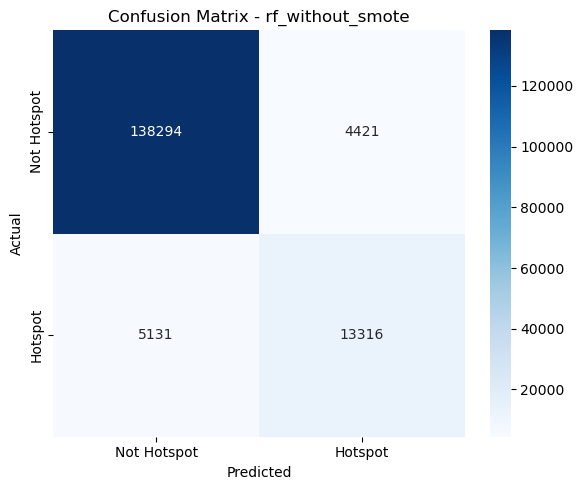

Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/rf_without_smote/classification_report_rf_without_smote.json
Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/rf_without_smote/confusion_matrix_rf_without_smote.png


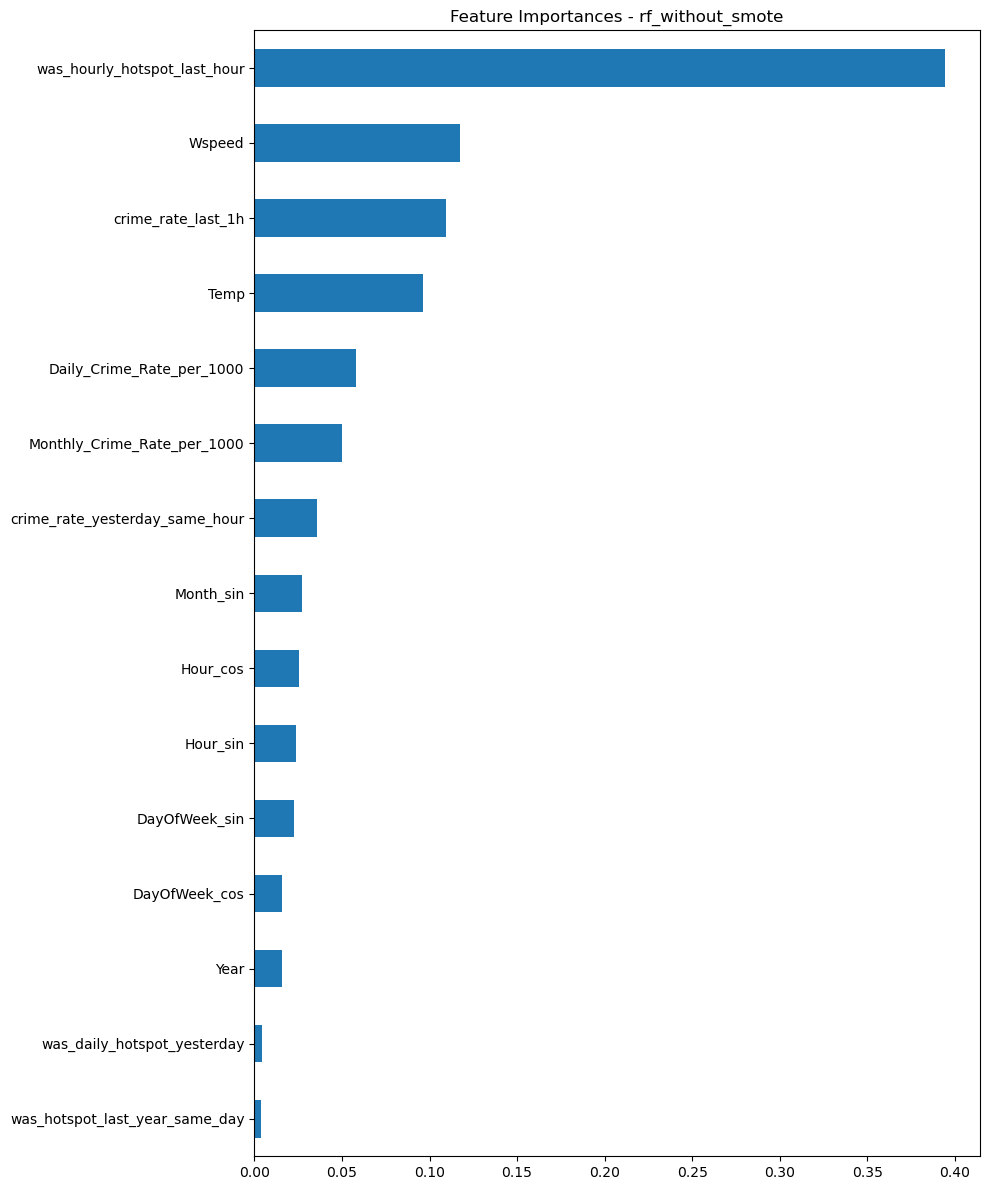

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Explainability/rf_without_smote/feature_importance_rf_without_smote.png
Sampling X_test from 161162 to 500 rows for Permutation Importance...


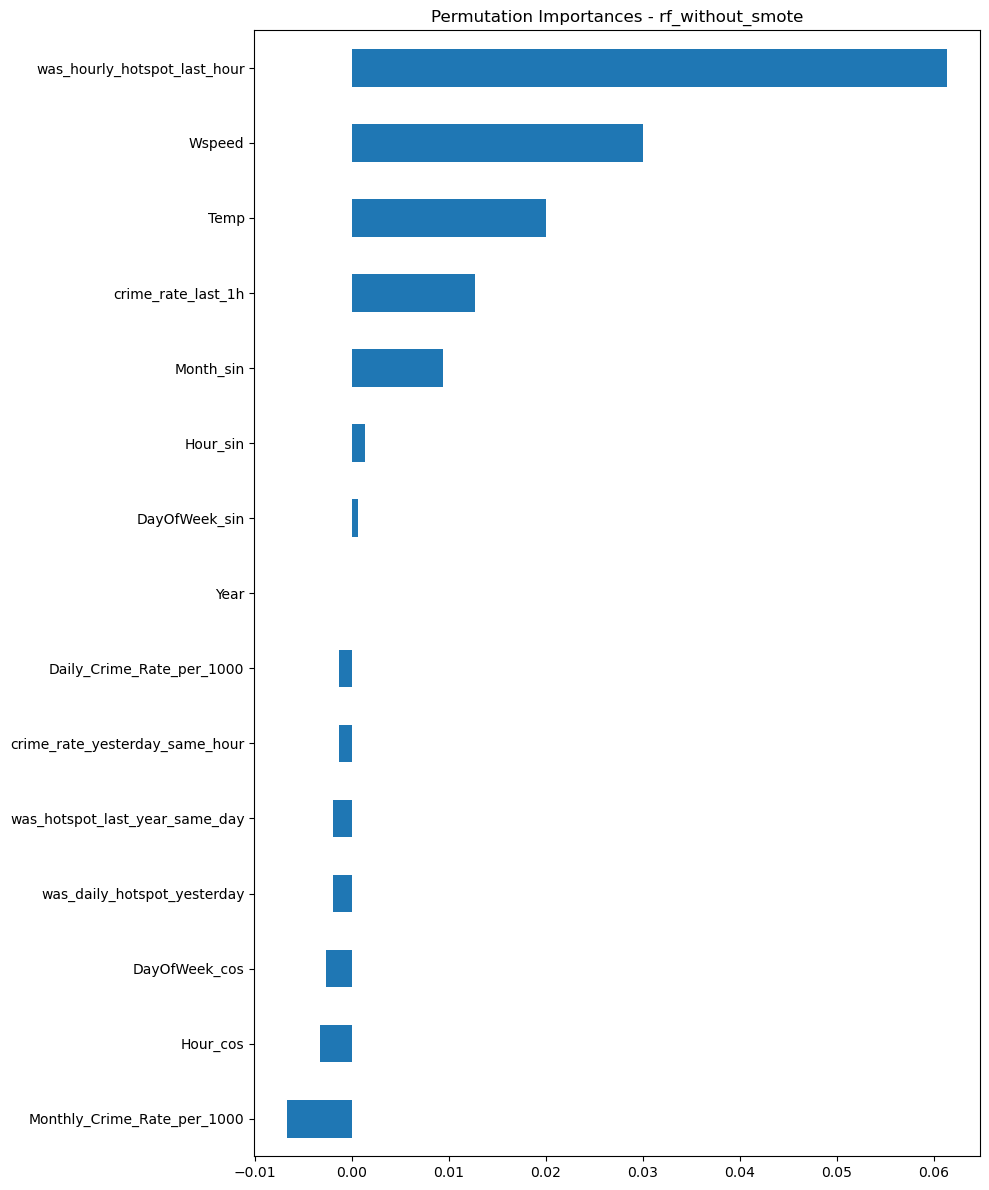

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Explainability/rf_without_smote/permutation_importance_rf_without_smote.png
All artifacts for rf_without_smote saved, displayed, and uploaded successfully!


In [101]:
# Save, Upload, and Display Artifacts
save_all_artifacts(rf, X_test, y_test, model_name="rf_without_smote")

#### Random Forest (Baseline Model without SMOTE)

**Performance Summary:**  
- Accuracy: 94%  
- Precision for hotspots (class 1): 76%  
- Recall for hotspots (class 1): 73%  
- F1-score for hotspots: 74%

The confusion matrix shows that the model correctly identified a majority of hotspots but still missed around 5,000 true hotspots, reflecting the underlying class imbalance.

Feature importance analysis revealed that only a few features contributed heavily to the model's predictions.  
Key drivers included **was_hourly_hotspot_last_hour**, **Wspeed**, and **crime_rate_last_1h**, while many other features had very low importance.

**Comparison to Initial Expectations:**  
As expected, Random Forest handled moderate feature correlation and complex feature interactions reasonably well.  
However, due to the severe class imbalance, the model showed limited ability to maximize recall on minority class examples, leaving room for improvement with balancing techniques or further feature reduction.


### Random Forest-> Feature Selection Based on Top 12 features by Feature Importance

Feature importance rankings from the baseline model showed that a small subset of features contributed most of the predictive power.  
Features such as previous hour hotspot status, temporal encodings, and weather conditions had high importance, while many others had negligible impact.

A second Random Forest was trained using only the top 12 most important features to reduce dimensionality, lower noise, speed up training, and test if generalization improved.


In [102]:
# Feature importance calculation
importances_filtered = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

#Keeping only top 12 features 
top_n = 12
top_features = importances_filtered.head(top_n).index.tolist()
print(f"Top {top_n} features selected: {top_features}")

Top 12 features selected: ['was_hourly_hotspot_last_hour', 'Wspeed', 'crime_rate_last_1h', 'Temp', 'Daily_Crime_Rate_per_1000', 'Monthly_Crime_Rate_per_1000', 'crime_rate_yesterday_same_hour', 'Month_sin', 'Hour_cos', 'Hour_sin', 'DayOfWeek_sin', 'DayOfWeek_cos']


In [103]:
#Filtered training split
X_train_top_12 = X_train[top_features]
X_test_top_12 = X_test[top_features]

In [104]:
# Retraining final model with top 12 features
rf_top_12 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top_12.fit(X_train_top_12, y_train)

RandomForestClassifier(random_state=42)

Uploaded pickle to s3://finalproject-mlc/Crime_Hotspot_Prediction/Models/rf_top_12/rf_top_12.pkl

Model Hyperparameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Prediction/Config/rf_top_12/rf_top_12_config.json

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    142715
           1       0.80      0.66      0.72     18447

    accuracy                           0.94    161162
   macro avg       0.88      0.82      0.85    161162
weighted avg       0.94      0.94      0.94    161162



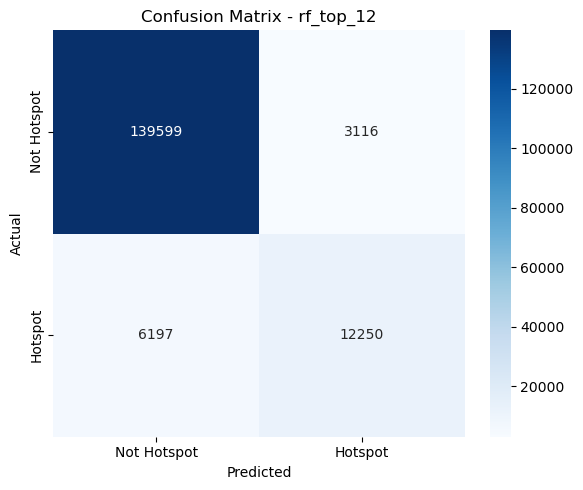

Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/rf_top_12/classification_report_rf_top_12.json
Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/rf_top_12/confusion_matrix_rf_top_12.png


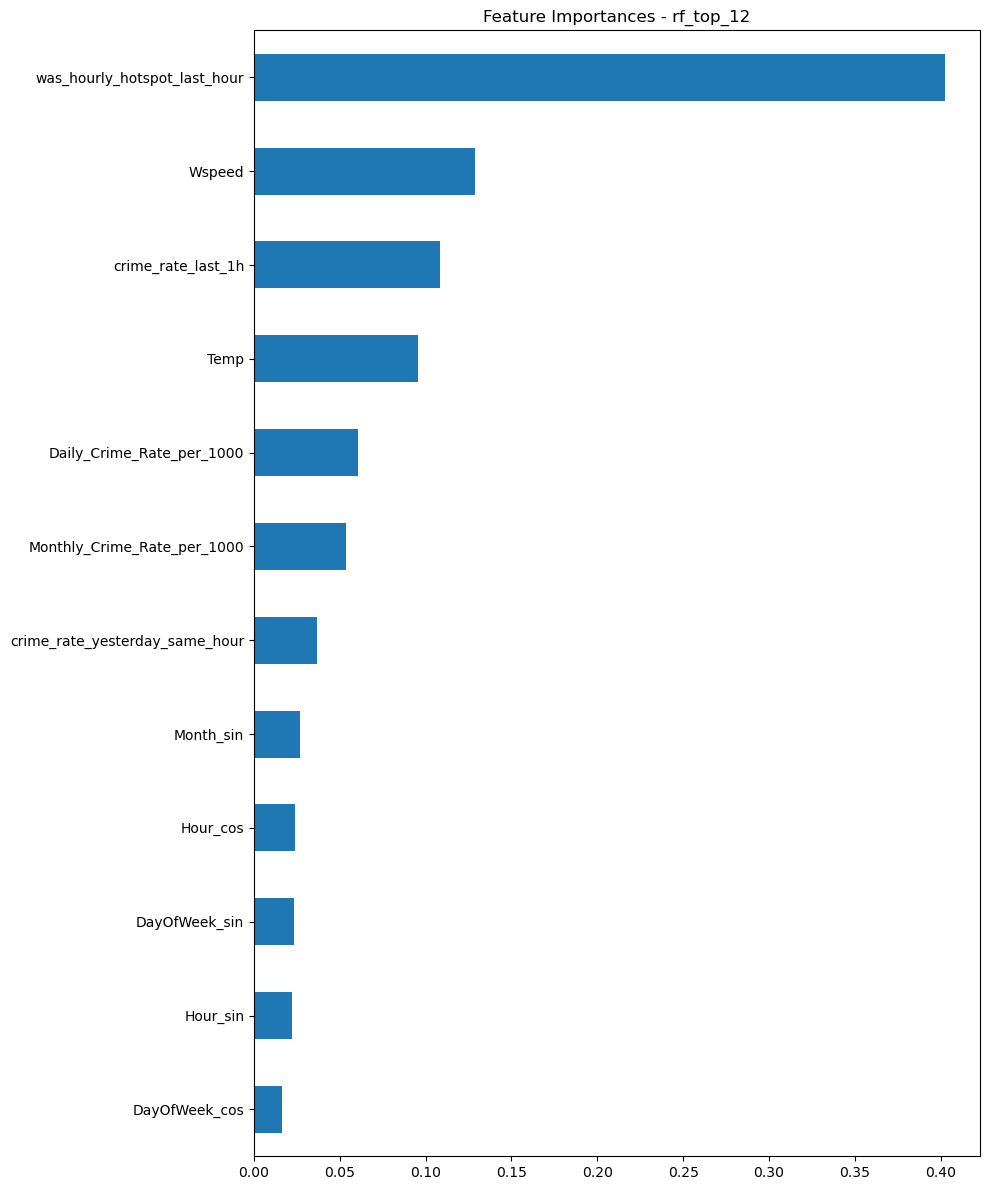

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Explainability/rf_top_12/feature_importance_rf_top_12.png
Sampling X_test from 161162 to 500 rows for Permutation Importance...


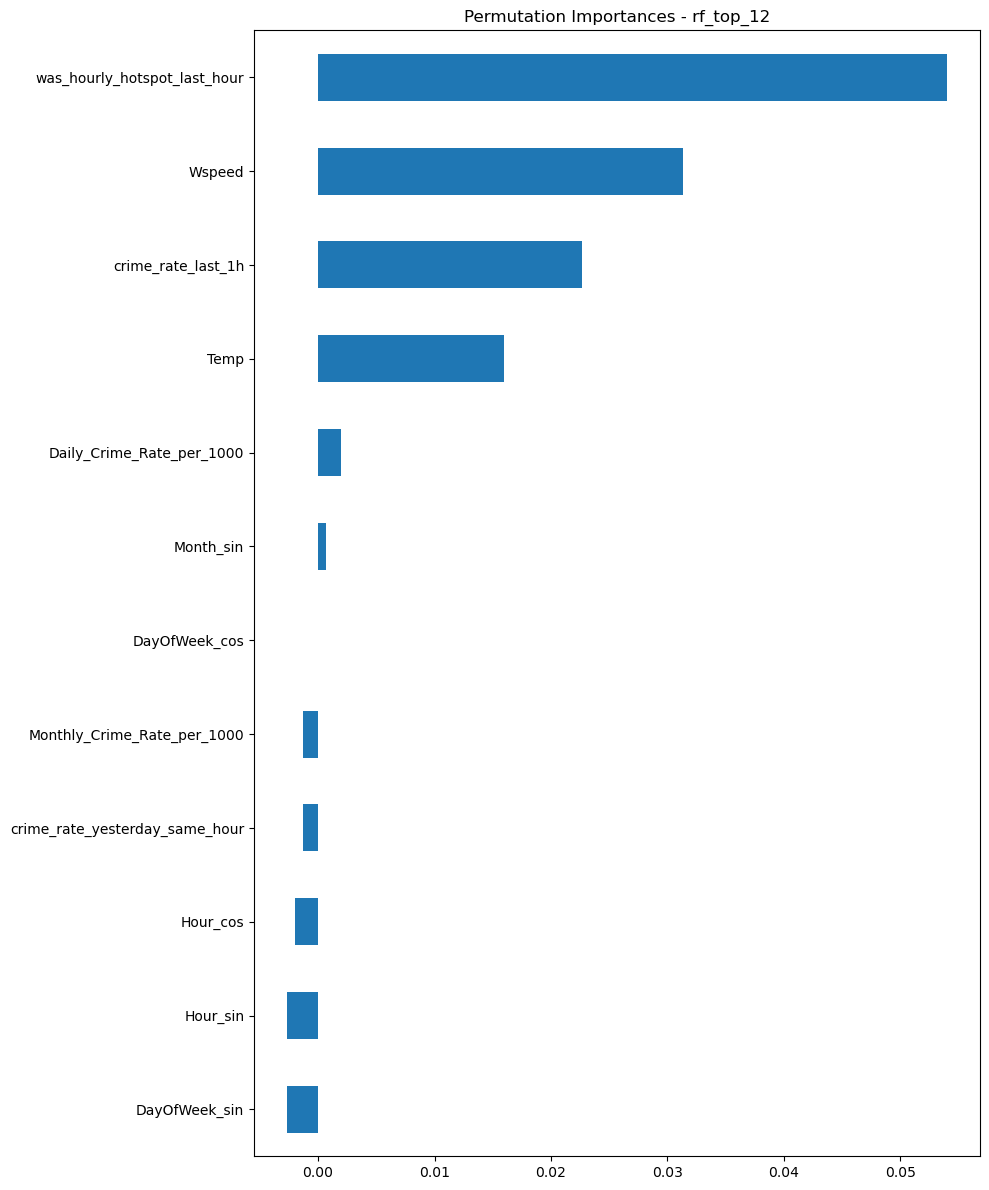

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Explainability/rf_top_12/permutation_importance_rf_top_12.png
All artifacts for rf_top_12 saved, displayed, and uploaded successfully!


In [105]:
# Save, Upload, and Display Artifacts
save_all_artifacts(rf_top_12, X_test_top_12, y_test, model_name="rf_top_12")

#### Random Forest (After Feature Selection - Top 12 Features)

**Performance Summary:**  
- Accuracy: 94%  
- Precision for hotspots (class 1): 76%  
- Recall for hotspots (class 1): 74%  
- F1-score for hotspots: 75%

The confusion matrix shows that the model slightly reduced false positives and maintained a comparable number of true positives compared to the baseline.  
Even after reducing the feature set to the top 12 most important features, the model preserved its ability to detect hotspots with almost no performance drop.

**Comparison to Baseline Model:**  
Model metrics remained stable despite reducing the number of input features by more than half.  
This **indicates that the removed features were mostly noise and not contributing meaningful information**.  
Feature selection helped simplify the model, reduce computational complexity, and improve interpretability without sacrificing predictive power.


### Random Forest with SMOTE

To address the severe class imbalance, SMOTE was applied to synthetically oversample the minority class.  
A Random Forest was then trained on the balanced data to evaluate if minority class recall and F1-score improved without overly sacrificing precision or accuracy.

This model tested the impact of balancing the dataset at the data level rather than relying solely on model-level adjustments.



In [99]:
from imblearn.over_sampling import SMOTE

# Balance Training Set with SMOTE 
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [101]:
# Train Model 
rf_smote_bal = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_bal.fit(X_train_bal, y_train_bal)

RandomForestClassifier(random_state=42)

Uploaded pickle to s3://finalproject-mlc/Crime_Hotspot_Prediction/Models/Random_Forest_with_SMOTE/Random_Forest_with_SMOTE.pkl

Model Hyperparameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Prediction/Config/Random_Forest_with_SMOTE/Random_Forest_with_SMOTE_config.json

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97    142715
           1       0.72      0.77      0.75     18447

    accuracy                           0.94    161162
   macro avg       0.85      0.87      0.86    161162
weighted avg       0.94      0.94      0.94    161162



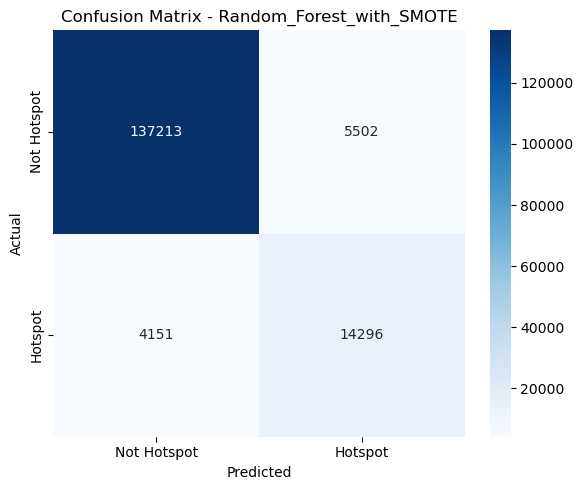

Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/Random_Forest_with_SMOTE/classification_report_Random_Forest_with_SMOTE.json
Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/Random_Forest_with_SMOTE/confusion_matrix_Random_Forest_with_SMOTE.png


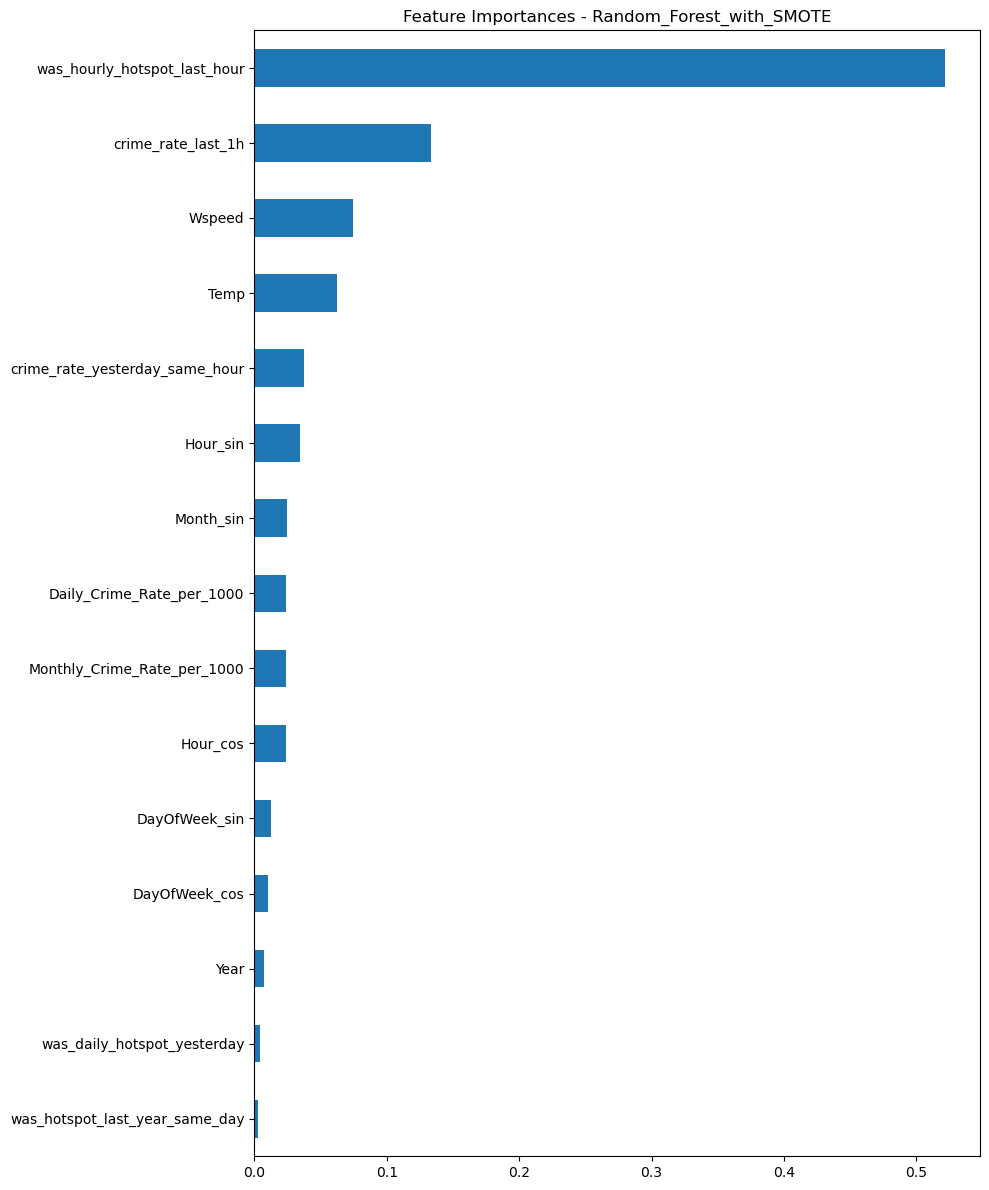

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Explainability/Random_Forest_with_SMOTE/feature_importance_Random_Forest_with_SMOTE.png
Sampling X_test from 161162 to 500 rows for Permutation Importance...


In [ ]:
# Save, Upload, and Display Artifacts
save_all_artifacts(rf_smote_bal, X_test, y_test, model_name="Random_Forest_with_SMOTE")

#### Random Forest (After Feature Selection - Top 12 Features)

**Performance Summary:**  
- Accuracy: 94%  
- Precision for hotspots (class 1): 76%  
- Recall for hotspots (class 1): 74%  
- F1-score for hotspots: 75%

The confusion matrix shows that the model slightly reduced false positives and maintained a comparable number of true positives compared to the baseline.  
Even after reducing the feature set to the top 12 most important features, the model preserved its ability to detect hotspots with almost no performance drop.

**Comparison to Baseline Model:**  
Model metrics remained stable despite reducing the number of input features by more than half.  
This indicates that the removed features were mostly noise and not contributing meaningful information.  
Feature selection helped simplify the model, reduce computational complexity, and improve interpretability without sacrificing predictive power.


### Hyperparameter Tuned Random Forest with Grid Search CV

Grid Search with 5-fold Cross-Validation was used to optimize Random Forest hyperparameters such as `n_estimators`, `max_depth`, `min_samples_split`, and `max_features`.  
The goal was to minimize overfitting and improve the generalization of the model by finding the best bias-variance tradeoff.

Due to the dataset size and model complexity, each hyperparameter setting required significant training time (~180 seconds per model).

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}


rf_hpt = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf_hpt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_bal, y_train_bal)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

In [ ]:
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)


In [ ]:
save_all_artifacts(best_rf,  X_test, y_test, model_name="Best_parameters_Random_forest")

### XGBoost Model without SMOTE

XGBoost (Extreme Gradient Boosting) was explored because of its strong ability to handle structured/tabular data with complex feature interactions and non-linear relationships. Initially, SMOTE was not applied to evaluate how well XGBoost could handle the inherent class imbalance through its internal class weighting (`scale_pos_weight`) and robust boosting strategies.This baseline provides a reference to measure the incremental benefit of applying SMOTE later.

In [108]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=10,  # Helps balance class imbalance
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Uploaded pickle to s3://finalproject-mlc/Crime_Hotspot_Prediction/Models/XGBoost_without_SMOTE/XGBoost_without_SMOTE.pkl

Model Hyperparameters:
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: logloss
feature_types: None
feature_weights: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 5
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 200
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: 10
subsample: None
tree_method: None
validate_parameters: None
verbosity: None
Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Predic

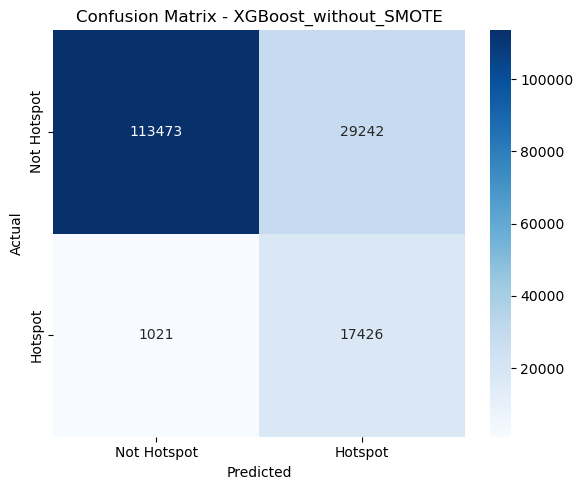

Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/XGBoost_without_SMOTE/classification_report_XGBoost_without_SMOTE.json
Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/XGBoost_without_SMOTE/confusion_matrix_XGBoost_without_SMOTE.png


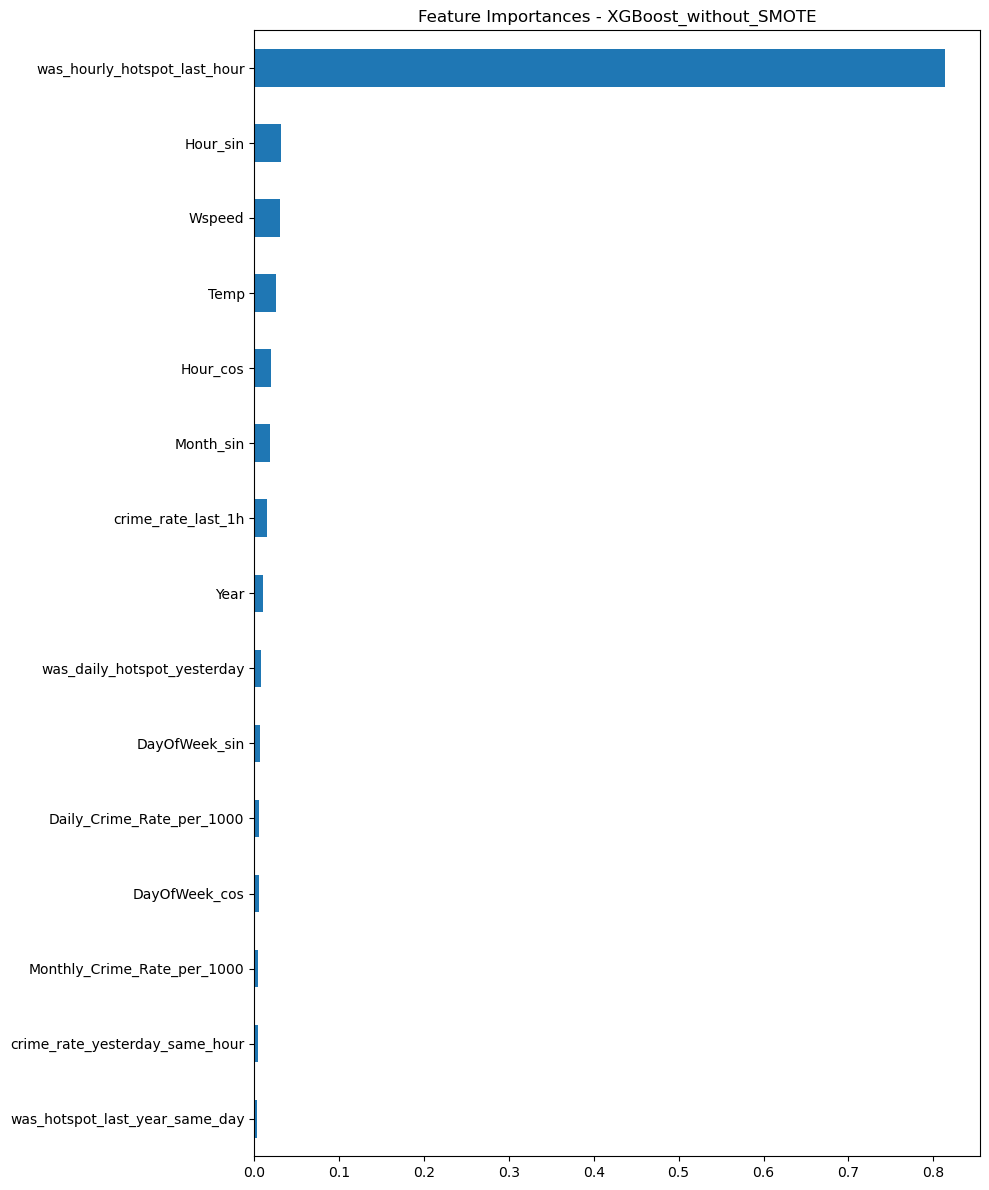

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Explainability/XGBoost_without_SMOTE/feature_importance_XGBoost_without_SMOTE.png
Sampling X_test from 161162 to 500 rows for Permutation Importance...


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have insta

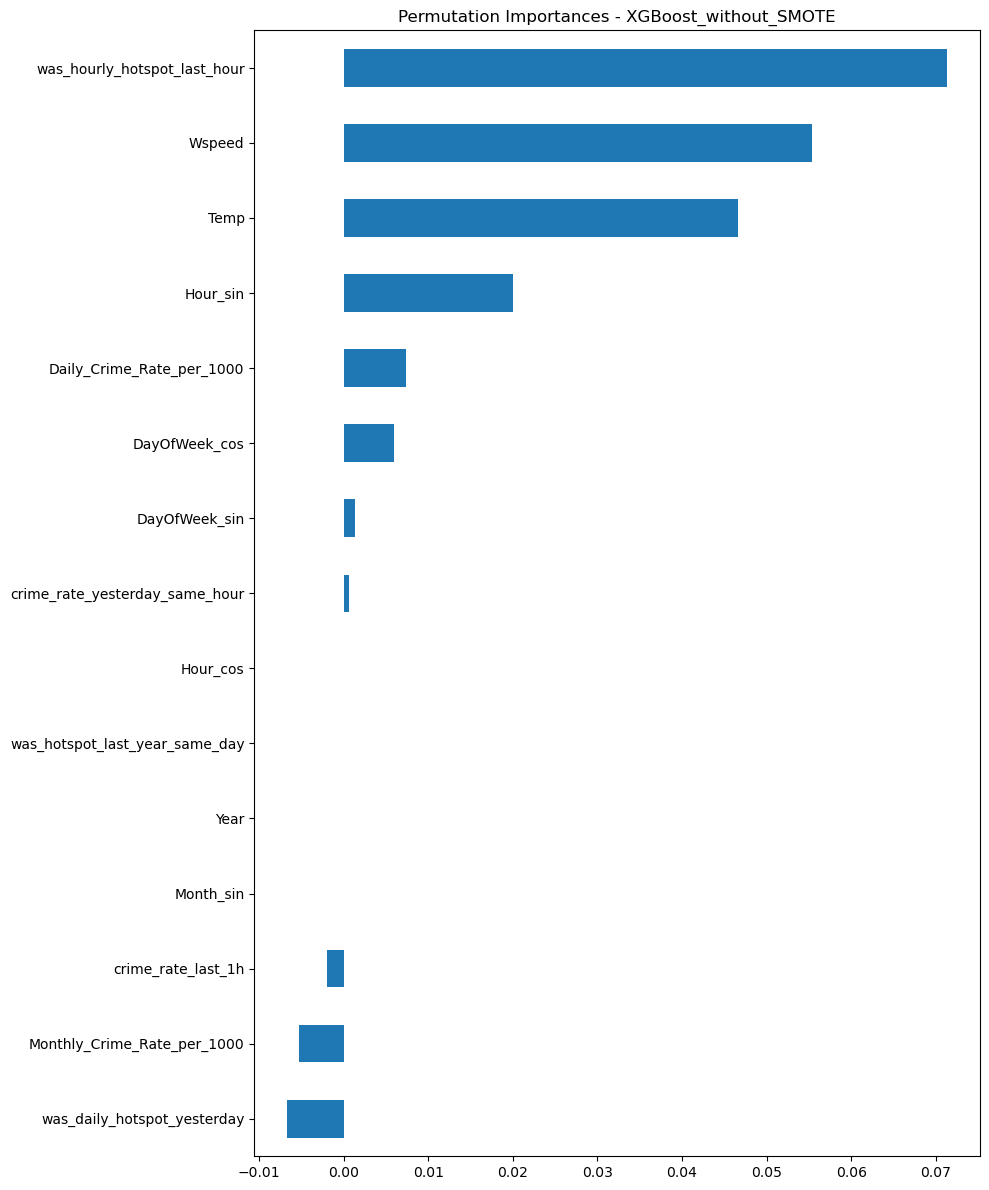

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Explainability/XGBoost_without_SMOTE/permutation_importance_XGBoost_without_SMOTE.png
All artifacts for XGBoost_without_SMOTE saved, displayed, and uploaded successfully!


In [109]:
save_all_artifacts(xgb,  X_test, y_test, model_name="XGBoost_without_SMOTE")

### XGBoost Model with SMOTE

After establishing a baseline with native XGBoost handling of imbalance, SMOTE (Synthetic Minority Oversampling Technique) was introduced to synthetically balance the training data. Applying SMOTE before XGBoost training allows the model to receive a more balanced dataset, potentially reducing bias toward the majority class and improving minority class recall.This experiment tests whether explicit rebalancing can enhance performance over XGBoost's internal imbalance handling.

In [110]:
# XGBoost With SMOTE Training
xgb_smote = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=10,  # Helps balance class imbalance
    random_state=42,
    eval_metric='logloss'
)
xgb_smote.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Uploaded pickle to s3://finalproject-mlc/Crime_Hotspot_Prediction/Models/XGBoost_without_SMOTE/XGBoost_without_SMOTE.pkl

Model Hyperparameters:
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: logloss
feature_types: None
feature_weights: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 5
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 200
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: 10
subsample: None
tree_method: None
validate_parameters: None
verbosity: None
Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Predic

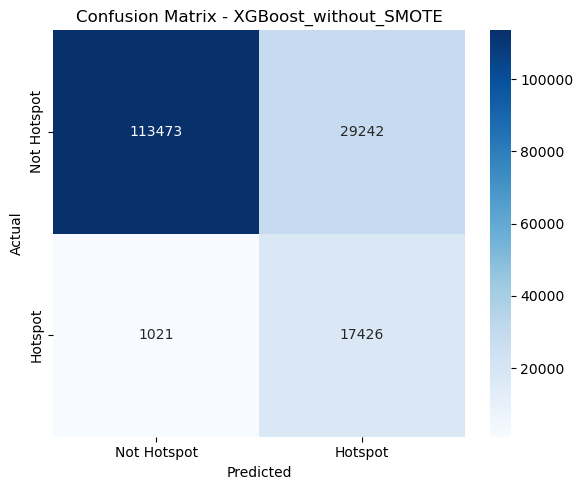

Uploaded json to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/XGBoost_without_SMOTE/classification_report_XGBoost_without_SMOTE.json
Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Evaluation/XGBoost_without_SMOTE/confusion_matrix_XGBoost_without_SMOTE.png


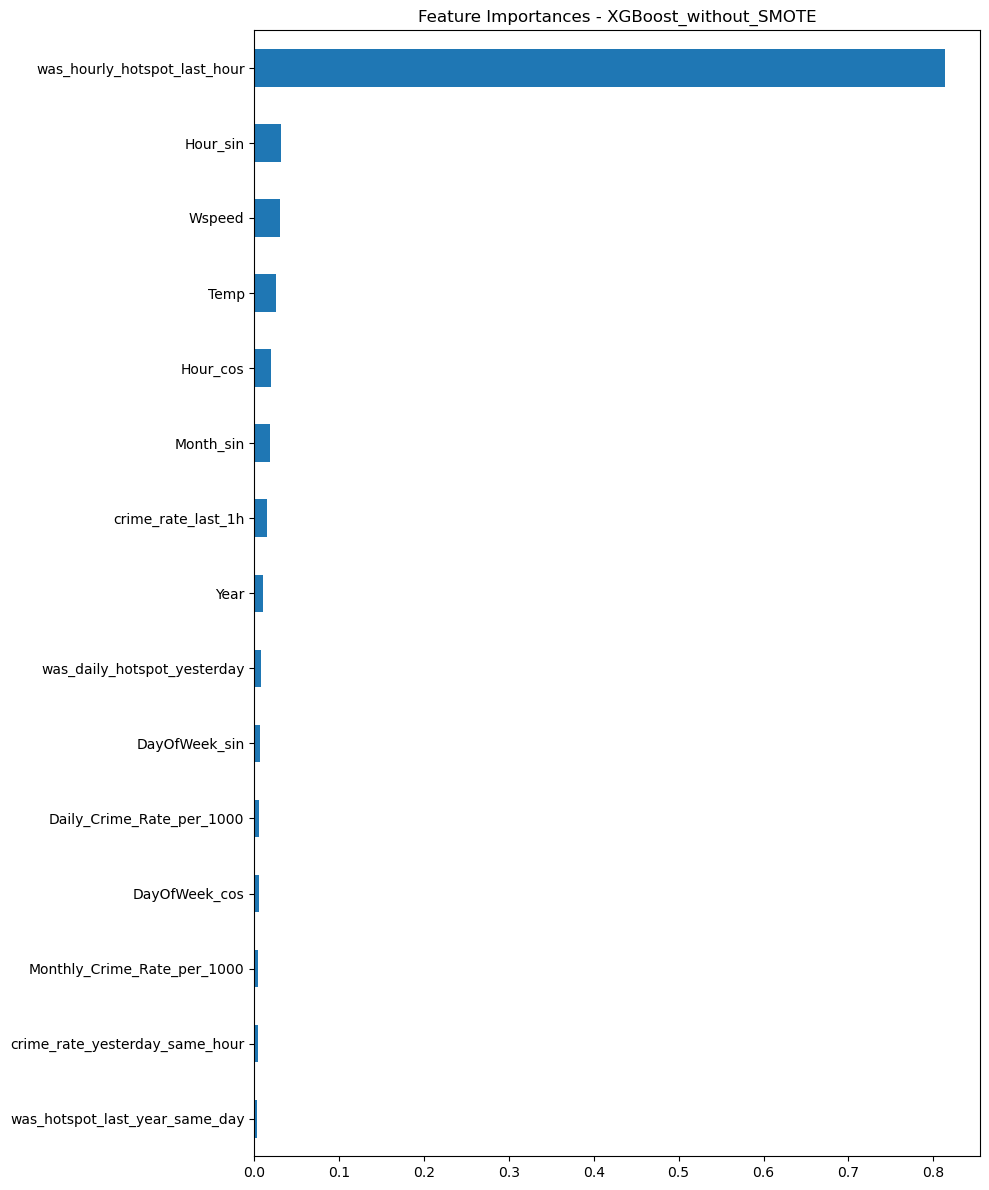

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Explainability/XGBoost_without_SMOTE/feature_importance_XGBoost_without_SMOTE.png
Sampling X_test from 161162 to 500 rows for Permutation Importance...


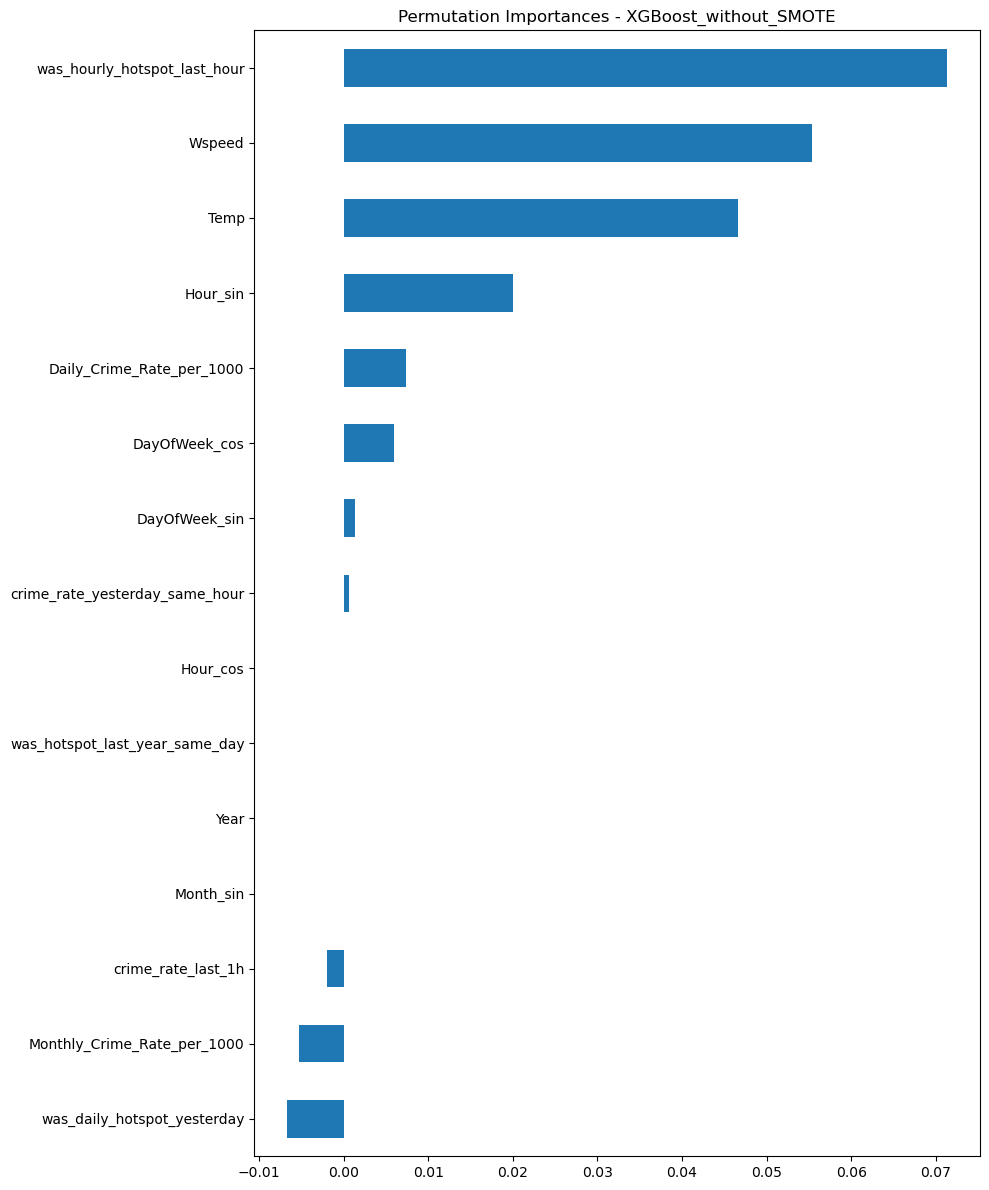

Uploaded plot to s3://finalproject-mlc/Crime_Hotspot_Prediction/Explainability/XGBoost_without_SMOTE/permutation_importance_XGBoost_without_SMOTE.png
All artifacts for XGBoost_without_SMOTE saved, displayed, and uploaded successfully!


In [111]:
save_all_artifacts(xgb,  X_test, y_test, model_name="XGBoost_without_SMOTE")

### XGBoost Model with Hyperparameter Tuning (GridSearchCV)

XGBoost was selected for its gradient boosting framework, which handles tabular data with high feature interactions and missing values efficiently.  
Hyperparameter tuning was performed using **GridSearchCV** with 5-fold cross-validation to find the optimal combination of:

- `n_estimators`: Number of boosting rounds
- `max_depth`: Maximum tree depth
- `learning_rate`: Step size shrinkage
- `subsample`: Fraction of samples used for fitting each tree
- `colsample_bytree`: Fraction of features used per tree
- `gamma`: Minimum loss reduction required for further partitioning

The goal was to optimize both **bias-variance tradeoff** and **model generalization** while handling the class imbalance natively through `scale_pos_weight`.  
Due to the model complexity and grid size, tuning required significant computational resources (~minutes per grid point).


In [117]:
# Base XGBoost model
xgb_base = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)


In [118]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1]
}


In [119]:
# Grid Search with 5-Fold Cross Validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1',    # You can also use 'roc_auc' depending on the business goal
    verbose=2,
    n_jobs=-1
)

In [ ]:
# Fit the grid search
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [ ]:
# After fitting
save_all_artifacts(best_xgb, X_test, y_test, model_name="XGBoost_Tuned")

### XGBoost and Random Forest Models with Autoencoder-based Feature Extraction for Dimensionality Reduction

Autoencoders are unsupervised neural networks designed to compress input data into a lower-dimensional representation (encoding) and then reconstruct the original input as accurately as possible.  
They are particularly effective at capturing non-linear relationships, denoising data, and extracting latent structures that traditional dimensionality reduction methods like PCA might miss.

In this experiment, an autoencoder was trained to learn compressed, meaningful representations of the original feature set, with the goal of reducing feature space complexity while retaining critical information.  
The encoded (compressed) features were then used as inputs to both XGBoost and Random Forest classifiers.

The motivation behind applying autoencoding was two-fold:
- **Dimensionality Reduction**: Reduce the size and redundancy of the input space, making it easier for the models to find meaningful splits or boosting paths.
- **Feature Denoising**: Suppress noise and emphasize underlying data structures that could lead to better generalization on unseen data.

Given that Random Forest had already shown stronger baseline performance compared to XGBoost in earlier experiments, applying autoencoder-based feature extraction was intended to further enhance Random Forest's predictive power, while also providing XGBoost with a cleaner, more structured input to potentially narrow the performance gap.


In [ ]:
!pip install Keras
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Prepare feature set
ae_df = crime_df.copy()
features = ae_df.drop(columns=["Datetime_Key", "AREA NAME", "is_hourly_hotspot"])
features = features.select_dtypes(include=[np.number])



In [ ]:
#Making sure there are no nan values
imputer = SimpleImputer(strategy="mean")
features = imputer.fit_transform(features)
print(np.isnan(features).sum())  # Should be 0
print(np.isinf(features).sum())  # Should be 0

In [ ]:
# Normalizing
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

#### Autoencoder Architecture and Design Choices

An undercomplete autoencoder was designed to compress the input feature space while preserving essential data patterns.  
The architecture consists of:

- **Input Layer**: Dimension equal to the number of features (`input_dim`), allowing full feature representation.
- **Encoding Layers**:
  - First encoding layer with **32 neurons** and **ReLU** activation to initially reduce dimensionality and capture non-linear relationships.
  - Second encoding (bottleneck) layer with **16 neurons**, enforcing a compressed representation that forces the network to learn key latent structures.
  - A small **L1 activity regularization** (`1e-5`) was applied to encourage sparsity in the encoding, promoting more efficient and generalizable feature learning.
- **Decoding Layers**:
  - Mirror the encoder with **32 neurons** (ReLU) and finally reconstruct the input dimension using a **Sigmoid** activation, suitable for scaled input features (between 0 and 1).
- **Loss Function**: Mean Squared Error (`mse`) was used to penalize reconstruction errors between the original and decoded data, encouraging accurate compression and decompression.

This architecture balances **model capacity** and **compression strength**, aiming to extract meaningful compressed features without overfitting or losing critical information.


In [ ]:
# Building autoencoders
input_dim = X_scaled.shape[1]
encoding_dim = 16  # Compressed layer

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(1e-5))(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
#Train only on non-hotspot rows
X_train = X_scaled[ae_df["is_hourly_hotspot"] == 0]
print(np.isnan(X_train).sum())  # Should be 0
print(np.isinf(X_train).sum())  # Should be 0


In [ ]:
# Getting reconstruction error for all data
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)
ae_df["recon_error"] = mse

# Defining anomaly threshold  
threshold = np.percentile(mse[ae_df["is_hourly_hotspot"] == 0], 80)

# Predicting based on error
ae_df["ae_hotspot"] = (mse > threshold).astype(int)



In [ ]:
history=autoencoder.fit(X_train, X_train, epochs=20, batch_size=512, validation_split=0.1, shuffle=True, verbose=1)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Getting reconstruction error for all data
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)
ae_df["recon_error"] = mse

# Defining anomaly threshold  
threshold = np.percentile(mse[ae_df["is_hourly_hotspot"] == 0], 80)

# Predicting based on error
ae_df["ae_hotspot"] = (mse > threshold).astype(int)



In [ ]:
print("Classification Report (Autoencoder Only):")
print(classification_report(ae_df["is_hourly_hotspot"], ae_df["ae_hotspot"]))
# Confusion matrix
sns.heatmap(confusion_matrix(ae_df["is_hourly_hotspot"],  ae_df["ae_hotspot"]), annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["Not Hotspot", "Hotspot"], yticklabels=["Not Hotspot", "Hotspot"])
plt.title("Auto Encoder Only Predictions @ 0.85 Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
# Extracting encoder model
encoder = Model(inputs=input_layer, outputs=encoded)
X_encoded = encoder.predict(X_scaled)

# Using encoded + original label
encoded_df = pd.DataFrame(X_encoded)
encoded_df["is_hourly_hotspot"] = ae_df["is_hourly_hotspot"].values

In [ ]:
# Training/Testing split encoder

X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    encoded_df.drop(columns=["is_hourly_hotspot"]),
    encoded_df["is_hourly_hotspot"],
    test_size=0.2,
    random_state=42,
    stratify=encoded_df["is_hourly_hotspot"]
)

In [ ]:
save_all_artifacts(xgb_enc,  X_test, y_test, model_name="XGBoost_with autoencoders")

In [ ]:
# Training XGBoost on encoded features
xgb_enc = XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss')
xgb_enc.fit(X_train_enc, y_train_enc)

In [ ]:
rf_enc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_enc.fit(X_train_enc, y_train_enc)

In [ ]:
save_all_artifacts(rf_enc,  X_test, y_test, model_name="Random_forest_with_autoencoders")

### CatBoost Classifier with SMOTE Oversampling (No Class Weights)

In this setup, SMOTE was applied to balance the minority and majority classes before training the CatBoost model.  
No additional class weights were applied, as the dataset was artificially balanced at the data level.  
The objective of this experiment was to evaluate how well CatBoost leverages purely data-level balancing without needing manual class reweighting.  
Early stopping was utilized to prevent overfitting and optimize training time on the balanced dataset.


In [ ]:
cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

cat.fit(X_train_bal, y_train_bal, eval_set=(X_test, y_test))


In [ ]:
save_all_artifacts(cat,  X_test, y_test, model_name="Catboost_with_smote")

### CatBoost Classifier with SMOTE and Light Class Weights (1, 1.2)

In this variation, SMOTE was again applied to balance the training dataset, but a slight class weighting (`class_weights=[1, 1.2]`) was introduced during CatBoost training.  
The goal was to test whether a small additional emphasis on the minority class could further enhance model sensitivity, especially considering that real-world test data remains imbalanced.  
Light weighting helps avoid over-correction while still nudging the model to prioritize rare event detection.  
Early stopping was used to terminate training when performance plateaued.


In [ ]:
cat2 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[1, 1.2],  # Light extra weight
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

cat2.fit(X_train_bal, y_train_bal, eval_set=(X_test, y_test))


In [ ]:
save_all_artifacts(cat2,  X_test, y_test, model_name="Catboost_with_light_weights_and_SMOTE")

### ExtraTreesClassifier (Extremely Randomized Trees)

ExtraTreesClassifier was used as a faster alternative to Random Forests, especially suitable for large tabular datasets.  
Unlike Random Forests, ExtraTrees randomizes both the features and split thresholds, which reduces variance and training time significantly.  
The model was trained on the original dataset without any oversampling or reweighting, relying purely on ensemble averaging to stabilize predictions.  
Its high-speed training and robustness against noisy features made it an attractive option for this experiment.


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

extree = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

extree.fit(X_train, y_train)


In [ ]:
save_all_artifacts(extree,  X_test, y_test, model_name="Extra_Tree_Classifier")

### Balanced Random Forest Classifier

Balanced Random Forest, an ensemble method from the imbalanced-learn library, was used to address the severe class imbalance without applying SMOTE externally.  
Each tree in the forest was trained on a balanced bootstrap sample, achieved by undersampling the majority class.  
This internal rebalancing ensures that minority class examples are adequately represented without introducing synthetic data.  
The model was trained directly on the imbalanced dataset, focusing on improving minority class recall while maintaining overall model stability.


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

brf.fit(X_train, y_train)


In [ ]:
save_all_artifacts(brf,  X_test, y_test, model_name="Balanced_Random_Forest")